# Background

- First rotating dataset, first reasonable dataset in awhile, given COVID
- One probe in the magnet, SmarAct placed by hand in center of magnet, 3 probes outside magnet
- NMR not working on new computer
- NMR shipped to Europe for calibration soon...getting data while we can
- After NMR back, need survey done of magnet & SmarAct

# Code

## Imports

In [1]:
#%load_ext autoreload
#%autoreload 2

In [83]:
import math
import numpy as np
import pandas as pd
import pickle as pkl
from datetime import datetime
from dateutil import parser
from datetime import datetime
from sys import getsizeof
import re

import operator
from scipy import stats
import scipy.optimize as optimization
from scipy.interpolate import interp1d
import lmfit as lm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['axes.axisbelow'] = True

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.express as px
init_notebook_mode(True)

#import seaborn as sns
from wand.image import Image as WImage

from hallprobecalib import hpc_ext_path
#from hallprobecalib.hpcplots import scatter2d,scatter3d,histo,py_profile
from hallprobecalib.hpcplots import scatter2d,scatter3d,histo

In [43]:
make_plots = True

In [3]:
hpc_ext_path

'/home/ckampa/data/hallprobecalib_extras/'

In [3]:
plotdir = hpc_ext_path+'plots/hall_probe_rotate/2020-10-07/'

In [4]:
pkl_dir = hpc_ext_path+"datafiles/hall_probe_rotate/"
pkl_file_slow = "hall_rotate.run07.raw.slow.pkl"

In [5]:
df = pd.read_pickle(pkl_dir+pkl_file_slow)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ckampa/data/hallprobecalib_extras/datafiles/hall_probe_rotate/hall_rotate.run07.raw.slow.pkl'

In [6]:
df['seconds_delta'].head(10)

NameError: name 'df' is not defined

In [7]:
df.tail()

NameError: name 'df' is not defined

In [8]:
def pplot(fig):
    pio.write_image(fig, 'temp.pdf')
    img = WImage(filename='temp.pdf')
    return img

## Cleaning

In [9]:
directory = "/home/ckampa/Dropbox/LogFiles/"
filename = '2020-09-30 154632.txt'
filename_slow = '2020-09-30 154629slow.txt'

In [19]:
df = pd.read_csv(directory+filename)
df.columns = df.columns.str.lstrip(" ")
dates = [parser.parse(row.Time) for row in df.itertuples()]# if isdatetime(row.Time.values[0])]
df["Datetime"] = pd.to_datetime(dates)#.astype("str")
df = df.set_index("Datetime")

In [20]:
df_slow = pd.read_csv(directory+filename_slow)
df_slow.columns = df_slow.columns.str.lstrip(" ")
dates = [parser.parse(row.Time) for row in df_slow.itertuples()]# if isdatetime(row.Time.values[0])]
df_slow["Datetime"] = pd.to_datetime(dates)#.astype("str")
df_slow = df_slow.set_index("Datetime")

In [21]:
df.head()

,Time,Magnet Current [V],Magnet Voltage [V],NMR [T],NMR [FFT],DF0000000D5E803A_Raw_X,DF0000000D5E803A_Raw_Y,DF0000000D5E803A_Raw_Z,C90000000D53983A_Raw_X,C90000000D53983A_Raw_Y,...,DF0000000D5E803A_Cal_T,C90000000D53983A_Cal_T,C50000000D5E473A_Cal_T,6A0000000D61333A_Cal_T,SmarAct_Pattern_Angle_1,SmarAct_Pattern_Angle_2,SmarAct_Meas_Angle_1,SmarAct_Meas_Rotation_Angle_1,SmarAct_Meas_Angle_2,SmarAct_Meas_Rotation_Angle_2
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-09-30 15:48:35,9/30/2020 3:48:35 PM,240.06754,29.720583,0.0,0.0,-17721.0,59855.0,-11253.0,871.0,1022.0,...,18.250,18.086,18.373,18.730,-7.5,-180.0,352.499992,-1.0,179.999973,-1.0
2020-09-30 15:48:42,9/30/2020 3:48:42 PM,240.06754,29.720633,0.0,0.0,-17653.0,59900.0,-11224.0,894.0,1134.0,...,18.251,18.112,18.373,18.747,-7.5,-180.0,352.499990,-1.0,179.999993,-1.0
2020-09-30 15:48:50,9/30/2020 3:48:50 PM,240.06754,29.720633,0.0,0.0,-17724.0,59955.0,-11214.0,993.0,1128.0,...,18.255,18.124,18.371,18.761,-7.5,-180.0,352.500000,-1.0,180.000001,-1.0
2020-09-30 15:48:58,9/30/2020 3:48:58 PM,240.06754,29.720650,0.0,0.0,-17747.0,59898.0,-11145.0,925.0,1152.0,...,18.259,18.128,18.368,18.772,-7.5,-180.0,352.499996,-1.0,180.000003,-1.0
2020-09-30 15:49:06,9/30/2020 3:49:06 PM,240.06754,29.720650,0.0,0.0,-17686.0,59885.0,-11332.0,883.0,1196.0,...,18.262,18.121,18.368,18.781,-7.5,-180.0,352.500004,-1.0,179.999995,-1.0


In [22]:
df.tail()

,Time,Magnet Current [V],Magnet Voltage [V],NMR [T],NMR [FFT],DF0000000D5E803A_Raw_X,DF0000000D5E803A_Raw_Y,DF0000000D5E803A_Raw_Z,C90000000D53983A_Raw_X,C90000000D53983A_Raw_Y,...,DF0000000D5E803A_Cal_T,C90000000D53983A_Cal_T,C50000000D5E473A_Cal_T,6A0000000D61333A_Cal_T,SmarAct_Pattern_Angle_1,SmarAct_Pattern_Angle_2,SmarAct_Meas_Angle_1,SmarAct_Meas_Rotation_Angle_1,SmarAct_Meas_Angle_2,SmarAct_Meas_Rotation_Angle_2
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-10-04 14:19:48,10/4/2020 2:19:48 PM,240.069070,29.510050,0.0,0.0,-17734.0,59947.0,-11204.0,1002.0,1104.0,...,17.958,17.763,18.028,18.901,7.5,180.0,5.885175,0.0,180.000002,-1.0
2020-10-04 14:19:56,10/4/2020 2:19:56 PM,240.068957,29.510067,0.0,0.0,-17803.0,59896.0,-11250.0,903.0,1081.0,...,17.959,17.772,18.028,18.902,7.5,180.0,5.885189,0.0,179.999997,-1.0
2020-10-04 14:20:04,10/4/2020 2:20:04 PM,240.069127,29.510083,0.0,0.0,-17708.0,59856.0,-11243.0,932.0,1022.0,...,17.959,17.767,18.025,18.902,7.5,180.0,5.885175,0.0,180.000000,-1.0
2020-10-04 14:20:12,10/4/2020 2:20:12 PM,240.069013,29.510133,0.0,0.0,-17725.0,59935.0,-11208.0,911.0,1068.0,...,17.960,17.770,18.024,18.904,7.5,180.0,5.885183,0.0,180.000002,-1.0
2020-10-04 14:20:20,10/4/2020 2:20:20 PM,240.069070,29.510117,0.0,0.0,-17764.0,59927.0,-11280.0,957.0,1096.0,...,17.954,17.772,18.021,18.906,7.5,180.0,5.885183,0.0,179.999996,-1.0


In [23]:
endtime = df.index[-1]

In [24]:
endtime

Timestamp('2020-10-04 14:20:20')

In [25]:
len(df)

40432

In [26]:
len(df_slow)

938

In [27]:
df_slow = df_slow[df_slow.index < endtime]

In [28]:
len(df_slow)

757

In [29]:
df_slow.head()

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1 (new),Coil 2 (old),LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke,...,6A0000000D61333A_Cal_Y,6A0000000D61333A_Cal_Z,DF0000000D5E803A_Cal_T,C90000000D53983A_Cal_T,C50000000D5E473A_Cal_T,6A0000000D61333A_Cal_T,SmarAct_Meas_Angle_1,SmarAct_Meas_Rotation_Angle_1,SmarAct_Meas_Angle_2,SmarAct_Meas_Rotation_Angle_2
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-09-30 15:47:07,9/30/2020 3:47:07 PM,240.06754,29.720217,38.931705,37.402695,17.129805,19.616814,19.702814,23.336371,21.136499,...,-0.037178,0.028954,18.247,18.150,18.364,18.732,359.999821,-1.0,0.000233,0.0
2020-09-30 15:56:14,9/30/2020 3:56:14 PM,240.06754,29.720933,38.970787,37.333725,17.120171,19.596216,19.533112,23.310404,21.121805,...,-0.102128,0.051659,18.283,18.068,18.341,18.916,352.499998,-1.0,188.000014,-1.0
2020-09-30 16:04:02,9/30/2020 4:04:02 PM,240.06754,29.722083,38.956627,37.337814,17.138144,19.616009,19.613985,23.339457,21.121649,...,-0.094066,0.065289,18.264,18.085,18.332,18.959,352.499983,-1.0,196.000004,-1.0
2020-09-30 16:11:50,9/30/2020 4:11:50 PM,240.06754,29.724383,38.908974,37.369316,17.174166,19.647699,19.655926,23.374483,21.128170,...,-0.084144,0.077682,18.242,18.115,18.335,19.013,352.499990,-1.0,204.000004,-1.0
2020-09-30 16:18:43,9/30/2020 4:18:43 PM,240.06754,29.726250,39.010105,37.387634,17.169104,19.649859,19.687204,23.375153,21.133257,...,-0.074162,0.087234,18.283,18.153,18.358,19.082,352.500003,-1.0,211.000006,-1.0


In [30]:
df_slow.tail()

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1 (new),Coil 2 (old),LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke,...,6A0000000D61333A_Cal_Y,6A0000000D61333A_Cal_Z,DF0000000D5E803A_Cal_T,C90000000D53983A_Cal_T,C50000000D5E473A_Cal_T,6A0000000D61333A_Cal_T,SmarAct_Meas_Angle_1,SmarAct_Meas_Rotation_Angle_1,SmarAct_Meas_Angle_2,SmarAct_Meas_Rotation_Angle_2
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-10-04 13:49:01,10/4/2020 1:49:01 PM,240.069127,29.507883,37.264778,35.608589,15.273509,17.828203,18.025925,21.472776,20.313097,...,0.086642,-0.143759,17.941,17.776,18.014,18.929,5.885194,0.0,210.999977,-1.0
2020-10-04 13:56:51,10/4/2020 1:56:51 PM,240.068900,29.508217,37.268333,35.606121,15.287686,17.836720,18.038191,21.491715,20.308836,...,0.105931,-0.130239,17.935,17.793,17.996,18.926,5.885209,0.0,202.999982,-1.0
2020-10-04 14:03:45,10/4/2020 2:03:45 PM,240.068957,29.508217,37.241707,35.617367,15.278431,17.831677,18.056717,21.471872,20.297838,...,0.121089,-0.116241,17.923,17.793,18.004,18.920,5.885200,0.0,195.999981,-1.0
2020-10-04 14:11:35,10/4/2020 2:11:35 PM,240.069127,29.508800,37.279266,35.617424,15.296178,17.848122,18.019920,21.486628,20.315533,...,0.136203,-0.098205,17.950,17.775,18.019,18.890,5.885179,0.0,187.999973,-1.0
2020-10-04 14:19:25,10/4/2020 2:19:25 PM,240.069013,29.509967,37.330807,35.635597,15.315944,17.865393,18.033010,21.513443,20.302355,...,0.148652,-0.078217,17.958,17.751,18.023,18.899,5.885187,0.0,179.999977,-1.0


In [31]:
len(df_slow)

757

In [32]:
df_slow.columns

Index(['Time', 'Magnet Current [A]', 'Magnet Voltage [V]', 'Coil 1 (new)',
       'Coil 2 (old)', 'LCW in Coil1', 'LCW out Coil 1', 'LCW in Coil 2',
       'LCW out Coil 2', 'Yoke', 'Hall Element', 'Floor', 'Roof',
       'Yoke (center magnet)', 'Parameter HVAC sensor', 'Chamber Wall CH13',
       'Chamber Wall CH14', 'Chamber Wall CH15', 'Chamber Wall CH16',
       'Chamber Wall CH17', 'Chamber Wall CH18', 'Chamber Wall CH19',
       'Chamber Wall CH20', 'Desk Ambient', 'Outlet Strip Ambient',
       'Top fo Orange PS Ambient', 'Spare Ambient on desk',
       'TrippLite Ambient 3ft high', 'TrippLite Ambient Floor', 'PS internal',
       'PS Vent1', 'PS Vent2', 'TrippLite HVAC supply',
       'Tripplite HVAC exhaust', 'LCW to PS', 'LCW in barrel', 'ICW in',
       'ICW HE1 out', 'ICW He2 out', 'LCW return magnet', 'LCW to barrel',
       'LCW from PS', 'LCW to magnet', 'NMR [T]', 'NMR [FFT]',
       'DF0000000D5E803A_Raw_X', 'DF0000000D5E803A_Raw_Y',
       'DF0000000D5E803A_Raw_Z', 'C

In [33]:
df_slow['NMR [T]']

Datetime
2020-09-30 15:47:07    0.0
2020-09-30 15:56:14    0.0
2020-09-30 16:04:02    0.0
2020-09-30 16:11:50    0.0
2020-09-30 16:18:43    0.0
                      ... 
2020-10-04 13:49:01    0.0
2020-10-04 13:56:51    0.0
2020-10-04 14:03:45    0.0
2020-10-04 14:11:35    0.0
2020-10-04 14:19:25    0.0
Name: NMR [T], Length: 757, dtype: float64

In [34]:
probes = np.array([])
for col in df.columns:
    #print(df_fast[col].dtype)
    if ("Raw" in col) or ("Cal" in col):#type(df[col].iloc[0]) is np.float64:
        #print(f"{col}")#": mean: {df[col].mean()}")
        probes = np.append(probes, col[:16])
probes = list(np.unique(probes))
print(probes)

['6A0000000D61333A', 'C50000000D5E473A', 'C90000000D53983A', 'DF0000000D5E803A']


In [35]:
probe = probes[0]

In [36]:
probe

'6A0000000D61333A'

In [37]:
for col in df.columns:
    if (type(df[col].iloc[0]) is np.float64) and ('Cal' in col):
        print(f"{col}: mean: {df[col].mean()}")

DF0000000D5E803A_Cal_X: mean: 0.002271721842797784
DF0000000D5E803A_Cal_Y: mean: 0.021310562240106842
DF0000000D5E803A_Cal_Z: mean: 0.006055780475366047
C90000000D53983A_Cal_X: mean: -0.00043804649285219627
C90000000D53983A_Cal_Y: mean: 0.00022381722692421845
C90000000D53983A_Cal_Z: mean: 0.0005525070276513653
C50000000D5E473A_Cal_X: mean: 0.008091659631702613
C50000000D5E473A_Cal_Y: mean: -0.0025284092548229125
C50000000D5E473A_Cal_Z: mean: 0.033683318941482
6A0000000D61333A_Cal_X: mean: 1.2037405005629451
6A0000000D61333A_Cal_Y: mean: -0.0006161938357489131
6A0000000D61333A_Cal_Z: mean: 0.0006519427542045904
DF0000000D5E803A_Cal_T: mean: 18.12381301939058
C90000000D53983A_Cal_T: mean: 17.969140804313415
C50000000D5E473A_Cal_T: mean: 18.19846455777602
6A0000000D61333A_Cal_T: mean: 18.778538484368816


- Looks like maybe probe "6A0000000D61333A" is in the field

### Slow Control Data Cleaning

In [38]:
for probe in probes:
    for t in ["Cal", "Raw"]:
        df[f"{probe}_{t}_Bmag"] = (df[f"{probe}_{t}_X"]**2+df[f"{probe}_{t}_Y"]**2+df[f"{probe}_{t}_Z"]**2)**(1/2)
        #df[f"{probe}_{t}_Res"] = df[f"{probe}_{t}_Bmag"] - df['NMR [T]']
        #df[f"{probe}_{t}_Res_Rel"] = (df[f"{probe}_{t}_Bmag"] - df['NMR [T]']) / df['NMR [T]']

In [29]:
'''
for B in ["X", "Y", "Z"]:
    for probe in probes:
        for t in ["Cal", "Raw"]:
            #df[f"{probe}_{t}_Bmag"] = (df[f"{probe}_{t}_X"]**2+df[f"{probe}_{t}_Y"]**2+df[f"{probe}_{t}_Z"]**2)**(1/2)
            #df[f"{probe}_{t}_{B}_Res"] = df[f"{probe}_{t}_{B}"] - df['NMR [T]']
            #df[f"{probe}_{t}_{B}_Res_Rel"] = (df[f"{probe}_{t}_{B}"] - df['NMR [T]']) / df['NMR [T]']
'''
;

''

In [39]:
df["seconds_delta"] = (df.index - df.index[0]).total_seconds()
df["hours_delta"] = (df.index - df.index[0]).total_seconds()/60**2
df["days_delta"] = (df.index - df.index[0]).total_seconds()/(24*60**2)

In [40]:
'''
for t in ["Cal", "Raw"]:
    for probe in probes:
        df[f"{probe}_{t}_Transverse"] = (df[f"{probe}_Cal_X"]**2+df[f"{probe}_Cal_Y"]**2)**(1/2)
        df[f"{probe}_{t}_Theta"] = np.arccos(df[f"{probe}_Cal_Z"]/df[f"{probe}_Cal_Bmag"])
        df[f"{probe}_{t}_Phi"] = np.arccos(df[f"{probe}_Cal_X"]/df[f"{probe}_Cal_Transverse"])
'''   
   
for t in ["Cal", "Raw"]:
    for probe in probes:
        df[f"{probe}_{t}_Transverse"] = (df[f"{probe}_{t}_X"]**2+df[f"{probe}_{t}_Y"]**2)**(1/2)
        df[f"{probe}_{t}_Theta"] = np.arccos(df[f"{probe}_{t}_Z"]/df[f"{probe}_{t}_Bmag"])
        df[f"{probe}_{t}_Phi"] = np.arctan2(df[f"{probe}_{t}_Y"],df[f"{probe}_{t}_X"])

In [41]:
'''
# raw
for probe in probes:
    df[f"{probe}_Raw_Bmag"] = (df[f"{probe}_Raw_X"]**2+df[f"{probe}_Raw_Y"]**2+df[f"{probe}_Raw_Z"]**2)**(1/2)

for probe in probes:
    df[f"{probe}_Raw_Transverse"] = (df[f"{probe}_Raw_X"]**2+df[f"{probe}_Raw_Y"]**2)**(1/2)
    df[f"{probe}_Raw_Theta"] = np.arccos(df[f"{probe}_Raw_Z"]/df[f"{probe}_Raw_Bmag"])
    df[f"{probe}_Raw_Phi"] = np.arccos(df[f"{probe}_Raw_X"]/df[f"{probe}_Raw_Transverse"])
'''
3;

In [45]:
# NOTE TAKES ~3 MINUTES TO RUN AT THIS POINT (02-03-2020)
if make_plots:
    ## TIME PLOTS
    for col in df.columns:
        fig = scatter2d(df.index, df[col], markers=False, lines=True, show_plot=False) 
        pio.write_image(fig, plotdir+f"time/all/{col}_vs_time.pdf")
        pio.write_image(fig, plotdir+f"time/all/{col}_vs_time.png")
    
    ## PLOT HISTOS
    for probe in probes:
        for t in ["Cal", "Raw"]:
            fig = histo(df[f"{probe}_{t}_Bmag"], bins=50, show_plot=False)
            pio.write_image(fig, plotdir+f"histo/{probe}_{t}_Bmag.pdf")
            pio.write_image(fig, plotdir+f"histo/{probe}_{t}_Bmag.png")

    '''
    ## RES HISTOS
    for t in ["Cal", "Raw"]:
        for probe in probes:
            for B in ["X","Y","Z"]:
                fig = histo(df[f"{probe}_{t}_{B}_Res"], bins=50, show_plot=False)
                pio.write_image(fig, plotdir+f"histo/residuals/component/{probe}_{t}_{B}_Res.pdf")
                pio.write_image(fig, plotdir+f"histo/residuals/component/{probe}_{t}_{B}_Res.png")

    ## REL_RES HISTOS
    for t in ["Cal", "Raw"]:
        for probe in probes:
            for B in ["X","Y","Z"]:
                fig = histo(df[f"{probe}_{t}_{B}_Res_Rel"], bins=50, show_plot=False)
                pio.write_image(fig, plotdir+f"histo/relative_residuals/component/{probe}_{t}_{B}_Res_Rel.pdf")
                pio.write_image(fig, plotdir+f"histo/relative_residuals/component/{probe}_{t}_{B}_Res_Rel.png")

    ## BMAG RES HISTOS
    for res in ["Res", "Res_Rel"]:
        if res == "Res":
            p = "residuals"
        else:
            p = "relative_residuals"
        for t in ["Cal", "Raw"]:
            for probe in probes:
                #for B in ["X","Y","Z"]:
                fig = histo(df[f"{probe}_{t}_{res}"], bins=50, show_plot=False)
                pio.write_image(fig, plotdir+f"histo/{p}/{probe}_{t}_Bmag_{res}.pdf")
                pio.write_image(fig, plotdir+f"histo/{p}/{probe}_{t}_Bmag_{res}.png")
    '''
    
    ## PLOT HISTO ANGLE
    for probe in probes:
        for angle in ["Transverse", "Theta", "Phi"]:
            fig = histo(df[f"{probe}_Cal_{angle}"], bins=30, show_plot=False)
            pio.write_image(fig, plotdir+f"histo/angles/{probe}_Cal_{angle}.pdf")
            pio.write_image(fig, plotdir+f"histo/angles/{probe}_Cal_{angle}.png")

    ## PLOT ANGLE
    for probe in probes:
        for angle in ["Transverse", "Theta", "Phi"]:
            fig = scatter2d(df.index, df[f"{probe}_Cal_{angle}"], show_plot=False)
            pio.write_image(fig, plotdir+f"time/angles/{probe}_Cal_{angle}.pdf")
            pio.write_image(fig, plotdir+f"time/angles/{probe}_Cal_{angle}.png")

    ## PLOT ANGLES RAW
    for probe in probes:
        for angle in ["Transverse", "Theta", "Phi"]:
            fig = histo(df[f"{probe}_Raw_{angle}"], bins=30, show_plot=False)
            pio.write_image(fig, plotdir+f"histo/angles/{probe}_Raw_{angle}.pdf")
            pio.write_image(fig, plotdir+f"histo/angles/{probe}_Raw_{angle}.png")

    for probe in probes:
        for angle in ["Transverse", "Theta", "Phi"]:
            fig = scatter2d(df.index, df[f"{probe}_Raw_{angle}"], show_plot=False)
            pio.write_image(fig, plotdir+f"time/angles/{probe}_Raw_{angle}.pdf")
            pio.write_image(fig, plotdir+f"time/angles/{probe}_Raw_{angle}.png")

In [46]:
df.to_pickle(pkl_dir+pkl_file_slow)

In [47]:
getsizeof(df) / 1000/1000

28.353128

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40432 entries, 2020-09-30 15:48:35 to 2020-10-04 14:20:20
Data columns (total 78 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Time                             40432 non-null  object 
 1   Magnet Current [V]               40432 non-null  float64
 2   Magnet Voltage [V]               40432 non-null  float64
 3   NMR [T]                          40432 non-null  float64
 4   NMR [FFT]                        40432 non-null  float64
 5   DF0000000D5E803A_Raw_X           40432 non-null  float64
 6   DF0000000D5E803A_Raw_Y           40432 non-null  float64
 7   DF0000000D5E803A_Raw_Z           40432 non-null  float64
 8   C90000000D53983A_Raw_X           40432 non-null  float64
 9   C90000000D53983A_Raw_Y           40432 non-null  float64
 10  C90000000D53983A_Raw_Z           40432 non-null  float64
 11  C50000000D5E473A_Raw_X           40432 non-nu

## Plotting

In [49]:
probe = probes[0]

In [50]:
probe

'6A0000000D61333A'

In [51]:
fig = scatter2d(2*[df['Time']], [df[f'{probe}_Raw_Bmag'],df[f'{probe}_Raw_Bmag'].rolling(5).mean()], inline=False)

In [52]:
(df[f'{probe}_Raw_Bmag']-df[f'{probe}_Raw_Bmag'].rolling(5).mean()).describe()

count    40428.000000
mean         0.714410
std         69.966607
min       -302.049746
25%        -40.644202
50%         -0.021314
75%         40.574939
max       2722.461530
Name: 6A0000000D61333A_Raw_Bmag, dtype: float64

In [53]:
(df[f'{probes[3]}_Raw_Bmag']-df[f'{probes[3]}_Raw_Bmag'].rolling(5).mean()).describe()

count    40428.000000
mean         0.000892
std         43.280844
min       -224.267680
25%        -29.377600
50%          0.215773
75%         29.068642
max        282.535746
Name: DF0000000D5E803A_Raw_Bmag, dtype: float64

In [54]:
df['DF0000000D5E803A_Raw_X'].describe()

count    40432.000000
mean    -17725.925727
std         55.326751
min     -18917.000000
25%     -17761.000000
50%     -17727.000000
75%     -17690.000000
max     -16740.000000
Name: DF0000000D5E803A_Raw_X, dtype: float64

In [55]:
df[f'{probe}_Raw_Bmag'].rolling(5).mean()

Datetime
2020-09-30 15:48:35             NaN
2020-09-30 15:48:42             NaN
2020-09-30 15:48:50             NaN
2020-09-30 15:48:58             NaN
2020-09-30 15:49:06    3.334238e+06
                           ...     
2020-10-04 14:19:48    3.348736e+06
2020-10-04 14:19:56    3.348721e+06
2020-10-04 14:20:04    3.348722e+06
2020-10-04 14:20:12    3.348700e+06
2020-10-04 14:20:20    3.348691e+06
Name: 6A0000000D61333A_Raw_Bmag, Length: 40432, dtype: float64

In [56]:
df[f'{probe}_Raw_Bmag'].describe()

count    4.043200e+04
mean     3.339816e+06
std      5.260403e+03
min      3.325808e+06
25%      3.336687e+06
50%      3.340373e+06
75%      3.343250e+06
max      3.350645e+06
Name: 6A0000000D61333A_Raw_Bmag, dtype: float64

In [57]:
fig = scatter2d(2*[df['Time']], [df['SmarAct_Meas_Angle_1'],df['SmarAct_Meas_Angle_2']], inline=False)

In [58]:
len(df)

40432

In [59]:
# pick out part where angle 1 is actually changing (-10, +5)
#df = df[(df.index > '2020-09-13 07:15:30') & (df.index < '2020-09-13 14:58:00')]

In [60]:
len(df)

40432

In [61]:
df['a1'] = df['SmarAct_Meas_Angle_1'] - (df['SmarAct_Meas_Angle_1'] > 180) * 360
df['a2'] = df['SmarAct_Meas_Angle_2'] - (df['SmarAct_Meas_Angle_2'] > 180) * 360

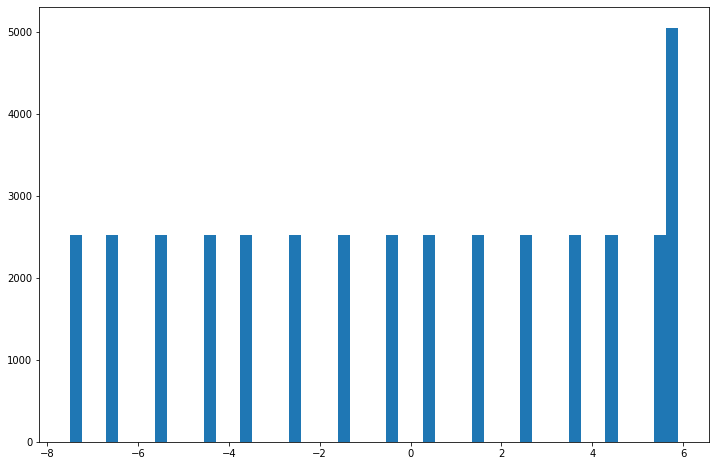

In [62]:
n,bins,patches = plt.hist(df['a1'], bins=50);

In [63]:
n

array([2527.,    0.,    0., 2527.,    0.,    0.,    0., 2527.,    0.,
          0.,    0., 2527.,    0.,    0., 2527.,    0.,    0.,    0.,
       2527.,    0.,    0.,    0., 2527.,    0.,    0.,    0., 2527.,
          0.,    0., 2527.,    0.,    0.,    0., 2527.,    0.,    0.,
          0., 2527.,    0.,    0.,    0., 2527.,    0.,    0., 2527.,
          0.,    0.,    0., 2527., 5054.])

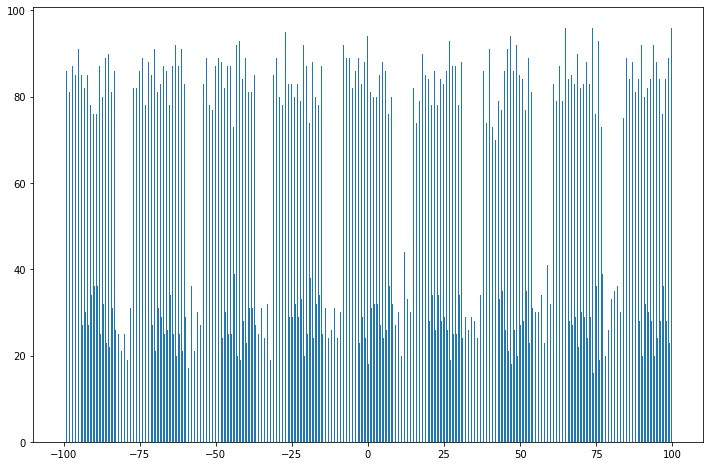

In [64]:
n, bins, patches = plt.hist(df['a2'], bins=np.linspace(-100, 100, 801));

In [65]:
n

array([20.,  0.,  0., 86., 26.,  0.,  0., 81., 31.,  0.,  0., 87., 25.,
        0.,  0., 85., 27.,  0.,  0., 91., 21.,  0.,  0., 85., 27.,  0.,
        0., 82., 30.,  0.,  0., 85., 27.,  0.,  0., 78., 34.,  0.,  0.,
       76., 36.,  0.,  0., 76., 36.,  0.,  0., 87., 25.,  0.,  0., 80.,
       32.,  0.,  0., 89., 23.,  0.,  0., 90., 22.,  0.,  0., 81., 31.,
        0.,  0., 86., 26.,  0.,  0., 87., 25.,  0.,  0., 91., 21.,  0.,
        0., 87., 25.,  0.,  0., 93., 19.,  0.,  0., 81., 31.,  0.,  0.,
       82., 30.,  0.,  0., 82., 30.,  0.,  0., 86., 26.,  0.,  0., 89.,
       23.,  0.,  0., 78., 34.,  0.,  0., 88., 24.,  0.,  0., 85., 27.,
        0.,  0., 91., 21.,  0.,  0., 81., 31.,  0.,  0., 83., 29.,  0.,
        0., 87., 25.,  0.,  0., 86., 26.,  0.,  0., 78., 34.,  0.,  0.,
       87., 25.,  0.,  0., 92., 20.,  0.,  0., 87., 25.,  0.,  0., 91.,
       21.,  0.,  0., 83., 29.,  0.,  0., 95., 17.,  0.,  0., 76., 36.,
        0.,  0., 91., 21.,  0.,  0., 82., 30.,  0.,  0., 85., 27

In [66]:
# usable grid, 1 degree per step
17 * 180

3060

In [67]:
len(df)

40432

In [68]:
# time for collection
df.index[-1] - df.index[0]

Timedelta('3 days 22:31:45')

In [69]:
(df.index[-1] - df.index[0])*2

Timedelta('7 days 21:03:30')

### Gen Plots

In [70]:
df.columns

Index(['Time', 'Magnet Current [V]', 'Magnet Voltage [V]', 'NMR [T]',
       'NMR [FFT]', 'DF0000000D5E803A_Raw_X', 'DF0000000D5E803A_Raw_Y',
       'DF0000000D5E803A_Raw_Z', 'C90000000D53983A_Raw_X',
       'C90000000D53983A_Raw_Y', 'C90000000D53983A_Raw_Z',
       'C50000000D5E473A_Raw_X', 'C50000000D5E473A_Raw_Y',
       'C50000000D5E473A_Raw_Z', '6A0000000D61333A_Raw_X',
       '6A0000000D61333A_Raw_Y', '6A0000000D61333A_Raw_Z',
       'DF0000000D5E803A_Raw_T', 'C90000000D53983A_Raw_T',
       'C50000000D5E473A_Raw_T', '6A0000000D61333A_Raw_T',
       'DF0000000D5E803A_Cal_X', 'DF0000000D5E803A_Cal_Y',
       'DF0000000D5E803A_Cal_Z', 'C90000000D53983A_Cal_X',
       'C90000000D53983A_Cal_Y', 'C90000000D53983A_Cal_Z',
       'C50000000D5E473A_Cal_X', 'C50000000D5E473A_Cal_Y',
       'C50000000D5E473A_Cal_Z', '6A0000000D61333A_Cal_X',
       '6A0000000D61333A_Cal_Y', '6A0000000D61333A_Cal_Z',
       'DF0000000D5E803A_Cal_T', 'C90000000D53983A_Cal_T',
       'C50000000D5E473A_Cal_T',

In [71]:
df_slow.columns

Index(['Time', 'Magnet Current [A]', 'Magnet Voltage [V]', 'Coil 1 (new)',
       'Coil 2 (old)', 'LCW in Coil1', 'LCW out Coil 1', 'LCW in Coil 2',
       'LCW out Coil 2', 'Yoke', 'Hall Element', 'Floor', 'Roof',
       'Yoke (center magnet)', 'Parameter HVAC sensor', 'Chamber Wall CH13',
       'Chamber Wall CH14', 'Chamber Wall CH15', 'Chamber Wall CH16',
       'Chamber Wall CH17', 'Chamber Wall CH18', 'Chamber Wall CH19',
       'Chamber Wall CH20', 'Desk Ambient', 'Outlet Strip Ambient',
       'Top fo Orange PS Ambient', 'Spare Ambient on desk',
       'TrippLite Ambient 3ft high', 'TrippLite Ambient Floor', 'PS internal',
       'PS Vent1', 'PS Vent2', 'TrippLite HVAC supply',
       'Tripplite HVAC exhaust', 'LCW to PS', 'LCW in barrel', 'ICW in',
       'ICW HE1 out', 'ICW He2 out', 'LCW return magnet', 'LCW to barrel',
       'LCW from PS', 'LCW to magnet', 'NMR [T]', 'NMR [FFT]',
       'DF0000000D5E803A_Raw_X', 'DF0000000D5E803A_Raw_Y',
       'DF0000000D5E803A_Raw_Z', 'C

In [72]:
fig = scatter2d(df['Time'], df[f'{probe}_Cal_Bmag'], inline=False)

In [77]:
fig = scatter2d([df.index, df_slow.index], [df[f'{probe}_Cal_T'], df_slow['Yoke (center magnet)']], inline=False)

In [78]:
#A = -1.17e-4; B = -4.56e-6; C = 5.41e-5; D = 4.88e-3 # run 4
A = -1.74e-4; B = 3.31e-5; C = 1.80e-5; D = 4.89e-3 # run 4
#A = -0.0029268763848858408; B = 0.013243568267699473; C = 0.0003895715589591735; D = 0.004545002811220435;  E = 0 # 2020-06-18 dataset
#A = -2.8179770776172955e-05; B = 2.2378990800837796e-05; C = -1.85176005428013e-06; D = 0.0054590623375972225; E = 0 # 2020-06-26 dataset
df_slow['B_calc'] = A * df_slow['Yoke (center magnet)'] + B * df_slow['Floor'] + C * df_slow['LCW in Coil 2'] + D * df_slow['Magnet Current [A]'] #+ E

In [628]:
#A = 0.0051634366068391635; B = 1.4917265577893455;
A = 0.005451740619843297; B = 0.028162518418453145;
df_slow['B_calc'] = A * df_slow['Magnet Current [A]'] + B * 1/df_slow['Magnet Voltage [V]']

In [79]:
df_slow['B_calc2'] = df_slow['B_calc'] + (df[f'{probe}_Cal_Bmag'].mean() - df_slow['B_calc'].mean())

In [80]:
fig = scatter2d([df.index, df_slow.index], [df[f'{probe}_Cal_Bmag'], df_slow['B_calc']], inline=False)

In [81]:
fig = scatter2d([df.index, df_slow.index], [df[f'{probe}_Cal_Bmag'], df_slow['B_calc2']], inline=False)

In [82]:
# interpolate slow results to Hall

In [92]:
df.index[0], df_slow.index[0]

(Timestamp('2020-09-30 15:48:35'), Timestamp('2020-09-30 15:47:07'))

In [93]:
df["seconds_delta"] = (df.index - df.index[0]).total_seconds()
df_slow["seconds_delta"] = (df_slow.index - df.index[0]).total_seconds()

In [94]:
df_slow.seconds_delta

Datetime
2020-09-30 15:47:07       -88.0
2020-09-30 15:56:14       459.0
2020-09-30 16:04:02       927.0
2020-09-30 16:11:50      1395.0
2020-09-30 16:18:43      1808.0
                         ...   
2020-10-04 13:49:01    338426.0
2020-10-04 13:56:51    338896.0
2020-10-04 14:03:45    339310.0
2020-10-04 14:11:35    339780.0
2020-10-04 14:19:25    340250.0
Name: seconds_delta, Length: 757, dtype: float64

In [95]:
df.seconds_delta

Datetime
2020-09-30 15:48:35         0.0
2020-09-30 15:48:42         7.0
2020-09-30 15:48:50        15.0
2020-09-30 15:48:58        23.0
2020-09-30 15:49:06        31.0
                         ...   
2020-10-04 14:19:48    340273.0
2020-10-04 14:19:56    340281.0
2020-10-04 14:20:04    340289.0
2020-10-04 14:20:12    340297.0
2020-10-04 14:20:20    340305.0
Name: seconds_delta, Length: 40432, dtype: float64

In [103]:
interp_func = interp1d(df_slow.seconds_delta.values, df_slow.B_calc2.values, fill_value='extrapolate')

In [106]:
df['B_calc2'] = interp_func(df.seconds_delta.values)

In [107]:
df['dB'] = df[f'{probe}_Cal_Bmag'] - df['B_calc2']

In [108]:
fig = scatter2d([df.index, df_slow.index], [df[f'{probe}_Cal_Bmag'], df_slow['B_calc2']], inline=False)

In [110]:
fig = scatter2d(df.index, df['dB'], inline=False)

In [112]:
fig = histo([df[f'{probe}_Cal_Bmag']-df[f'{probe}_Cal_Bmag'].mean(), df['dB']], bins=100, inline=False)

In [113]:
fig = histo([df[f'{probe}_Cal_Bmag']-df[f'{probe}_Cal_Bmag'].mean(), df['dB']], bins=100, yscale='log', inline=False)

In [114]:
fig = scatter2d([df.index, df.index, df_slow.index], [df[f'{probe}_Cal_Bmag'],df[f'{probe}_Cal_Bmag'].rolling(25).mean(), df_slow['B_calc2']], inline=False)

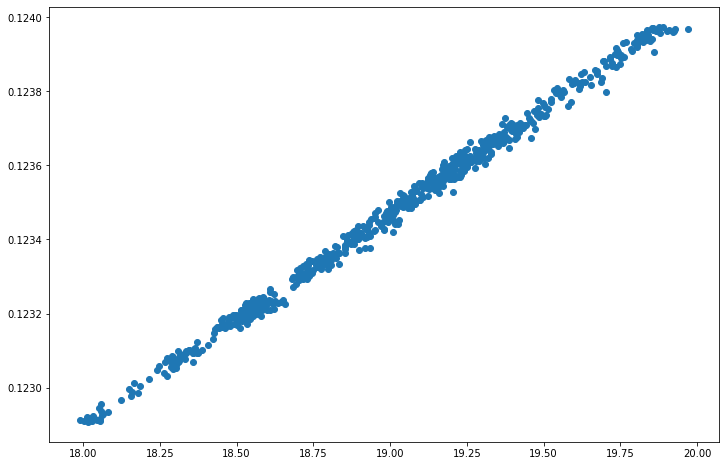

In [117]:
#plt.scatter(df_slow['Yoke (center magnet)'],df_slow['Magnet Voltage [V]'] / df_slow['Magnet Current [A]'])
plt.scatter(df_slow['LCW in Coil 2'],df_slow['Magnet Voltage [V]'] / df_slow['Magnet Current [A]'])

In [118]:
df['Magnet Current [V]'].values, df_slow['Magnet Current [A]'].values

(array([240.06754   , 240.06754   , 240.06754   , ..., 240.06912667,
        240.06901333, 240.06907   ]),
 array([240.06754   , 240.06754   , 240.06754   , 240.06754   ,
        240.06754   , 240.06759667, 240.06759667, 240.06765333,
        240.06754   , 240.06788   , 240.06759667, 240.06776667,
        240.06759667, 240.06759667, 240.06754   , 240.06754   ,
        240.06754   , 240.06765333, 240.06754   , 240.06754   ,
        240.06754   , 240.06765333, 240.06759667, 240.06754   ,
        240.06759667, 240.06765333, 240.06771   , 240.06754   ,
        240.06771   , 240.06765333, 240.06771   , 240.06754   ,
        240.06759667, 240.06759667, 240.06759667, 240.06754   ,
        240.06771   , 240.06776667, 240.06788   , 240.06776667,
        240.06788   , 240.06788   , 240.06754   , 240.06788   ,
        240.06765333, 240.06782333, 240.06771   , 240.06782333,
        240.06776667, 240.06782333, 240.06788   , 240.06782333,
        240.06771   , 240.06788   , 240.06788   , 240.0678233

In [77]:
fig = scatter2d(4*[df['Time']], [df[f'{probes[i]}_Cal_Bmag'] for i in range(4)], inline=False)

In [62]:
fig = scatter2d(df['Time'], df['Magnet Current [V]'], inline=False)

In [79]:
fig = scatter2d(2*[df['Time']], [df[f'{probe}_Cal_Theta'],df[f'{probe}_Cal_Phi']], inline=False)

In [ ]:
fig = scatter2d(2*[df['Time']], [df[f'{probe}_Cal_Theta'],df[f'{probe}_Cal_Phi']], inline=False)

In [80]:
fig = scatter2d(2*[df['Time']], [df['SmarAct_Meas_Angle_1'],df['SmarAct_Meas_Angle_2']], inline=False)

In [69]:
fig = scatter2d(3*[df['Time']], [df[f'{probe}_Cal_{i}'] for i in ['X','Y','Z']], inline=False)

In [70]:
fig = scatter2d(3*[df['Time']], [df[f'{probe}_Raw_{i}'] for i in ['X','Y','Z']], inline=False)

In [71]:
fig = scatter2d(2*[df['Time']], [df[f'{probe}_Cal_Bmag'], df[f'{probe}_Cal_T']], inline=False)

In [119]:
df[[f'{probe}_Cal_Bmag',f'{probe}_Cal_T']].corr()

,6A0000000D61333A_Cal_Bmag,6A0000000D61333A_Cal_T
6A0000000D61333A_Cal_Bmag,1.000000,0.306287
6A0000000D61333A_Cal_T,0.306287,1.000000


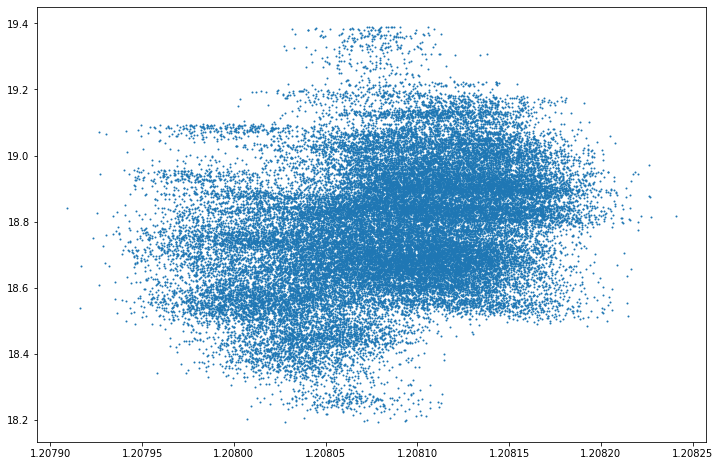

In [120]:
plt.scatter(df[f'{probe}_Cal_Bmag'], df[f'{probe}_Cal_T'], s=1)

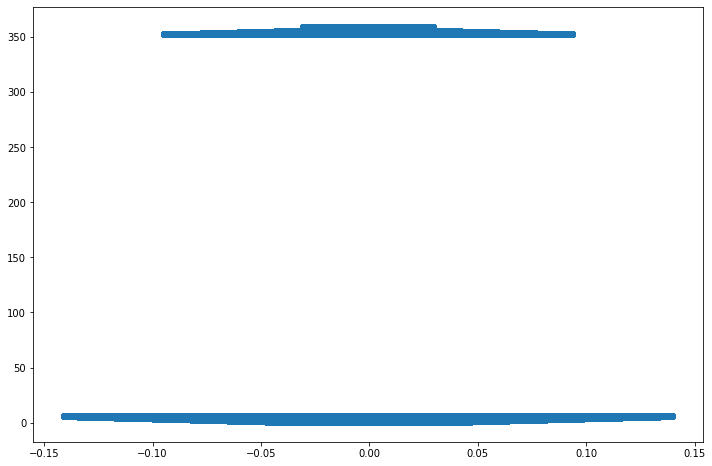

In [121]:
fig = plt.figure()
plt.scatter(df[f'{probe}_Cal_Phi'], df['SmarAct_Meas_Angle_1'])

In [122]:
df['SmarAct_Meas_Angle_2_pm'] = [i if i <= 180 else i-360 for i in df.SmarAct_Meas_Angle_2]

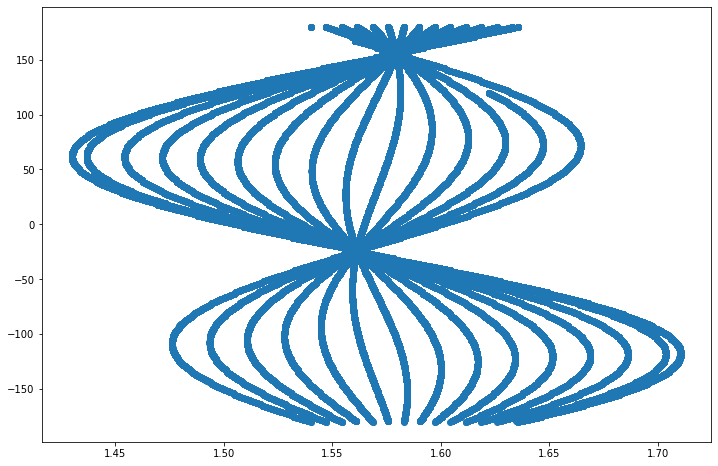

In [123]:
fig = plt.figure()
plt.scatter(df[f'{probe}_Cal_Theta'], df['SmarAct_Meas_Angle_2_pm'])

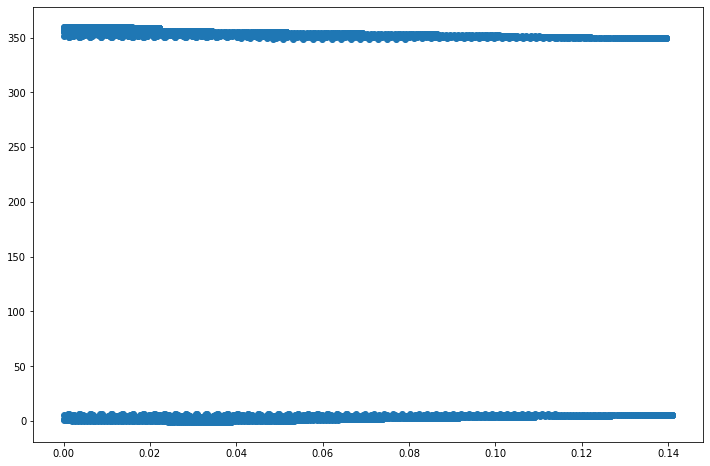

In [81]:
a = 1.00
b = 0.01
fig = plt.figure()
plt.scatter(df[f'{probe}_Cal_Phi'], a*df['SmarAct_Meas_Angle_1']+b*df['SmarAct_Meas_Angle_2_pm'])

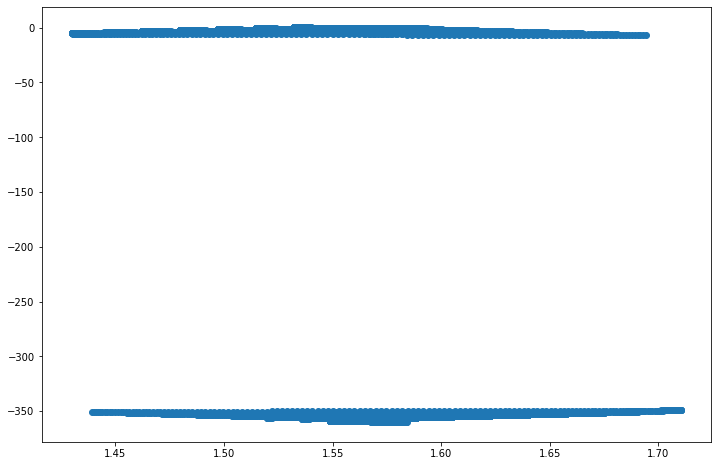

In [82]:
a = -1
b = .01
fig = plt.figure()
plt.scatter(df[f'{probe}_Cal_Theta'], a*df['SmarAct_Meas_Angle_1']+b*df['SmarAct_Meas_Angle_2_pm'])

## Fitting to find angular relationships (Regression)

### Test 1: Fit individually

In [83]:
df[f'{probe}_Cal_Theta_Deg'] = np.degrees(df[f'{probe}_Cal_Theta'])
df[f'{probe}_Cal_Phi_Deg'] = np.degrees(df[f'{probe}_Cal_Phi'])

In [84]:
def regress_2angle(angle1, angle2, **params):
    return params['m1'] * angle1 + params['m2'] * angle2 + params['b']

In [85]:
model = lm.Model(regress_2angle, independent_vars=['angle1','angle2'])
params = lm.Parameters()
params.add('m1', value=0, vary=True)
params.add('m2', value=0, vary=True)
params.add('b', value=0, vary=True)

In [86]:
#samples = np.concatenate([df['SmarAct_Meas_Angle_1'].values,df['SmarAct_Meas_Angle_2'].values])
result_theta = model.fit(df[f'{probe}_Cal_Theta_Deg'], angle1=df['SmarAct_Meas_Angle_1'],
                         angle2=df['SmarAct_Meas_Angle_2'], params=params)
result_phi = model.fit(df[f'{probe}_Cal_Phi_Deg'], angle1=df['SmarAct_Meas_Angle_1'],
                         angle2=df['SmarAct_Meas_Angle_2'], params=params)

In [87]:
result_theta.params

name,value,standard error,relative error,initial value,min,max,vary
m1,0.00628010,3.4854e-04,(5.55%),0,-inf,inf,True
m2,-5.5078e-04,4.3922e-04,(79.74%),0,-inf,inf,True
b,88.4267444,0.12340270,(0.14%),0,-inf,inf,True


In [88]:
result_phi.params

name,value,standard error,relative error,initial value,min,max,vary
m1,-0.00271042,2.0497e-04,(7.56%),0,-inf,inf,True
m2,0.00582752,2.5830e-04,(4.43%),0,-inf,inf,True
b,2.28772634,0.07257198,(3.17%),0,-inf,inf,True


In [89]:
print(result_theta.fit_report())

[[Model]]
    Model(regress_2angle)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 3060
    # variables        = 3
    chi-square         = 33997.9940
    reduced chi-square = 11.1213589
    Akaike info crit   = 7374.13302
    Bayesian info crit = 7392.21153
[[Variables]]
    m1:  0.00628010 +/- 3.4854e-04 (5.55%) (init = 0)
    m2: -5.5078e-04 +/- 4.3922e-04 (79.74%) (init = 0)
    b:   88.4267444 +/- 0.12340270 (0.14%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m2, b) = -0.641
    C(m1, b) = -0.592


In [90]:
print(result_phi.fit_report())

[[Model]]
    Model(regress_2angle)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 12
    # data points      = 3060
    # variables        = 3
    chi-square         = 11758.2279
    reduced chi-square = 3.84632905
    Akaike info crit   = 4125.18328
    Bayesian info crit = 4143.26179
[[Variables]]
    m1: -0.00271042 +/- 2.0497e-04 (7.56%) (init = 0)
    m2:  0.00582752 +/- 2.5830e-04 (4.43%) (init = 0)
    b:   2.28772634 +/- 0.07257198 (3.17%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m2, b) = -0.641
    C(m1, b) = -0.592


In [91]:
regress_2angle(0, 0, **result_phi.params)

2.2877263434126736

In [92]:
a1s = np.linspace(0, 180, 181)
a2s = np.linspace(0, 360, 361)

In [93]:
A1, A2 = np.meshgrid(a1s, a2s)

In [94]:
TH = regress_2angle(A1, A2, **result_theta.params)
PH = regress_2angle(A1, A2, **result_phi.params)

In [95]:
TH.min(), TH.max(), PH.min(), PH.max()

(88.22846182295689, 89.55716319430637, 1.799851020451837, 4.385633371345854)

In [96]:
TH.max()-TH.min(), PH.max()-PH.min()

(1.3287013713494815, 2.585782350894017)

-----------

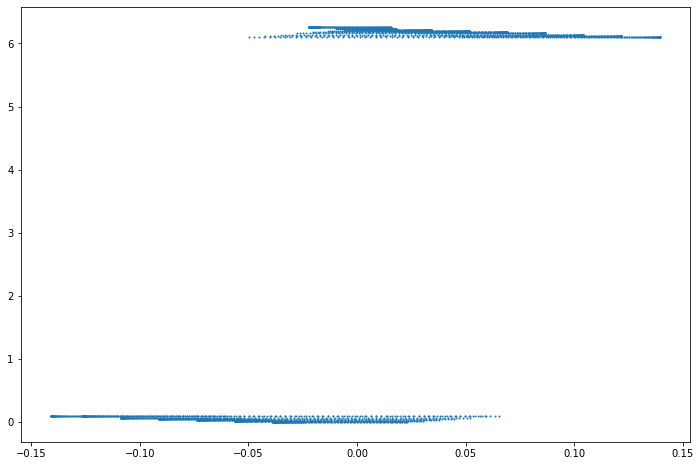

In [524]:
plt.scatter(df[f'{probe}_Cal_Phi'],df['SmarAct_Meas_Angle_1_Rad'], s=1)

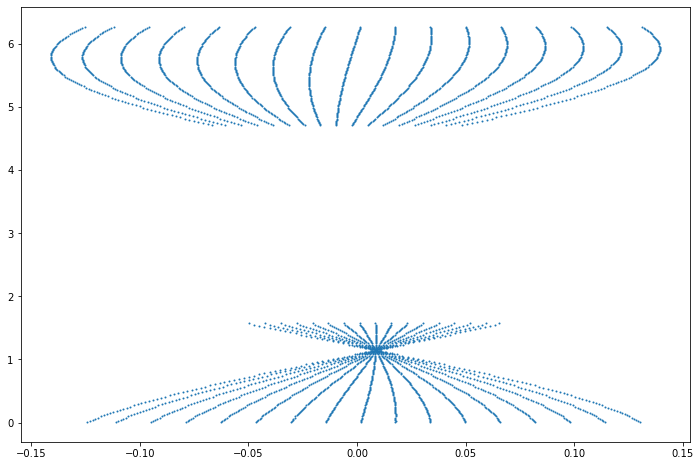

In [525]:
plt.scatter(df[f'{probe}_Cal_Phi'],df['SmarAct_Meas_Angle_2_Rad'], s=1)

In [527]:
np.arccos()

1.5707963267948966

### Test 2: Euler Angles

In [124]:
from scipy.spatial.transform import Rotation

In [1412]:
#df['Bz_cal'] = df[f'{probe}_Cal_X']
#df['Bx_cal'] = df[f'{probe}_Cal_Z']
#df['By_cal'] = -df[f'{probe}_Cal_Y']
###
df['Bz_cal'] = df[f'{probe}_Cal_X']
df['Bx_cal'] = df[f'{probe}_Cal_Y']
df['By_cal'] = df[f'{probe}_Cal_Z']
#df['Bz_cal'] = df[f'{probe}_Cal_X'] / df[f'{probe}_Cal_Bmag']
#df['Bx_cal'] = df[f'{probe}_Cal_Y'] / df[f'{probe}_Cal_Bmag']
#df['By_cal'] = df[f'{probe}_Cal_Z'] / df[f'{probe}_Cal_Bmag']

df.eval('Bmag_cal = (Bx_cal**2 + By_cal**2 + Bz_cal**2)**(1/2)', inplace=True)

In [1413]:
df['B_T_cal'] = (df["Bx_cal"]**2+df["By_cal"]**2)**(1/2)
df["B_Theta_cal"] = np.arctan2(df["B_T_cal"],df["Bz_cal"])#/df[f"{probe}_{t}_Bmag"])
df["B_Phi_cal"] = np.arctan2(df["By_cal"],df["Bx_cal"])
### TEST
#df["B_Phi_cal"] = df["B_Phi_cal"] + (df["B_Phi_cal"] < 0) * (2*np.pi)

In [1394]:
df[f'{probe}_Cal_Theta_Deg'] = np.degrees(df[f'{probe}_Cal_Theta'])
df[f'{probe}_Cal_Phi_Deg'] = np.degrees(df[f'{probe}_Cal_Phi'])
df['SmarAct_Meas_Angle_1_Rad'] = np.radians(df['SmarAct_Meas_Angle_1'])
df['SmarAct_Meas_Angle_2_Rad'] = np.radians(df['SmarAct_Meas_Angle_2'])
df['SmarAct_Meas_Angle_1_Rad_pm'] =  df['SmarAct_Meas_Angle_1_Rad'] - (df['SmarAct_Meas_Angle_1_Rad'] > np.pi) * 2 * np.pi
#df['SmarAct_Meas_Angle_1_Rad_pm'] =  df['SmarAct_Meas_Angle_1_Rad'] - (df['SmarAct_Meas_Angle_1_Rad'] > np.pi) * np.pi
df['SmarAct_Meas_Angle_2_Rad_pm'] = df['SmarAct_Meas_Angle_2_Rad'] - (df['SmarAct_Meas_Angle_2_Rad'] > np.pi) * 2 * np.pi

In [142]:
def smaract_to_Bangle(angle1, angle2, **params):
    # 3 euler angles
    sign_cos = np.sign(angle1)
    z = np.cos(angle1)
    x = sign_cos*np.sin(angle1)*np.cos(angle2)
    y = sign_cos*np.sin(angle1)*np.sin(angle2)
    pos = np.array([x,y,z]).reshape(3, -1).T
    #print(pos.shape)
    rot = Rotation.from_euler('XYZ', np.array([params['e1'],params['e2'],params['e3']]))
    #rot = Rotation.from_euler('xyz', np.array([params['e1'],params['e2'],params['e3']]))
    pos_rot = rot.apply(pos)
    #print(pos_rot.shape)
    #print((pos == pos_rot).all())
    ##theta = sign_cos * np.arccos(pos_rot[:,2], np.linalg.norm(pos_rot, axis=1))
    ##phi = np.arctan2(sign_cos*pos_rot[:,1], sign_cos*pos_rot[:,0])
    theta = np.arccos(pos_rot[:,2]/np.linalg.norm(pos_rot, axis=1))
    phi = np.arctan2(pos_rot[:,1], pos_rot[:,0])
    #phi = np.arctan2(pos_rot[:,1], pos_rot[:,0])
    return np.concatenate([theta, phi])

In [303]:
def smaract_to_Bangle_v2(angle1, angle2, **params):
    # 3 euler angles
    #sign_cos = np.sign(angle1)
    z = np.cos(angle1)
    #x = sign_cos*np.sin(angle1)*np.cos(angle2)
    #y = sign_cos*np.sin(angle1)*np.sin(angle2)
    x = np.sin(angle1)*np.cos(angle2)
    y = np.sin(angle1)*np.sin(angle2)
    pos = np.array([x,y,z]).reshape(3, -1).T
    #print(pos.shape)
    #rot = Rotation.from_euler('XYZ', np.array([params['e1'],params['e2'],params['e3']]))
    rot = Rotation.from_euler('xyz', np.array([params['e1'],params['e2'],params['e3']]))
    pos_rot = rot.apply(pos)
    #print(pos_rot.shape)
    #print((pos == pos_rot).all())
    ##theta = sign_cos * np.arccos(pos_rot[:,2], np.linalg.norm(pos_rot, axis=1))
    ##phi = np.arctan2(sign_cos*pos_rot[:,1], sign_cos*pos_rot[:,0])
    theta = np.arccos(pos_rot[:,2]/np.linalg.norm(pos_rot, axis=1))
    #theta = np.arctan2(np.linalg.norm(pos[:,:2],axis=1), pos[:,2]) #, np.linalg.norm(pos_rot, axis=1))
    phi = np.arctan2(pos_rot[:,1], pos_rot[:,0])
    #phi = np.arctan2(pos_rot[:,1], pos_rot[:,0])
    return np.concatenate([theta, phi])

In [474]:
def smaract_to_Bangle_v3(angle1, angle2, **params):
    # 3 euler angles
    #sign_cos = np.sign(angle1)
    z = np.cos(angle1)
    #x = sign_cos*np.sin(angle1)*np.cos(angle2)
    #y = sign_cos*np.sin(angle1)*np.sin(angle2)
    x = np.sin(angle1)*np.cos(angle2)
    y = np.sin(angle1)*np.sin(angle2)
    pos = np.array([x,y,z]).reshape(3, -1).T
    #print(pos.shape)
    rot = Rotation.from_euler('XYZ', np.array([params['e1'],params['e2'],params['e3']]))
    #rot = Rotation.from_euler('XY', np.array([params['e1'],params['e2']]))
    #rot = Rotation.from_euler('xyz', np.array([params['e1'],params['e2'],params['e3']]))
    pos_rot = rot.apply(pos)
    #print(pos_rot.shape)
    #print((pos == pos_rot).all())
    ##theta = sign_cos * np.arccos(pos_rot[:,2], np.linalg.norm(pos_rot, axis=1))
    ##phi = np.arctan2(sign_cos*pos_rot[:,1], sign_cos*pos_rot[:,0])
    theta = np.arccos(pos_rot[:,2]/np.linalg.norm(pos_rot, axis=1))
    #theta = np.arctan2(np.linalg.norm(pos[:,:2],axis=1), pos[:,2]) #, np.linalg.norm(pos_rot, axis=1))
    phi = np.arctan2(pos_rot[:,1], pos_rot[:,0])
    #phi = np.arctan2(pos_rot[:,1], pos_rot[:,0])
    return np.concatenate([theta, phi])

In [397]:
#def smaract_to_Bangle_v3(angle1, angle2, **params):
#    theta = angle1 + params['e1']
#    phi = angle2 + params['e2']
#    return np.concatenate([theta, phi])

In [145]:
def smaract_to_Bangle_v4(angle1, angle2, **params):
    theta = np.abs(angle1+params['e1'])
    phi = angle2 + params['e2'] + ((angle1+params['e1'])<0) * np.pi
    #phi = angle2 + params['e2'] + (angle1<0) * np.pi
    #phi =  phi - (phi > np.pi) * 2 * np.pi
    return np.concatenate([theta, phi])

In [211]:
def reco_Bvec(angle1, angle2, B, **params):
    theta = angle1 + params['e1']
    phi = angle2 + params['e2']
    Bx = B * np.sin(theta) * np.cos(phi)
    By = B * np.sin(theta) * np.sin(phi)
    Bz = B * np.cos(theta)
    return np.concatenate([Bx, By, Bz])

In [310]:
def reco_Bvec_Euler(angle1, angle2, B, **params):
    theta = angle1 + params['off_th']
    phi = angle2 + params['off_ph']
    theta, phi = smaract_to_Bangle_v2(theta, phi, **params).reshape(2, -1)
    #theta, phi = smaract_to_Bangle_v2(angle1, angle2, **params).reshape(2, -1)
    #theta = theta + params['off_th']
    #phi = phi + params['off_ph']
    Bx = B * np.sin(theta) * np.cos(phi)
    By = B * np.sin(theta) * np.sin(phi)
    Bz = B * np.cos(theta)
    return np.concatenate([Bx, By, Bz])

In [328]:
def reco_Bvec_v2(angle1, angle2, B, **params):
    c11 = (1 - params['c10'])
    c21 = (1 - params['c20'])
    theta = params['c10'] * angle1 + params['c20'] * angle2 + params['e1']
    phi = c11 * angle1 + c21 * angle2 + params['e2']
    #phi = params['c11'] * angle1 + params['c21'] * angle2 + params['e2']
    Bx = B * np.sin(theta) * np.cos(phi)
    By = B * np.sin(theta) * np.sin(phi)
    Bz = B * np.cos(theta)
    return np.concatenate([Bx, By, Bz])

In [473]:
def reco_Bvec_Euler_v3(angle1, angle2, B, **params):
    #theta = angle1 + params['off_th']
    #phi = angle2 + params['off_ph']
    #theta, phi = smaract_to_Bangle_v3(theta, phi, **params).reshape(2, -1)
    theta, phi = smaract_to_Bangle_v3(angle1, angle2, **params).reshape(2, -1)
    theta = theta + params['off_th']
    phi = phi + params['off_ph']
    Bx = B * np.sin(theta) * np.cos(phi)
    By = B * np.sin(theta) * np.sin(phi)
    Bz = B * np.cos(theta)
    return np.concatenate([Bx, By, Bz])

In [ ]:
def reco_Bvec_v3(angle1, angle2, B, **params):
    # get into smaract coordinates
    theta = angle1 + params['e1']
    phi = angle2 + params['e2']
    Bx = B * np.sin(theta) * np.cos(phi)
    By = B * np.sin(theta) * np.sin(phi)
    Bz = B * np.cos(theta)
    # go to Hall probe coordinates
    t_ = params['e3']
    p_ = params['e4']
    
    return np.concatenate([Bx, By, Bz])

In [778]:
def reco_Bvec_EulerB(angle1, angle2, B, **params):
    # get into smaract coordinates
    theta = angle1 + params['off_th']
    phi = angle2 + params['off_ph']
    Bx = B * np.sin(theta) * np.cos(phi)
    By = B * np.sin(theta) * np.sin(phi)
    Bz = B * np.cos(theta)
    B_vec_Smar = np.array([Bx, By, Bz]).T
    # rotate to Hall coordinates
    rot = Rotation.from_euler('XYZ', np.array([params['e1'],params['e2'],params['e3']]))
    #rot = Rotation.from_euler('xyz', np.array([params['e1'],params['e2'],params['e3']]))
    B_vec_Hall = rot.apply(B_vec_Smar).T.flatten()
    return B_vec_Hall
    #return np.concatenate([Bx, By, Bz])

In [704]:
def reco_Bvec_v4(angle1, angle2, B, **params):
    theta = params['s1']*angle1 + params['e1']
    phi = params['s2']*angle2 + params['e2']
    Bx = B * np.sin(theta) * np.cos(phi)
    By = B * np.sin(theta) * np.sin(phi)
    Bz = B * np.cos(theta)
    return np.concatenate([Bx, By, Bz])

In [1102]:
def reco_Bz_EulerB(angle1, angle2, B, **params):
    # get into smaract coordinates
    theta = angle1 + params['off_th']
    phi = angle2 + params['off_ph']
    Bx = B * np.sin(theta) * np.cos(phi)
    By = B * np.sin(theta) * np.sin(phi)
    Bz = B * np.cos(theta)
    B_vec_Smar = np.array([Bx, By, Bz]).T
    # rotate to Hall coordinates
    rot = Rotation.from_euler('XYZ', np.array([params['e1'],params['e2'],params['e3']]))
    #rot = Rotation.from_euler('xyz', np.array([params['e1'],params['e2'],params['e3']]))
    #rot = Rotation.from_euler('zxz', np.array([params['e1'],params['e2'],params['e3']]))
    #B_vec_Hall = rot.apply(B_vec_Smar).T.flatten()
    Bz = rot.apply(B_vec_Smar).T[2]
    #return Bz
    return params['s']*Bz
    #return np.concatenate([Bx, By, Bz])

In [944]:
def reco_Bx_EulerB(angle1, angle2, B, **params):
    # get into smaract coordinates
    theta = angle1 + params['off_th']
    phi = angle2 + params['off_ph']
    Bx = B * np.sin(theta) * np.cos(phi)
    By = B * np.sin(theta) * np.sin(phi)
    Bz = B * np.cos(theta)
    B_vec_Smar = np.array([Bx, By, Bz]).T
    # rotate to Hall coordinates
    rot = Rotation.from_euler('XYZ', np.array([params['e1'],params['e2'],params['e3']]))
    #rot = Rotation.from_euler('xyz', np.array([params['e1'],params['e2'],params['e3']]))
    #rot = Rotation.from_euler('zxz', np.array([params['e1'],params['e2'],params['e3']]))
    #B_vec_Hall = rot.apply(B_vec_Smar).T.flatten()
    Bx = rot.apply(B_vec_Smar).T[0]
    #return Bz
    return params['s']*Bx
    #return np.concatenate([Bx, By, Bz])

In [1138]:
def reco_By_EulerB(angle1, angle2, B, **params):
    # get into smaract coordinates
    theta = angle1 + params['off_th']
    phi = angle2 + params['off_ph']
    Bx = B * np.sin(theta) * np.cos(phi)
    By = B * np.sin(theta) * np.sin(phi)
    Bz = B * np.cos(theta)
    B_vec_Smar = np.array([Bx, By, Bz]).T
    # rotate to Hall coordinates
    rot = Rotation.from_euler('XYZ', np.array([params['e1'],params['e2'],params['e3']]))
    #rot = Rotation.from_euler('xyz', np.array([params['e1'],params['e2'],params['e3']]))
    #rot = Rotation.from_euler('zxz', np.array([params['e1'],params['e2'],params['e3']]))
    #B_vec_Hall = rot.apply(B_vec_Smar).T.flatten()
    Bx = rot.apply(B_vec_Smar).T[1]
    #return Bz
    return params['s']*Bx
    #return np.concatenate([Bx, By, Bz])

In [1197]:
def reco_Bz_EulerB_v2(angle1, angle2, B, **params):
    # get into smaract coordinates
    theta = angle1 + params['off_th']
    phi = angle2 + params['off_ph']
    # fix negative theta
    phi = phi + (theta<0) * np.pi
    theta = np.abs(theta)
    Bx = B * np.sin(theta) * np.cos(phi)
    By = B * np.sin(theta) * np.sin(phi)
    Bz = B * np.cos(theta)
    B_vec_Smar = np.array([Bx, By, Bz]).T
    # rotate to Hall coordinates
    rot = Rotation.from_euler('XYZ', np.array([params['e1'],params['e2'],params['e3']]))
    #rot = Rotation.from_euler('xyz', np.array([params['e1'],params['e2'],params['e3']]))
    #rot = Rotation.from_euler('zxz', np.array([params['e1'],params['e2'],params['e3']]))
    #B_vec_Hall = rot.apply(B_vec_Smar).T.flatten()
    Bz = rot.apply(B_vec_Smar).T[2]
    #return Bz
    return params['s']*Bz
    #return np.concatenate([Bx, By, Bz])

In [1293]:
def reco_Bvec_EulerB_v2(angle1, angle2, B, **params):
    # get into smaract coordinates
    theta = angle1 + params['off_th']
    phi = angle2 + params['off_ph']
    # fix negative theta
    phi = phi + (theta<0) * np.pi
    theta = np.abs(theta)
    Bx = B * np.sin(theta) * np.cos(phi)
    By = B * np.sin(theta) * np.sin(phi)
    Bz = B * np.cos(theta)
    B_vec_Smar = np.array([Bx, By, Bz]).T
    # rotate to Hall coordinates
    rot = Rotation.from_euler('XYZ', np.array([params['e1'],params['e2'],params['e3']]))
    #rot = Rotation.from_euler('xyz', np.array([params['e1'],params['e2'],params['e3']]))
    B_vec_Hall = rot.apply(B_vec_Smar).T.flatten()
    return params['s'] * B_vec_Hall
    #return np.concatenate([Bx, By, Bz])

In [1832]:
def reco_Bvec_EulerB_v3(angle1, angle2, B, **params):
    # get into smaract coordinates
    theta = params['scale_th']*(angle1 + params['off_th'])
    phi = params['scale_ph']*(angle2 + params['off_ph'])
    # fix negative theta
    ##phi = phi + (theta<0) * np.pi
    ##theta = np.abs(theta)
    Bx = B * np.sin(theta) * np.cos(phi)
    By = B * np.sin(theta) * np.sin(phi)
    Bz = B * np.cos(theta)
    B_vec_Smar = np.array([Bx, By, Bz]).T
    # rotate to Hall coordinates
    #rot = Rotation.from_euler('XYZ', np.array([params['e1'],params['e2'],params['e3']]))
    #inv_rot = rot.inv()
    rot = Rotation.from_euler('xyz', np.array([params['e1'],params['e2'],params['e3']]))
    #rot = Rotation.from_euler('yxz', np.array([params['e1'],params['e2'],params['e3']]))
    #
    B_vec_Hall = rot.apply(B_vec_Smar).T.flatten()
    #B_vec_Hall = inv_rot.apply(B_vec_Smar).T.flatten()
    return params['s'] * B_vec_Hall
    #return np.concatenate([Bx, By, Bz])

In [2432]:
def reco_Bvec_EulerB_v4(angle1, angle2, B, **params):
    # get into smaract coordinates
    ##theta = params['scale_th']*(angle1 + params['off_th']) + params['scale_ph']*(angle2 + params['off_ph'])
    ##phi = (1-params['scale_th'])*(angle1 + params['off_th']) + (1-params['scale_ph'])*(angle2 + params['off_ph'])
    #theta = params['scale_th']*(angle1 + params['off_th']) + (1-params['scale_th'])*(angle2 + params['off_ph'])
    #phi = (1-params['scale_th'])*(angle1 + params['off_th']) + (params['scale_th'])*(angle2 + params['off_ph'])
    theta = params['scale_th']*(angle1 + params['off_th'])
    phi = params['scale_ph']*(angle2 + params['off_ph'])
    # fix negative theta
    ##phi = phi + (theta<0) * np.pi
    ##theta = np.abs(theta)
    Bx = B * (np.sin(theta) - params['f_phi'] * np.cos(phi)) * np.cos(phi)
    By = B * (np.sin(theta) - params['f_phi'] * np.cos(phi)) * np.sin(phi)
    Bz = B * (np.cos(theta) + params['f_phi'] * np.cos(phi))
    #Bx = (B * np.sin(theta) - params['f_phi'] * np.cos(phi)) * np.cos(phi)
    #By = (B * np.sin(theta) - params['f_phi'] * np.cos(phi)) * np.sin(phi)
    #Bz = B * (np.cos(theta)) + (params['f_phi'] * np.cos(phi))
    
    ##
    #Bz = B * (np.cos(theta)) + params['f_phi']*np.cos(phi)
    #BT = B * (np.sin(theta)) + params['f_phi']*np.cos(phi)
    
    B_vec_Smar = np.array([Bx, By, Bz]).T
    # rotate to Hall coordinates
    #rot = Rotation.from_euler('XYZ', np.array([params['e1'],params['e2'],params['e3']]))
    #inv_rot = rot.inv()
    #rot = Rotation.from_euler('xyz', np.array([params['e1'],params['e2'],params['e3']]))
    rot = Rotation.from_euler('zyx', np.array([params['e1'],params['e2'],params['e3']][::-1]))
    #rot = Rotation.from_euler('yxz', np.array([params['e1'],params['e2'],params['e3']]))
    #
    B_vec_Hall = rot.apply(B_vec_Smar).T.flatten()
    #B_vec_Hall = inv_rot.apply(B_vec_Smar).T.flatten()
    return params['s'] * B_vec_Hall
    #return np.concatenate([Bx, By, Bz])

In [1778]:
B = reco_Bvec_EulerB_v4(df_['SmarAct_Meas_Angle_1_Rad'], df_['SmarAct_Meas_Angle_2_Rad'], df_['Bmag_cal'], **result.params)

In [1780]:
B.shape

(3, 40432)

In [1707]:
fit_coord = 'z'

In [2433]:
df_ = df
#df_ = df[df['SmarAct_Meas_Angle_1_Rad_pm'] > 0]
###df_ = df[(df['SmarAct_Meas_Angle_1_Rad_pm'] > 0) & (df.index < '10-04-2020 02:30:32')]
#df_ = df[(df.index > '10-01-2020 20:00:00') & (df.index < '10-02-2020 09:30:00')]
#df_ = df[(df.index > '10-01-2020 16:00:00') & (df.index < '10-02-2020 12:30:00')]

In [2434]:
len(df_)

40432

In [2435]:
#th = 0.03762239
#th = 2*np.pi-df_['SmarAct_Meas_Angle_1_Rad'].mean()
#th = 2*np.pi - 6.25
#ph = 1.05821414
th = 0 # 0.03762474  # 0 #0.03762474 # 0
ph = 0 #2.62900297  # 0 #2.62900297-np.pi  # 0

In [2436]:
#model = lm.Model(smaract_to_Bangle, independent_vars=['angle1','angle2'])
#model = lm.Model(smaract_to_Bangle_v3, independent_vars=['angle1','angle2'])
#model = lm.Model(smaract_to_Bangle_v4, independent_vars=['angle1','angle2'])
###model = lm.Model(reco_Bvec_Euler_v3, independent_vars=['angle1','angle2', 'B'])
#model = lm.Model(reco_Bvec, independent_vars=['angle1','angle2', 'B'])

#model = lm.Model(reco_Bvec_EulerB, independent_vars=['angle1','angle2', 'B'])
##model = lm.Model(reco_Bvec_EulerB_v2, independent_vars=['angle1','angle2', 'B'])
##model = lm.Model(reco_Bvec_EulerB_v3, independent_vars=['angle1','angle2', 'B'])
model = lm.Model(reco_Bvec_EulerB_v4, independent_vars=['angle1','angle2', 'B'])
#model = lm.Model(reco_Bz_EulerB, independent_vars=['angle1','angle2', 'B'])
#model = lm.Model(reco_Bz_EulerB_v2, independent_vars=['angle1','angle2', 'B'])
#model = lm.Model(reco_Bx_EulerB, independent_vars=['angle1','angle2', 'B'])
#model = lm.Model(reco_By_EulerB, independent_vars=['angle1','angle2', 'B'])

###model = lm.Model(reco_Bvec_v4, independent_vars=['angle1','angle2', 'B'])
params = lm.Parameters()
#params.add('e1', value=np.pi/2, vary=True, min=-np.pi, max=np.pi)
params.add('e1', value=0, vary=True, min=-np.pi, max=np.pi)
params.add('e2', value=0, vary=True, min=-np.pi, max=np.pi)
params.add('e3', value=0, vary=True, min=-np.pi, max=np.pi)
#params.add('s1', value=1, vary=True, min=1-1e-3, max=1+1e-3)
#params.add('s2', value=1, vary=True, min=1-1e-3, max=1+1e-3)
#params.add('e1', value=0, vary=True, min=-np.pi/100, max=np.pi/100)
#params.add('e2', value=0, vary=True, min=-np.pi/100, max=np.pi/100)
#params.add('e3', value=0, vary=False, min=-np.pi/100, max=np.pi/100)

params.add('off_th', value=th, vary=True, min=0., max=np.pi)
#params.add('off_th', value=0.03726417, vary=True, min=0., max=np.pi)
params.add('off_ph', value=ph, vary=True, min=-np.pi, max=np.pi)
#params.add('off_ph', value=ph, vary=True, min=ph-1e-2, max=ph+1e-2)

#params.add('scale_th', value=1, vary=False, min=1-1e-1, max=1+1e-1)
#params.add('scale_ph', value=1, vary=False, min=1-1e-1, max=1+1e-1)
##params.add('scale_th', value=1, vary=False, min=0, max=1)
##params.add('scale_ph', value=0, vary=False, min=0, max=1)
params.add('scale_th', value=1, vary=False, min=.99, max=1.01)
params.add('scale_ph', value=1, vary=False, min=.99, max=1.01)

params.add('f_phi', value=0.0, vary=False, min=-1e-1, max=1e-1)

params.add('s', value=1, vary=False, min=1-1e-2, max=1+1e-2)
#params.add('s', value=0.99996008, vary=True, min=1-1e-2, max=1+1e-2)

#params.add('e1', value=0, vary=True, min=-np.pi/10, max=np.pi/10)
#params.add('e2', value=0, vary=True, min=-np.pi/10, max=np.pi/10)
#params.add('e3', value=0, vary=False, min=-np.pi/10, max=np.pi/10)
#params.add('off_th', value=th, vary=True, min=th-np.pi/10, max=th+np.pi/10)
#params.add('off_ph', value=ph, vary=True, min=ph-np.pi/10, max=ph+np.pi/10)

####
#params.add('e3', value=0, vary=True, min=-np.pi, max=np.pi)
#params.add('off_th', value=0.03762239, vary=True, min=-np.pi, max=np.pi)
#params.add('off_ph', value=1.05821414, vary=True, min=-np.pi, max=np.pi)
#params.add('e3', value=0, vary=False, min=-np.pi, max=np.pi)
#params.add('e1', value=2*np.pi, vary=True, min=0, max=2*np.pi)
#params.add('e2', value=np.pi, vary=True, min=0, max=np.pi)
#params.add('e3', value=2*np.pi, vary=True, min=0, max=2*np.pi)

In [2437]:
#samples = np.concatenate([df_['B_Theta_cal'].values,df_['B_Phi_cal'].values])
#samples = np.concatenate([df_[f'{probe}_Cal_{i}'].values for i in ['X','Y','Z']])

samples = np.concatenate([df_[f'B{i}_cal'].values for i in ['x','y','z']])
###samples = np.concatenate([df_[f'B{i}_cal'].values for i in [fit_coord]])

#result = model.fit(samples, angle1=df_['SmarAct_Meas_Angle_1_Rad_pm'].values,
#                   angle2=df_['SmarAct_Meas_Angle_2_Rad_pm'].values, params=params)
#result = model.fit(samples, angle1=df_['SmarAct_Meas_Angle_1_Rad_pm'].values,
#                   angle2=-df_['SmarAct_Meas_Angle_2_Rad_pm'].values, params=params,)
                   #method='least_squares',) #fit_kws={'loss':'huber'})
                   #angle2=-df_['SmarAct_Meas_Angle_2_Rad_pm'].values, params=params)
#result = model.fit(samples, angle1=df_['SmarAct_Meas_Angle_1_Rad_pm'].values,
                   #angle2=-df_['SmarAct_Meas_Angle_2_Rad_pm'].values,  B=df_[f'{probe}_Cal_Bmag'], params=params,
#                   angle2=-df_['SmarAct_Meas_Angle_2_Rad_pm'].values,  B=1, params=params,
                   #angle2=df_['SmarAct_Meas_Angle_2_Rad_pm'].values,  B=df_[f'{probe}_Cal_Bmag'], params=params,
#                   method='least_squares',)# fit_kws={'max_nfev': 1})#, fit_kws={'loss':'huber'})
##result = model.fit(samples, angle1=df_['SmarAct_Meas_Angle_1_Rad'].values,
##                   angle2=-df_['SmarAct_Meas_Angle_2_Rad'].values,  B=df_['Bmag_cal'], params=params,
result = model.fit(samples, angle1=df_['SmarAct_Meas_Angle_1_Rad_pm'].values,
                   angle2=-df_['SmarAct_Meas_Angle_2_Rad_pm'].values,  B=df_['Bmag_cal'], params=params,
                   #angle2=-df_['SmarAct_Meas_Angle_2_Rad_pm'].values,  B=df_[f'{probe}_Cal_Bmag'], params=params,
                   ##angle2=-df_['SmarAct_Meas_Angle_2_Rad'].values,  B=1, params=params,
                   #angle2=df_['SmarAct_Meas_Angle_2_Rad_pm'].values,  B=df_[f'{probe}_Cal_Bmag'], params=params,
                   method='least_squares',)# fit_kws={'max_nfev': 1})#, fit_kws={'loss':'huber'})

In [2438]:
# full
result

In [2439]:
Bx_, By_, Bz_ = result.best_fit.reshape(3, -1)
#Bx_, By_, Bz_ = result2.best_fit.reshape(3, -1)

df_['Bx_fit'] = Bx_
df_['By_fit'] = By_
df_['Bz_fit'] = Bz_
df_['B_T_fit'] = (Bx_**2+By_**2)**(1/2)
df_['Bmag_fit'] = (Bx_**2 + By_**2 + Bz_**2)**(1/2)

In [2440]:
df_['res_T_fit1'] = df_['B_T_cal'] - df_['B_T_fit']
df_['res_z_fit1'] = df_['Bz_cal'] - df_['Bz_fit']

In [2441]:
# 2 y axes
fig = make_subplots(specs=[[{'secondary_y': True}]])
for i in ['x', 'y', 'z']:
    fig.add_trace(
        go.Scatter(x=df_.index, y=df_[f'B{i}_cal']-df_[f'B{i}_fit'], name=f'B{i} (Data - Fit)'),
        secondary_y=False,
    )
for i in ['1','2']:
    fig.add_trace(
        go.Scatter(x=df_.index, y=df_[f'SmarAct_Meas_Angle_{i}_Rad_pm'], name=f'Meas. Angle {i} (rad)'),
        secondary_y=True,
    )

fig.update_yaxes(title_text=r"$\Delta B [\text{Tesla}]$", secondary_y=False)
fig.update_yaxes(title_text="Stage Angle [rad]", secondary_y=True)
plot(fig)

'temp-plot.html'

In [2311]:
# 2 y axes
fig = make_subplots(specs=[[{'secondary_y': True}]])
for i in ['T', 'z']:
    fig.add_trace(
        go.Scatter(x=df_.index, y=df_[f'res_{i}_fit1'], name=f'B{i} (Data - Fit)'),
        secondary_y=False,
    )
for i in ['1','2']:
    fig.add_trace(
        go.Scatter(x=df_.index, y=df_[f'SmarAct_Meas_Angle_{i}_Rad_pm'], name=f'Meas. Angle {i} (rad)'),
        secondary_y=True,
    )

fig.update_yaxes(title_text=r"$\Delta B [\text{Tesla}]$", secondary_y=False)
fig.update_yaxes(title_text="Stage Angle [rad]", secondary_y=True)
plot(fig)

'temp-plot.html'

In [2298]:
(df_['Bmag_cal']-df_['Bmag_fit']).describe()

count    4.043200e+04
mean    -1.311882e-16
std      1.394754e-16
min     -4.440892e-16
25%     -2.220446e-16
50%     -2.220446e-16
75%      0.000000e+00
max      2.220446e-16
dtype: float64

In [2163]:
(-2*df_['Bz_cal'] * df_['res_z_fit1'] + df_['res_z_fit1']**2 -\
 2*df_['B_T_cal'] * df_['res_T_fit1'] + df_['res_T_fit1']**2).describe()

count    4.043200e+04
mean     1.051963e-16
std      3.327453e-16
min     -1.056867e-15
25%     -1.243580e-16
50%      1.040739e-16
75%      3.329166e-16
max      1.316196e-15
dtype: float64

In [2283]:
# aside, temp of hall probe

In [2284]:
fig = scatter2d([df.index]+2*[df_slow.index],
                [df[f'{probe}_Cal_T'], df_slow['Hall Element'], df_slow['Yoke (center magnet)']], inline=False)

### Seeded Fit

In [2164]:
result.params['e1'].value

0

In [2171]:
#model = lm.Model(reco_Bvec_EulerB_v3, independent_vars=['angle1','angle2', 'B'])
model = lm.Model(reco_Bvec_EulerB_v4, independent_vars=['angle1','angle2', 'B'])
params = lm.Parameters()
params.add('e1', value=result.params['e1'].value, vary=False, min=-np.pi, max=np.pi)
params.add('e2', value=result.params['e2'].value, vary=False, min=-np.pi, max=np.pi)
params.add('e3', value=0, vary=False, min=-np.pi, max=np.pi)

params.add('off_th', value=result.params['off_th'].value, vary=False, min=0., max=np.pi)
params.add('off_ph', value=result.params['off_ph'].value, vary=False, min=-np.pi, max=np.pi)

params.add('scale_th', value=1, vary=True, min=1+.1, max=1-.1)
#params.add('scale_th', value=0.5, vary=True, min=0, max=1)
params.add('scale_ph', value=0.5, vary=False, min=0, max=1)

params.add('f_phi', value=0.0, vary=False, min=-1e-1, max=1e-1)

params.add('s', value=1, vary=False, min=1-1e-2, max=1+1e-2)

In [2172]:
samples = np.concatenate([df_[f'B{i}_cal'].values for i in ['x','y','z']])
result2 = model.fit(samples, angle1=df_['SmarAct_Meas_Angle_1_Rad'].values,
                    angle2=-df_['SmarAct_Meas_Angle_2_Rad'].values,  B=df_['Bmag_cal'], params=params,
                    method='least_squares',)# fit_kws={'max_nfev': 1})#, fit_kws={'loss':'huber'})

In [2173]:
# full
result2

In [2179]:
Bx_, By_, Bz_ = result.best_fit.reshape(3, -1)
#Bx_, By_, Bz_ = result2.best_fit.reshape(3, -1)

In [2180]:
df_['Bx_fit'] = Bx_
df_['By_fit'] = By_
df_['Bz_fit'] = Bz_
df_['B_T_fit'] = (Bx_**2+By_**2)**(1/2)
df_['Bmag_fit'] = (Bx_**2 + By_**2 + Bz_**2)**(1/2)

In [2016]:
i = 'x'
fig = scatter2d(df_.index, df_[f'B{i}_cal']-df_[f'B{i}_fit'], inline=False)

In [1936]:
fig = scatter2d(2*[df_.index], [df_[f'B{i}_cal'] for i in ['x']]+[df_[f'B{B}_fit'] for B in ['x']], inline=False)

In [2038]:
fig = scatter2d(2*[df_.index], [df_[f'B{i}_cal']-df_[f'B{i}_fit'] for i in ['_T', 'z']], inline=False)

In [2054]:
s = 0.00095; ph = -0.15
m = -8e-3; b=0.0005
fig = scatter2d(3*[df_.index], [df_[f'B{i}_cal']-df_[f'B{i}_fit'] for i in ['_T', 'z']]
                +[s*np.cos(df_['SmarAct_Meas_Angle_2_Rad_pm']+ph) + (m*df_['SmarAct_Meas_Angle_1_Rad_pm']+b)],
                inline=False)

In [2312]:
# fit z residual

In [2411]:
def res_z(angle1, angle2, **params):
    theta = angle1 + params['off_th']
    phi = angle2 + params['off_ph']
    
    #return (params['s2'] * theta**2 + params['s'] * theta + params['s0']) * np.cos(phi+params['ph']) + (params['m2']*angle1**2+params['m']*angle1+params['b'])
    return (params['s'] * np.sin(theta) + params['s0']) * np.cos(phi+params['ph']) + (params['m2']*angle1**2+params['m']*angle1+params['b'])

In [2412]:
model = lm.Model(res_z, independent_vars=['angle1','angle2'])
params = lm.Parameters()
# seed from main fit
params.add('off_th', value=result.params['off_th'].value, vary=False)
params.add('off_ph', value=result.params['off_ph'].value, vary=False)
# new params to fit
params.add('s2', value=0, vary=False)
params.add('s', value=0, vary=True)
params.add('s0', value=0, vary=True)
params.add('ph', value=0, vary=True)
#params.add('s2', value=0, vary=False)
#params.add('ph2', value=0, vary=False)
params.add('m2', value=0, vary=True)
params.add('m', value=0, vary=True)
params.add('b', value=0, vary=True)
result_res = model.fit(df_['Bz_cal']-df_['Bz_fit'], 
                       angle1=df_['SmarAct_Meas_Angle_1_Rad_pm'], angle2=-df_['SmarAct_Meas_Angle_2_Rad_pm'],
                       params=params, method='least_squares')

In [2413]:
result_res

In [2414]:
df_['res_z_fit1'] = df_['Bz_cal'] - df_['Bz_fit']
df_['res_z_fit2'] = result_res.best_fit

In [2334]:
# 2 y axes
fig = make_subplots(specs=[[{'secondary_y': True}]])
for i in ['1', '2']:
    fig.add_trace(
        go.Scatter(x=df_.index, y=df_[f'res_z_fit{i}'], name=f'B{i} (Data - Fit)'),
        secondary_y=False,
    )
for i in ['1','2']:
    fig.add_trace(
        go.Scatter(x=df_.index, y=df_[f'SmarAct_Meas_Angle_{i}_Rad_pm'], name=f'Meas. Angle {i} (rad)'),
        secondary_y=True,
    )

fig.update_yaxes(title_text=r"$\Delta B [\text{Tesla}]$", secondary_y=False)
fig.update_yaxes(title_text="Stage Angle [rad]", secondary_y=True)
plot(fig)

'temp-plot.html'

In [2335]:
fig = scatter2d(2*[df_.index], [df_[f'res_z_fit1'], df_[f'res_z_fit1']-df_['res_z_fit2']], inline=False)

In [2415]:
df_['res_T_fit1'] = df_['B_T_cal'] - df_['B_T_fit']
df_['res_T_fit2'] = (df_['Bmag_cal']**2 - (df_['Bz_fit'] + df_['res_z_fit2'])**2)**(1/2) - df_['B_T_fit']

In [2337]:
fig = scatter2d(2*[df_.index], [df_[f'res_T_fit1'], df_[f'res_T_fit1']-df_['res_T_fit2']], inline=False)

In [2416]:
params_merged = {}
params_merged.update(result.params)
params_merged.update(result_res.params)

In [2417]:
params_merged

{'e1': <Parameter 'e1', value=-0.0005134893422328607 +/- 2.37e-05, bounds=[-3.141592653589793:3.141592653589793]>,
 'e2': <Parameter 'e2', value=0 (fixed), bounds=[-3.141592653589793:3.141592653589793]>,
 'e3': <Parameter 'e3', value=0 (fixed), bounds=[-3.141592653589793:3.141592653589793]>,
 'off_th': <Parameter 'off_th', value=0.03753619674868866 (fixed), bounds=[-inf:inf]>,
 'off_ph': <Parameter 'off_ph', value=2.675245809137175 (fixed), bounds=[-inf:inf]>,
 'scale_th': <Parameter 'scale_th', value=1 (fixed), bounds=[0.99:1.01]>,
 'scale_ph': <Parameter 'scale_ph', value=1 (fixed), bounds=[0.99:1.01]>,
 'f_phi': <Parameter 'f_phi', value=0.0 (fixed), bounds=[-0.1:0.1]>,
 's': <Parameter 's', value=0.0006314108506507467 +/- 5.77e-07, bounds=[-inf:inf]>,
 's2': <Parameter 's2', value=0 (fixed), bounds=[-inf:inf]>,
 's0': <Parameter 's0', value=5.442817298108487e-06 +/- 4.86e-08, bounds=[-inf:inf]>,
 'ph': <Parameter 'ph', value=0.06735392219840539 +/- 0.000797, bounds=[-inf:inf]>,
 'm

In [2399]:
#params_merged['phase'] = np.pi/4

In [2418]:
def merge_fit1_fit2(df, angle1, angle2, **params):
    theta = angle1 + params['off_th']
    phi = angle2 + params['off_ph']
    z_res = res_z(angle1, angle2, **params)
    T_res = (df['Bmag_cal']**2 - (df['Bz_fit'] + z_res)**2)**(1/2) - df['B_T_fit']
    Bz = df['Bz_fit'] + z_res
    BT = df['B_T_fit'] + T_res
    Bx = BT * np.cos(phi+params['phase'])
    By = BT * np.sin(phi+params['phase'])
    return np.concatenate([Bx, By, Bz])

In [2423]:
model = lm.Model(merge_fit1_fit2, independent_vars=['df','angle1','angle2'])
params_ = lm.Parameters()
for key, val in params_merged.items():
    #print(key, val.value)
    params_.add(key, value=val.value, vary=(key=='phase'))
params_.add('phase', value=0, vary=True, min=-np.pi, max=np.pi)

In [2424]:
samples = np.concatenate([df_[f'B{i}_cal'].values for i in ['x','y','z']])
result_merge = model.fit(samples, df=df_, angle1=df_['SmarAct_Meas_Angle_1_Rad_pm'],
                         angle2=-df_['SmarAct_Meas_Angle_2_Rad_pm'], params=params_)

In [2425]:
result_merge

In [2391]:
params_

name,value,initial value,min,max,vary
e1,-5.1349e-04,-0.0005134893422234111,-inf,inf,False
e2,0.00000000,0,-inf,inf,False
e3,0.00000000,0,-inf,inf,False
off_th,0.03753620,0.03753619674865772,-inf,inf,False
off_ph,2.67524581,2.675245809136152,-inf,inf,False
scale_th,1.00000000,1,-inf,inf,False
scale_ph,1.00000000,1,-inf,inf,False
f_phi,0.00000000,0.0,-inf,inf,False
s,6.3141e-04,0.0006314104303074061,-inf,inf,False
s2,0.00000000,0,-inf,inf,False


In [2380]:
params_

TypeError: unsupported format string passed to Parameter.__format__

Parameters([('e1',
             <Parameter 'e1', value=<Parameter 'e1', value=-0.0005134893422234111 +/- 2.37e-05, bounds=[-3.141592653589793:3.141592653589793]> (fixed), bounds=[-inf:inf]>),
            ('e2',
             <Parameter 'e2', value=<Parameter 'e2', value=0 (fixed), bounds=[-3.141592653589793:3.141592653589793]> (fixed), bounds=[-inf:inf]>),
            ('e3',
             <Parameter 'e3', value=<Parameter 'e3', value=0 (fixed), bounds=[-3.141592653589793:3.141592653589793]> (fixed), bounds=[-inf:inf]>),
            ('off_th',
             <Parameter 'off_th', value=<Parameter 'off_th', value=0.03753619674865772 (fixed), bounds=[-inf:inf]> (fixed), bounds=[-inf:inf]>),
            ('off_ph',
             <Parameter 'off_ph', value=<Parameter 'off_ph', value=2.675245809136152 (fixed), bounds=[-inf:inf]> (fixed), bounds=[-inf:inf]>),
            ('scale_th',
             <Parameter 'scale_th', value=<Parameter 'scale_th', value=1 (fixed), bounds=[0.99:1.01]> (fixed), bounds

In [2371]:
Bx, By, Bz = merge_fit1_fit2(df_, df_['SmarAct_Meas_Angle_1_Rad_pm'], df_['SmarAct_Meas_Angle_2_Rad_pm'], **params_merged)

In [2375]:
df_['Bx_fit2'] = Bx
df_['By_fit2'] = By
df_['Bz_fit2'] = Bz
df_['B_T_fit2'] = (Bx**2+By**2)**(1/2)

In [2376]:
# 2 y axes
fig = make_subplots(specs=[[{'secondary_y': True}]])
#for i in ['x', 'y', 'z']:
for i in ['_T', 'z']:
    fig.add_trace(
        go.Scatter(x=df_.index, y=df_[f'B{i}_cal']-df_[f'B{i}_fit2'], name=f'B{i} (Data - Fit)'),
        secondary_y=False,
    )
for i in ['1','2']:
    fig.add_trace(
        go.Scatter(x=df_.index, y=df_[f'SmarAct_Meas_Angle_{i}_Rad_pm'], name=f'Meas. Angle {i} (rad)'),
        secondary_y=True,
    )

fig.update_yaxes(title_text=r"$\Delta B [\text{Tesla}]$", secondary_y=False)
fig.update_yaxes(title_text="Stage Angle [rad]", secondary_y=True)
plot(fig)

'temp-plot.html'

In [ ]:
df_['BT']

In [2131]:
# fit residual
def res_T(angle1, angle2, **params):
    return params['s']*np.cos(angle2+params['ph']) + params['s2']*np.cos(2*angle2+params['ph2']) + (params['m2']*angle1**2+params['m']*angle1+params['b'])

In [2181]:
model = lm.Model(res_T, independent_vars=['angle1','angle2'])
params = lm.Parameters()
params.add('s', value=0, vary=False)
params.add('ph', value=0, vary=False)
params.add('s2', value=0, vary=False)
params.add('ph2', value=0, vary=False)
params.add('m2', value=0, vary=True)
params.add('m', value=0, vary=True)
params.add('b', value=0, vary=True)
result = model.fit(df_['B_T_cal']-df_['B_T_fit'], 
                   angle1=df_['SmarAct_Meas_Angle_1_Rad_pm'], angle2=df_['SmarAct_Meas_Angle_2_Rad_pm'],
                   params=params, method='least_squares')

In [2182]:
result

In [2183]:
df_['res_T_fit1'] = df_['B_T_cal'] - df_['B_T_fit']
df_['res_T_fit2'] = result.best_fit

In [2185]:
# 2 y axes
fig = make_subplots(specs=[[{'secondary_y': True}]])
for i in ['1', '2']:
    fig.add_trace(
        go.Scatter(x=df_.index, y=df_[f'res_T_fit{i}'], name=f'B{i} (Data - Fit)'),
        secondary_y=False,
    )
for i in ['1','2']:
    fig.add_trace(
        go.Scatter(x=df_.index, y=df_[f'SmarAct_Meas_Angle_{i}_Rad_pm'], name=f'Meas. Angle {i} (rad)'),
        secondary_y=True,
    )

fig.update_yaxes(title_text=r"$\Delta B [\text{Tesla}]$", secondary_y=False)
fig.update_yaxes(title_text="Stage Angle [rad]", secondary_y=True)
plot(fig)

'temp-plot.html'

In [2186]:
fig = scatter2d(df_['SmarAct_Meas_Angle_1_Rad_pm'], df_['res_T_fit1'], markers=True, lines=False, inline=False)

In [2187]:
# gaussian fit

In [2230]:
# fit residual
def res_T_v2(angle1, angle2, **params):
    return params['amp'] * np.exp(-(angle1-params['cen'])**2 / params['wid'])\
    +(params['m2']*angle1**2+params['m']*angle1+params['b'])\
    +params['s']*np.cos(angle2+params['ph'])
    #return params['s']*np.cos(angle2+params['ph']) + params['s2']*np.cos(2*angle2+params['ph2']) + (params['m2']*angle1**2+params['m']*angle1+params['b'])

In [2231]:
model = lm.Model(res_T_v2, independent_vars=['angle1','angle2'])
params = lm.Parameters()
params.add('amp', value=7e-3, vary=True, min=1e-7, max=1)
params.add('cen', value=-0.03, vary=True, min=-.05, max=0.)
params.add('wid', value=0.1, vary=True, min=1e-10, max=0.1)
params.add('m2', value=0, vary=True)
params.add('m', value=0, vary=True)
params.add('b', value=0, vary=True)
params.add('s', value=0, vary=True)
params.add('ph', value=0, vary=True)
result = model.fit(df_['B_T_cal']-df_['B_T_fit'], 
                   angle1=df_['SmarAct_Meas_Angle_1_Rad_pm'], angle2=df_['SmarAct_Meas_Angle_2_Rad_pm'],
                   params=params, method='least_squares')

In [2232]:
result

In [2233]:
df_['res_T_fit1'] = df_['B_T_cal'] - df_['B_T_fit']
df_['res_T_fit2'] = result.best_fit

In [2234]:
# 2 y axes
fig = make_subplots(specs=[[{'secondary_y': True}]])
for i in ['1', '2']:
    fig.add_trace(
        go.Scatter(x=df_.index, y=df_[f'res_T_fit{i}'], name=f'B{i} (Data - Fit)'),
        secondary_y=False,
    )
for i in ['1','2']:
    fig.add_trace(
        go.Scatter(x=df_.index, y=df_[f'SmarAct_Meas_Angle_{i}_Rad_pm'], name=f'Meas. Angle {i} (rad)'),
        secondary_y=True,
    )

fig.update_yaxes(title_text=r"$\Delta B [\text{Tesla}]$", secondary_y=False)
fig.update_yaxes(title_text="Stage Angle [rad]", secondary_y=True)
plot(fig)

'temp-plot.html'

In [2135]:
fig = scatter2d(2*[df_.index], [df_[f'res_T_fit1'], df_['res_T_fit2']], inline=False)

In [2235]:
fig = scatter2d(2*[df_.index], [df_[f'res_T_fit1'], df_[f'res_T_fit1']-df_['res_T_fit2']], inline=False)

In [2184]:
# 2 y axes
fig = make_subplots(specs=[[{'secondary_y': True}]])
for i in ['T']:
    fig.add_trace(
        go.Scatter(x=df_.index, y=df_[f'res_{i}_fit1']-df_[f'res_{i}_fit2'], name=f'B{i} (Data - Fit)'),
        secondary_y=False,
    )
for i in ['1','2']:
    fig.add_trace(
        go.Scatter(x=df_.index, y=df_[f'SmarAct_Meas_Angle_{i}_Rad_pm'], name=f'Meas. Angle {i} (rad)'),
        secondary_y=True,
    )

fig.update_yaxes(title_text=r"$\Delta B [\text{Tesla}]$", secondary_y=False)
fig.update_yaxes(title_text="Stage Angle [rad]", secondary_y=True)
plot(fig)

'temp-plot.html'

In [2070]:
df_['res_z_fit1'] = df_['Bz_cal'] - df_['Bz_fit']
df_['res_z_fit2'] = (df_['Bmag_cal']**2 - (df_['B_T_fit'] + df_['res_T_fit2'])**2)**(1/2) - df_['Bz_fit']

In [2071]:
fig = scatter2d(2*[df_.index], [df_[f'res_z_fit1'], df_[f'res_z_fit1']-df_['res_z_fit2']], inline=False)

In [1951]:
fig = scatter2d(2*[df_['SmarAct_Meas_Angle_2_Rad_pm']], [df_[f'B{i}_cal']-df_[f'B{i}_fit'] for i in ['_T', 'z']], markers=True, lines=False, inline=False)

In [2037]:
(df_['Bmag_cal']-df_['Bmag_fit']).describe()

count    1.516800e+04
mean    -3.879339e-18
std      9.076646e-17
min     -2.220446e-16
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.220446e-16
dtype: float64

In [1937]:
fig = scatter2d(df_.index, df_[f'B_T_cal']-df_[f'B_T_fit'], inline=False)

In [1938]:
fig = scatter2d(df_.index, df_[f'Bz_cal']-df_[f'Bz_fit'], inline=False)

In [1929]:
df_['theta_cal'] = np.arctan2(df_['B_T_cal'], df_['Bz_cal'])
df_['theta_fit'] = np.arctan2(df_['B_T_fit'], df_['Bz_fit'])

In [1930]:
fig = scatter2d(df_.index, df_[f'theta_cal']-df_[f'theta_fit'], inline=False)

In [1806]:
fig = scatter2d(6*[df_.index], [df_[f'B{i}_cal'] for i in ['x','y','z']]+[df_[f'B{B}_fit'] for B in ['x','y','z']], inline=False)

### End Seeded Fit

In [1736]:
Bx_, By_, Bz_ = result.best_fit.reshape(3, -1)
#Bx_, By_, Bz_ = result2.best_fit.reshape(3, -1)

In [1737]:
df_['Bx_fit'] = Bx_
df_['By_fit'] = By_
df_['Bz_fit'] = Bz_

In [1738]:
#fig = scatter2d(2*[df_.index], [df_[f'B{i}_cal'] for i in ['x']]+[df_[f'B{B}_fit'] for B in ['x']], inline=False)

In [1730]:
fig = scatter2d(6*[df_.index], [df_[f'B{i}_cal'] for i in ['x','y','z']]+[df_[f'B{B}_fit'] for B in ['x','y','z']], inline=False)

In [1625]:
#fig = scatter2d(df_['Bz_cal'], df_['Bz_fit'], markers=True, lines=False, inline=False)

In [1462]:
#fig = scatter2d(3*[df_.index], [df_[f'B{i}_cal']-df_[f'B{i}_fit'] for i in ['x','y','z']], inline=False)

In [1628]:
#fig = scatter2d(5*[df_.index], [df_[f'B{i}_cal']-df_[f'B{i}_fit'] for i in ['x','y','z']]+[df_[f'SmarAct_Meas_Angle_{i}_Rad_pm'] for i in ['1','2']], show_plot=False, inline=False)

In [1629]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [1630]:
# 2 y axes
fig = make_subplots(specs=[[{'secondary_y': True}]])
for i in ['x','y','z']:
    fig.add_trace(
        go.Scatter(x=df_.index, y=df_[f'B{i}_cal']-df_[f'B{i}_fit'], name=f'B{i} (Data - Fit)'),
        secondary_y=False,
    )
for i in ['1','2']:
    fig.add_trace(
        go.Scatter(x=df_.index, y=df_[f'SmarAct_Meas_Angle_{i}_Rad_pm'], name=f'Meas. Angle {i} (rad)'),
        secondary_y=True,
    )

fig.update_yaxes(title_text=r"$\Delta B [\text{Tesla}]$", secondary_y=False)
fig.update_yaxes(title_text="Stage Angle [rad]", secondary_y=True)
plot(fig)

'temp-plot.html'

In [1631]:
fig = scatter2d(3*[df_['SmarAct_Meas_Angle_1_Rad_pm']], [df_[f'B{i}_cal']-df_[f'B{i}_fit'] for i in ['x','y','z']], markers=True, lines=False, inline=False)

In [1632]:
fig = scatter2d(3*[df_['SmarAct_Meas_Angle_2_Rad_pm']], [df_[f'B{i}_cal']-df_[f'B{i}_fit'] for i in ['x','y','z']], markers=True, lines=False, inline=False)

In [1633]:
m = abs(df_['SmarAct_Meas_Angle_1_Rad_pm']) < 0.01

In [1634]:
fig = scatter2d(3*[df_[m]['SmarAct_Meas_Angle_2_Rad_pm']], [df_[m][f'B{i}_cal']-df_[m][f'B{i}_fit'] for i in ['x','y','z']], markers=True, lines=False, inline=False)

In [1635]:
m = np.abs(df_['SmarAct_Meas_Angle_2_Rad_pm']) < 0.01

In [1636]:
fig = scatter2d(3*[df_[m]['SmarAct_Meas_Angle_1_Rad_pm']], [df_[m][f'B{i}_cal']-df_[m][f'B{i}_fit'] for i in ['x','y','z']], markers=True, lines=False, inline=False)

In [1899]:
a0 = np.pi/6
a = 0
func = np.cos
xs = np.linspace(-np.pi, np.pi, 1000)
y1 = func(xs+a0)
y2 = func(xs+a)

In [1900]:
np.max(np.abs(y2-y1))

0.5176379302326657

In [1901]:
a

0

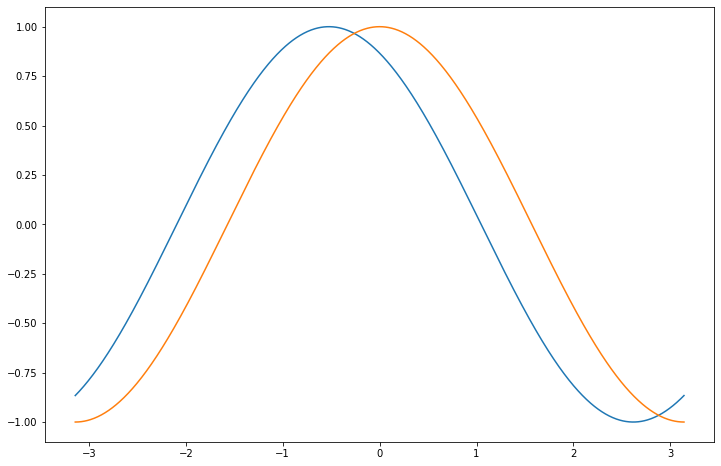

In [1902]:
plt.plot(xs, y1)
plt.plot(xs, y2)

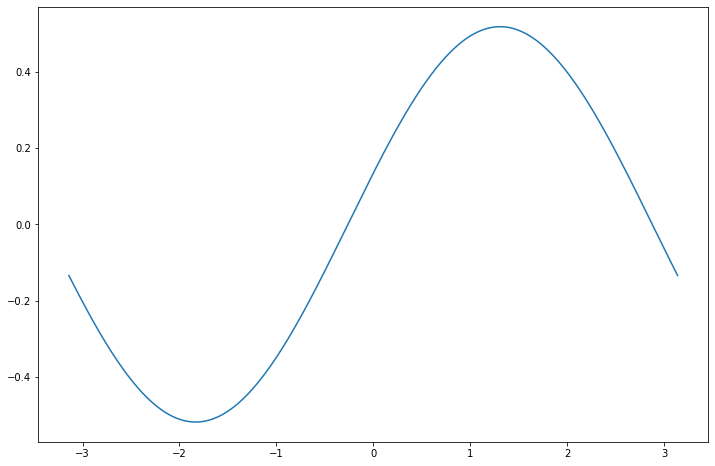

In [1903]:
plt.plot(xs, y2-y1)

In [1499]:
B_fit = df[['Bx_fit', 'By_fit', 'Bz_fit']].values.T
B_cal = df[['Bx_cal', 'By_cal', 'Bz_cal']].values.T

In [1500]:
B_fit.shape

(3, 40432)

In [1501]:
rad_err = np.arcsin(np.linalg.norm(np.cross(B_fit, B_cal, axis=0), axis=0))

In [1502]:
len(rad_err)

40432

Text(0.5, 0, '$\\Delta \\hat{B}$ (rad.)')

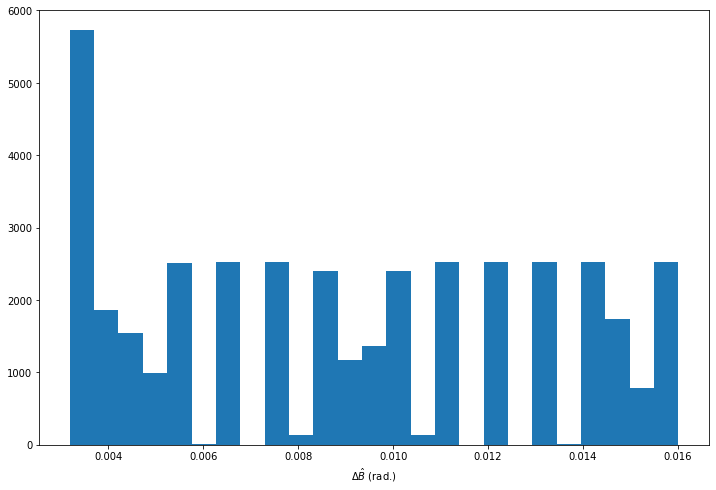

In [1503]:
plt.figure()
plt.hist(rad_err, bins=25)
plt.xlabel(r"$\Delta \hat{B}$ (rad.)")

In [1504]:
np.mean(rad_err), np.std(rad_err)

(0.009023582126476411, 0.004120283349615077)

In [1627]:
# TEMPERATURE CHANGES WITH ANGLE 2

In [ ]:
# 2 y axes
fig = make_subplots(specs=[[{'secondary_y': True}]])
for i in probes:
    fig.add_trace(
        go.Scatter(x=df.index, y=df[f'{i}_Cal_T'], name=f'{i}_Cal_T'),
        secondary_y=False,
    )
for i in ['1','2']:
    fig.add_trace(
        go.Scatter(x=df.index, y=df[f'SmarAct_Meas_Angle_{i}_Rad_pm'], name=f'Meas. Angle {i} (rad)'),
        secondary_y=True,
    )

fig.update_yaxes(title_text="Temperature [deg C]", secondary_y=False)
fig.update_yaxes(title_text="Stage Angle [rad]", secondary_y=True)
plot(fig)

In [563]:
2*np.pi-df_['SmarAct_Meas_Angle_1_Rad'].mean()

0.036512284407843154

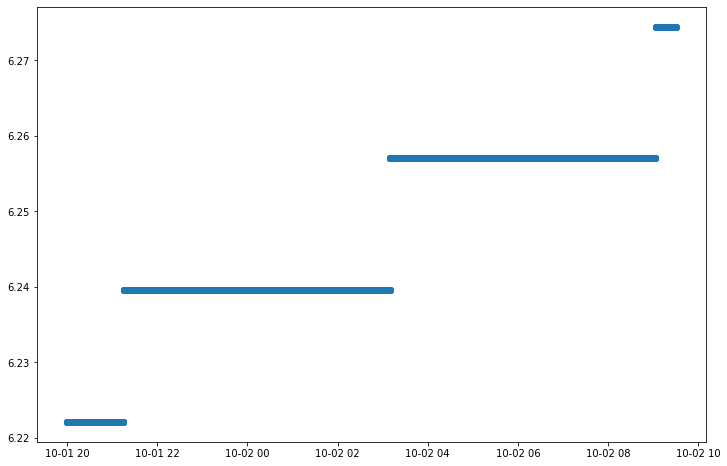

In [560]:
plt.scatter(df_.index, df_['SmarAct_Meas_Angle_1_Rad'])

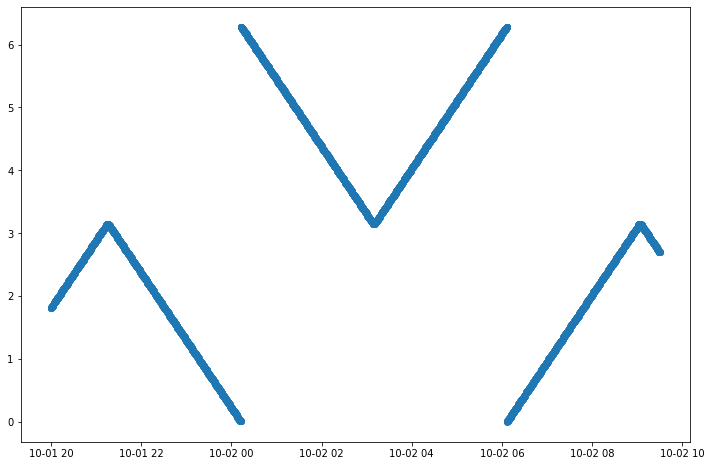

In [561]:
plt.scatter(df_.index, df_['SmarAct_Meas_Angle_2_Rad'])

In [ ]:
df['SmarAct_Meas_Angle_2']

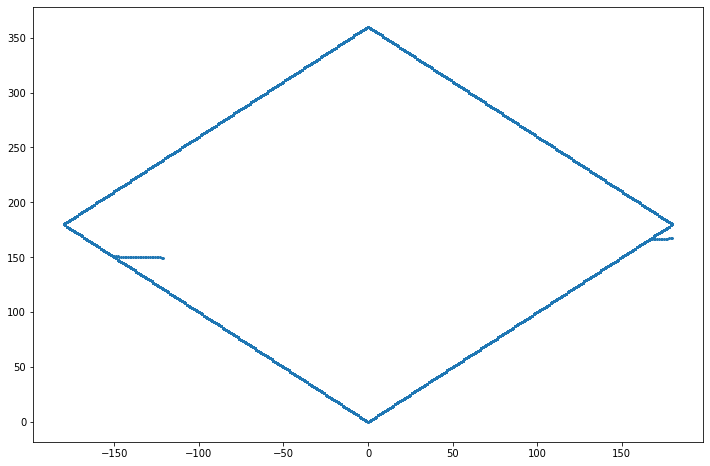

In [471]:
plt.scatter(df['SmarAct_Pattern_Angle_2'], df['SmarAct_Meas_Angle_2'], s=1)

In [432]:
#df_ = df
#df_ = df[df['SmarAct_Meas_Angle_1_Rad_pm'] > 0]
df_ = df[(df['SmarAct_Meas_Angle_1_Rad_pm'] > 0) & (df.index < '10-04-2020 02:30:32')]

In [433]:
len(df_)

15168

In [382]:
#model = lm.Model(smaract_to_Bangle, independent_vars=['angle1','angle2'])
#model = lm.Model(smaract_to_Bangle_v3, independent_vars=['angle1','angle2'])
#model = lm.Model(smaract_to_Bangle_v4, independent_vars=['angle1','angle2'])
model = lm.Model(reco_Bvec_v2, independent_vars=['angle1','angle2', 'B'])
params = lm.Parameters()
#params.add('e1', value=np.pi/2, vary=True, min=-np.pi, max=np.pi)
params.add('e1', value=0, vary=True, min=-np.pi, max=np.pi)
params.add('e2', value=0, vary=True, min=0, max=np.pi)
params.add('c10', value=.5, vary=True, min=0, max=1)
params.add('c20', value=.5, vary=True, min=0, max=1)
#params.add('e3', value=0, vary=True, min=-np.pi, max=np.pi)
#params.add('off_th', value=0.03762239, vary=True, min=-np.pi, max=np.pi)
#params.add('off_ph', value=1.05821414, vary=True, min=-np.pi, max=np.pi)
#params.add('e3', value=0, vary=False, min=-np.pi, max=np.pi)
#params.add('e1', value=2*np.pi, vary=True, min=0, max=2*np.pi)
#params.add('e2', value=np.pi, vary=True, min=0, max=np.pi)
#params.add('e3', value=2*np.pi, vary=True, min=0, max=2*np.pi)

In [383]:
#samples = np.concatenate([df_['B_Theta_cal'].values,df_['B_Phi_cal'].values])
#samples = np.concatenate([df_[f'{probe}_Cal_{i}'].values for i in ['X','Y','Z']])
samples = np.concatenate([df_[f'B{i}_cal'].values for i in ['x','y','z']])
#result = model.fit(samples, angle1=df_['SmarAct_Meas_Angle_1_Rad_pm'].values,
#                   angle2=df_['SmarAct_Meas_Angle_2_Rad_pm'].values, params=params)
#result = model.fit(samples, angle1=df_['SmarAct_Meas_Angle_1_Rad_pm'].values,
#                   angle2=-df_['SmarAct_Meas_Angle_2_Rad_pm'].values, params=params,)
                   #method='least_squares',) #fit_kws={'loss':'huber'})
                   #angle2=-df_['SmarAct_Meas_Angle_2_Rad_pm'].values, params=params)
result = model.fit(samples, angle1=df_['SmarAct_Meas_Angle_1_Rad_pm'].values,
                   angle2=-df_['SmarAct_Meas_Angle_2_Rad_pm'].values,  B=df_[f'{probe}_Cal_Bmag'], params=params,)
                   #angle2=df_['SmarAct_Meas_Angle_2_Rad_pm'].values,  B=df_[f'{probe}_Cal_Bmag'], params=params,)
                   #method='least_squares',) #fit_kws={'loss':'huber'})

In [384]:
# full
result

In [385]:
#np.linalg.norm(result.best_fit.reshape(3, -1), axis=0)
Bx_, By_, Bz_ = result.best_fit.reshape(3, -1)

In [386]:
df_['Bx_fit'] = Bx_
df_['By_fit'] = By_
df_['Bz_fit'] = Bz_

In [387]:
fig = scatter2d(6*[df_.index], [df_[f'B{i}_cal'] for i in ['x','y','z']]+[df_[f'B{B}_fit'] for B in ['x','y','z']], inline=False)

In [311]:
#df_ = df
#df_ = df[df['SmarAct_Meas_Angle_1_Rad_pm'] > 0]
df_ = df[(df['SmarAct_Meas_Angle_1_Rad_pm'] > 0) & (df.index < '10-04-2020 02:30:32')]

In [312]:
len(df_)

15168

In [316]:
#model = lm.Model(smaract_to_Bangle, independent_vars=['angle1','angle2'])
#model = lm.Model(smaract_to_Bangle_v3, independent_vars=['angle1','angle2'])
#model = lm.Model(smaract_to_Bangle_v4, independent_vars=['angle1','angle2'])
model = lm.Model(reco_Bvec_Euler, independent_vars=['angle1','angle2', 'B'])
params = lm.Parameters()
#params.add('e1', value=np.pi/2, vary=True, min=-np.pi, max=np.pi)
params.add('e1', value=0, vary=True, min=-np.pi, max=np.pi)
params.add('e2', value=0, vary=True, min=-np.pi, max=np.pi)
params.add('e3', value=0, vary=True, min=-np.pi, max=np.pi)
params.add('off_th', value=0.03762239, vary=True, min=-np.pi, max=np.pi)
params.add('off_ph', value=1.05821414, vary=True, min=-np.pi, max=np.pi)
#params.add('e3', value=0, vary=False, min=-np.pi, max=np.pi)
#params.add('e1', value=2*np.pi, vary=True, min=0, max=2*np.pi)
#params.add('e2', value=np.pi, vary=True, min=0, max=np.pi)
#params.add('e3', value=2*np.pi, vary=True, min=0, max=2*np.pi)

In [317]:
#samples = np.concatenate([df_['B_Theta_cal'].values,df_['B_Phi_cal'].values])
#samples = np.concatenate([df_[f'{probe}_Cal_{i}'].values for i in ['X','Y','Z']])
samples = np.concatenate([df_[f'B{i}_cal'].values for i in ['x','y','z']])
#result = model.fit(samples, angle1=df_['SmarAct_Meas_Angle_1_Rad_pm'].values,
#                   angle2=df_['SmarAct_Meas_Angle_2_Rad_pm'].values, params=params)
#result = model.fit(samples, angle1=df_['SmarAct_Meas_Angle_1_Rad_pm'].values,
#                   angle2=-df_['SmarAct_Meas_Angle_2_Rad_pm'].values, params=params,)
                   #method='least_squares',) #fit_kws={'loss':'huber'})
                   #angle2=-df_['SmarAct_Meas_Angle_2_Rad_pm'].values, params=params)
result = model.fit(samples, angle1=df_['SmarAct_Meas_Angle_1_Rad_pm'].values,
                   angle2=-df_['SmarAct_Meas_Angle_2_Rad_pm'].values,  B=df_[f'{probe}_Cal_Bmag'], params=params,)
                   #angle2=df_['SmarAct_Meas_Angle_2_Rad_pm'].values,  B=df_[f'{probe}_Cal_Bmag'], params=params,)
                   #method='least_squares',) #fit_kws={'loss':'huber'})

In [318]:
# full
result

In [294]:
#np.linalg.norm(result.best_fit.reshape(3, -1), axis=0)
Bx_, By_, Bz_ = result.best_fit.reshape(3, -1)

In [295]:
df_['Bx_fit'] = Bx_
df_['By_fit'] = By_
df_['Bz_fit'] = Bz_

In [296]:
fig = scatter2d(6*[df_.index], [df_[f'B{i}_cal'] for i in ['x','y','z']]+[df_[f'B{B}_fit'] for B in ['x','y','z']], inline=False)

In [ ]:
# ANGLE OFFSETS

In [254]:
#df_ = df
#df_ = df[df['SmarAct_Meas_Angle_1_Rad_pm'] > 0]
df_ = df[(df['SmarAct_Meas_Angle_1_Rad_pm'] > 0) & (df.index < '10-04-2020 02:30:32')]

In [255]:
len(df_)

15168

In [256]:
#model = lm.Model(smaract_to_Bangle, independent_vars=['angle1','angle2'])
#model = lm.Model(smaract_to_Bangle_v3, independent_vars=['angle1','angle2'])
#model = lm.Model(smaract_to_Bangle_v4, independent_vars=['angle1','angle2'])
model = lm.Model(reco_Bvec, independent_vars=['angle1','angle2', 'B'])
params = lm.Parameters()
#params.add('e1', value=np.pi/2, vary=True, min=-np.pi, max=np.pi)
params.add('e1', value=0, vary=True, min=-np.pi, max=np.pi)
params.add('e2', value=0, vary=True, min=-np.pi, max=np.pi)
#params.add('e3', value=0, vary=False, min=-np.pi, max=np.pi)
#params.add('e1', value=2*np.pi, vary=True, min=0, max=2*np.pi)
#params.add('e2', value=np.pi, vary=True, min=0, max=np.pi)
#params.add('e3', value=2*np.pi, vary=True, min=0, max=2*np.pi)

In [263]:
#samples = np.concatenate([df_['B_Theta_cal'].values,df_['B_Phi_cal'].values])
#samples = np.concatenate([df_[f'{probe}_Cal_{i}'].values for i in ['X','Y','Z']])
samples = np.concatenate([df_[f'B{i}_cal'].values for i in ['x','y','z']])
#result = model.fit(samples, angle1=df_['SmarAct_Meas_Angle_1_Rad_pm'].values,
#                   angle2=df_['SmarAct_Meas_Angle_2_Rad_pm'].values, params=params)
#result = model.fit(samples, angle1=df_['SmarAct_Meas_Angle_1_Rad_pm'].values,
#                   angle2=-df_['SmarAct_Meas_Angle_2_Rad_pm'].values, params=params,)
                   #method='least_squares',) #fit_kws={'loss':'huber'})
                   #angle2=-df_['SmarAct_Meas_Angle_2_Rad_pm'].values, params=params)
result = model.fit(samples, angle1=df_['SmarAct_Meas_Angle_1_Rad_pm'].values,
                   angle2=-df_['SmarAct_Meas_Angle_2_Rad_pm'].values,  B=df_[f'{probe}_Cal_Bmag'], params=params,)
                   #angle2=df_['SmarAct_Meas_Angle_2_Rad_pm'].values,  B=df_[f'{probe}_Cal_Bmag'], params=params,)
                   #method='least_squares',) #fit_kws={'loss':'huber'})

In [264]:
# full
result

In [232]:
# positive theta only
result

In [233]:
from scipy.stats import chi2

In [234]:
1 - chi2.cdf(result.chisqr, result.nfree)

1.0

In [265]:
#np.linalg.norm(result.best_fit.reshape(3, -1), axis=0)
Bx_, By_, Bz_ = result.best_fit.reshape(3, -1)

In [266]:
df_['Bx_fit'] = Bx_
df_['By_fit'] = By_
df_['Bz_fit'] = Bz_

In [267]:
df_['Bx_cal']

Datetime
2020-10-02 14:58:45   -0.031915
2020-10-02 14:58:53   -0.031957
2020-10-02 14:59:01   -0.031965
2020-10-02 14:59:08   -0.031925
2020-10-02 14:59:16   -0.031981
                         ...   
2020-10-04 02:29:53   -0.078340
2020-10-04 02:30:01   -0.078340
2020-10-04 02:30:09   -0.078335
2020-10-04 02:30:17   -0.078327
2020-10-04 02:30:25   -0.078311
Name: Bx_cal, Length: 15168, dtype: float64

In [268]:
fig = scatter2d(6*[df_.index], [df_[f'B{i}_cal'] for i in ['x','y','z']]+[df_[f'B{B}_fit'] for B in ['x','y','z']], inline=False)

In [ ]:
fig = scatter2d(6*[df['Time']], [df[f'{probe}_Cal_{i}'] for i in ['X','Y','Z']]+[df[f'B{B}_ideal'] for B in ['x','y','z']], inline=False)

In [164]:
#df_ = df
#df_ = df[df['SmarAct_Meas_Angle_1_Rad_pm'] > 0]
df_ = df[(df['SmarAct_Meas_Angle_1_Rad_pm'] > 0) & (df.index < '10-04-2020 02:30:32')]

In [165]:
len(df_)

15168

In [171]:
#model = lm.Model(smaract_to_Bangle, independent_vars=['angle1','angle2'])
#model = lm.Model(smaract_to_Bangle_v3, independent_vars=['angle1','angle2'])
model = lm.Model(smaract_to_Bangle_v4, independent_vars=['angle1','angle2'])
params = lm.Parameters()
#params.add('e1', value=np.pi/2, vary=True, min=-np.pi, max=np.pi)
params.add('e1', value=0, vary=True, min=-np.pi, max=np.pi)
params.add('e2', value=1., vary=True, min=-np.pi, max=np.pi)
params.add('e3', value=0, vary=False, min=-np.pi, max=np.pi)
#params.add('e1', value=2*np.pi, vary=True, min=0, max=2*np.pi)
#params.add('e2', value=np.pi, vary=True, min=0, max=np.pi)
#params.add('e3', value=2*np.pi, vary=True, min=0, max=2*np.pi)

In [172]:
samples = np.concatenate([df_['B_Theta_cal'].values,df_['B_Phi_cal'].values])
#result = model.fit(samples, angle1=df_['SmarAct_Meas_Angle_1_Rad_pm'].values,
#                   angle2=df_['SmarAct_Meas_Angle_2_Rad_pm'].values, params=params)
result = model.fit(samples, angle1=df_['SmarAct_Meas_Angle_1_Rad_pm'].values,
                   angle2=-df_['SmarAct_Meas_Angle_2_Rad_pm'].values, params=params,)
                   #method='least_squares',) #fit_kws={'loss':'huber'})
                   #angle2=-df_['SmarAct_Meas_Angle_2_Rad_pm'].values, params=params)

In [173]:
result

In [538]:
model = lm.Model(smaract_to_Bangle, independent_vars=['angle1','angle2'])
params = lm.Parameters()
params.add('e1', value=np.pi/2, vary=True, min=-np.pi, max=np.pi)
params.add('e2', value=0, vary=True, min=-np.pi, max=np.pi)
params.add('e3', value=0, vary=True, min=-np.pi, max=np.pi)
#params.add('e1', value=2*np.pi, vary=True, min=0, max=2*np.pi)
#params.add('e2', value=np.pi, vary=True, min=0, max=np.pi)
#params.add('e3', value=2*np.pi, vary=True, min=0, max=2*np.pi)

In [539]:
samples = np.concatenate([df[f'{probe}_Cal_Theta'].values,df[f'{probe}_Cal_Phi'].values])
#samples = np.concatenate([df[f'{probe}_Cal_Phi'].values,df[f'{probe}_Cal_Theta'].values])

result = model.fit(samples, angle1=df['SmarAct_Meas_Angle_1_Rad_pm'].values,
                   angle2=df['SmarAct_Meas_Angle_2_Rad_pm'].values, params=params)

#result = model.fit(samples, angle1=df['SmarAct_Meas_Angle_1_Rad'].values,
#                   angle2=df['SmarAct_Meas_Angle_2_Rad'].values, params=params)

#result = model.fit(samples, angle1=df['SmarAct_Meas_Angle_2_Rad'].values,
#                   angle2=df['SmarAct_Meas_Angle_1_Rad'].values, params=params)

#result = model.fit(samples, angle1=df['SmarAct_Meas_Angle_2_Rad_pm'].values,
#                   angle2=df['SmarAct_Meas_Angle_1_Rad_pm'].values, params=params)

#result_theta = model.fit(df[f'{probe}_Cal_Theta_Deg'], angle1=df['SmarAct_Meas_Angle_1'],
#                         angle2=df['SmarAct_Meas_Angle_2'], params=params)
#result_phi = model.fit(df[f'{probe}_Cal_Phi_Deg'], angle1=df['SmarAct_Meas_Angle_1'],
#                         angle2=df['SmarAct_Meas_Angle_2'], params=params)

In [540]:
result.params

name,value,standard error,relative error,initial value,min,max,vary
e1,-1.35718056,0.01670563,(1.23%),1.5707963267948966,-3.14159265,3.14159265,True
e2,1.31030779,0.01816724,(1.39%),0,-3.14159265,3.14159265,True
e3,-1.35067543,0.01631847,(1.21%),0,-3.14159265,3.14159265,True


In [541]:
print(result.fit_report())

[[Model]]
    Model(smaract_to_Bangle)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 489
    # data points      = 6120
    # variables        = 3
    chi-square         = 40.2385492
    reduced chi-square = 0.00657815
    Akaike info crit   = -30743.8905
    Bayesian info crit = -30723.7325
[[Variables]]
    e1: -1.35718056 +/- 0.01670563 (1.23%) (init = 1.570796)
    e2:  1.31030779 +/- 0.01816724 (1.39%) (init = 0)
    e3: -1.35067543 +/- 0.01631847 (1.21%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(e1, e3) =  0.996
    C(e1, e2) =  0.937
    C(e2, e3) =  0.934


In [542]:
result.best_fit

array([1.47259928, 1.47560421, 1.47862106, ..., 0.11214297, 0.11265045,
       0.11312769])

In [543]:
samples

array([1.43910732, 1.44000968, 1.44094223, ..., 0.06115566, 0.06337212,
       0.06553928])

In [544]:
np.mean(samples - result.best_fit)

5.655985632177815e-06

In [545]:
np.std(samples - result.best_fit)

0.08108591924680193

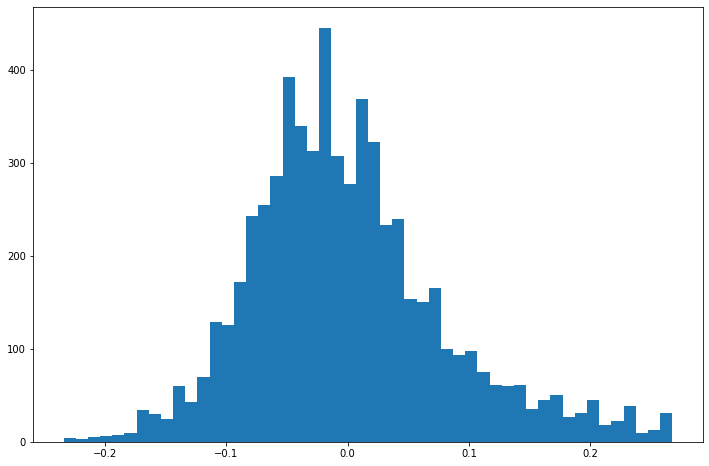

In [546]:
plt.hist(samples-result.best_fit, bins=50);

In [547]:
B = np.mean(df[f'{probe}_Cal_Bmag'])

In [548]:
theta, phi = smaract_to_Bangle(angle1=df['SmarAct_Meas_Angle_1_Rad'], angle2=df['SmarAct_Meas_Angle_2_Rad'], **result.params).reshape(2,-1)

In [549]:
(df[f'{probe}_Cal_Phi'] - phi).describe()

count    3060.000000
mean       -0.018295
std         0.061383
min        -0.136107
25%        -0.060713
50%        -0.035052
75%         0.019751
max         0.137785
Name: 6A0000000D61333A_Cal_Phi, dtype: float64

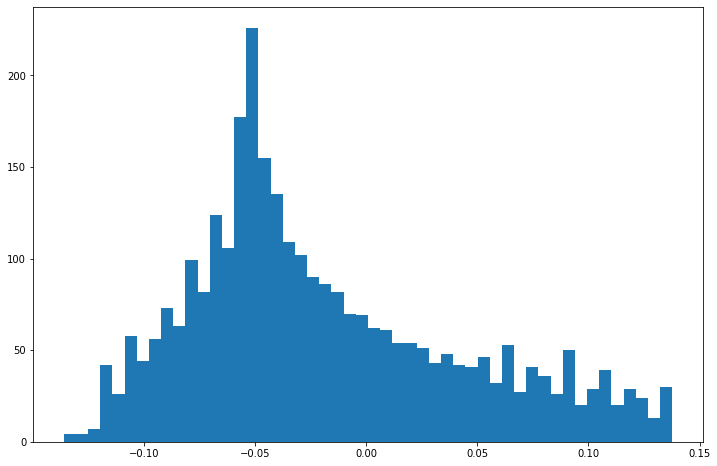

In [550]:
n, bins, patches = plt.hist((df[f'{probe}_Cal_Phi'] - phi), bins=50);

In [551]:
bins[n.argmax():n.argmax()+1]

array([-0.05393917])

In [552]:
(df[f'{probe}_Cal_Theta'] - theta).describe()

count    3060.000000
mean        0.070068
std         0.110561
min        -0.169036
25%        -0.002846
50%         0.063620
75%         0.139910
max         0.335355
Name: 6A0000000D61333A_Cal_Theta, dtype: float64

In [558]:
theta, df[f'{probe}_Cal_Theta'].values

(array([1.56133983, 1.55834876, 1.55534485, ..., 1.54580881, 1.54407859,
        1.54233978]),
 array([1.43910732, 1.44000968, 1.44094223, ..., 1.44417238, 1.4452846 ,
        1.44643703]))

In [555]:
df.loc[:, 'Bx_ideal'] = np.sign(theta)*B*np.sin(theta)*np.cos(phi)
df.loc[:, 'By_ideal'] = np.sign(theta)*B*np.sin(theta)*np.sin(phi)
df.loc[:, 'Bz_ideal'] = np.sign(theta)*B*np.cos(theta)

In [556]:
fig = scatter2d(6*[df['Time']], [df[f'{probe}_Cal_{i}'] for i in ['X','Y','Z']]+[df[f'B{B}_ideal'] for B in ['x','y','z']], inline=False)

In [257]:
(df[f'{probe}_Cal_Theta']).describe()

count    3060.000000
mean        1.564595
std         0.061211
min         1.429979
25%         1.524756
50%         1.562493
75%         1.603580
max         1.710273
Name: 6A0000000D61333A_Cal_Theta, dtype: float64

In [201]:
df['NMR [T]']

Datetime
2020-09-13 07:15:31    0.0
2020-09-13 07:15:39    0.0
2020-09-13 07:15:48    0.0
2020-09-13 07:15:57    0.0
2020-09-13 07:16:06    0.0
                      ... 
2020-09-13 14:57:20    0.0
2020-09-13 14:57:29    0.0
2020-09-13 14:57:37    0.0
2020-09-13 14:57:46    0.0
2020-09-13 14:57:55    0.0
Name: NMR [T], Length: 3060, dtype: float64

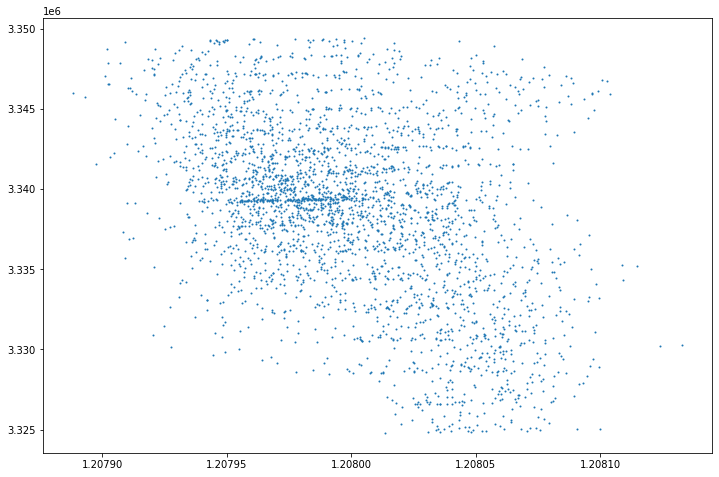

In [202]:
plt.scatter(df[f'{probe}_Cal_Bmag'], df[f'{probe}_Raw_Bmag'], s=1)

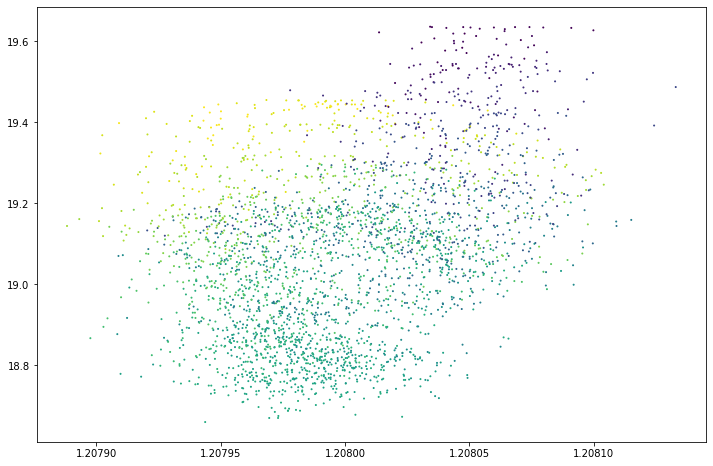

In [203]:
plt.scatter(df[f'{probe}_Cal_Bmag'], df[f'{probe}_Cal_T'], c=df[f'{probe}_Raw_Bmag'], s=1)

### Test 3: Voltage Regression (vs. Temp, B)

In [152]:
def regress_B_t(B, t, **params):
    return params['m1'] * B + params['m2'] * t + params['b']

In [154]:
model = lm.Model(regress_B_t, independent_vars=['B','t'])
params = lm.Parameters()
params.add('m1', value=0, vary=True)
params.add('m2', value=0, vary=True)
params.add('b', value=0, vary=True)

In [155]:
#samples = np.concatenate([df['SmarAct_Meas_Angle_1'].values,df['SmarAct_Meas_Angle_2'].values])
result = model.fit(df[f'{probe}_Raw_Bmag'], B=df[f'{probe}_Cal_Bmag'],
                         t=df[f'{probe}_Cal_T'], params=params)

In [156]:
result.params

name,value,standard error,relative error,initial value,min,max,vary
m1,19612031.2,979733.068,(5.00%),0,-inf,inf,True
m2,1925.11481,181.528763,(9.43%),0,-inf,inf,True
b,-20388655.3,1186821.23,(5.82%),0,-inf,inf,True


In [158]:
print(result.fit_report())

[[Model]]
    Model(regress_B_t)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 101
    # data points      = 1783
    # variables        = 3
    chi-square         = 9.1459e+09
    reduced chi-square = 5138156.40
    Akaike info crit   = 27554.2788
    Bayesian info crit = 27570.7370
[[Variables]]
    m1:  19612031.2 +/- 979733.068 (5.00%) (init = 0)
    m2:  1925.11481 +/- 181.528763 (9.43%) (init = 0)
    b:  -20388655.3 +/- 1186821.23 (5.82%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, b)  = -1.000
    C(m2, b)  = -0.910
    C(m1, m2) =  0.910


In [159]:
result.best_fit

Datetime
2020-09-10 12:22:48    3.346266e+06
2020-09-10 12:22:57    3.345540e+06
2020-09-10 12:23:06    3.346128e+06
2020-09-10 12:23:14    3.345711e+06
2020-09-10 12:23:23    3.345309e+06
                           ...     
2020-09-10 16:44:01    3.342927e+06
2020-09-10 16:44:10    3.342818e+06
2020-09-10 16:44:19    3.343400e+06
2020-09-10 16:44:28    3.343512e+06
2020-09-10 16:44:36    3.342321e+06
Length: 1783, dtype: float64

In [164]:
((df[f'{probe}_Raw_Bmag'] - result.best_fit)).describe()

count    1783.000000
mean       -0.015551
std      2265.477803
min     -6623.588606
25%     -1534.564065
50%       721.142387
75%      1655.464792
max      4345.637408
dtype: float64

In [163]:
((df[f'{probe}_Raw_Bmag'] - result.best_fit)/df[f'{probe}_Raw_Bmag']).describe()

count    1.783000e+03
mean    -4.634347e-07
std      6.777224e-04
min     -1.983584e-03
25%     -4.592435e-04
50%      2.155233e-04
75%      4.949924e-04
max      1.297385e-03
dtype: float64

In [92]:
result_theta.params

name,value,standard error,relative error,initial value,min,max,vary
m1,-0.41437746,0.20950890,(50.56%),0,-inf,inf,True
m2,-0.01093812,1.9621e-04,(1.79%),0,-inf,inf,True
b,239.515641,74.4170067,(31.07%),0,-inf,inf,True


In [93]:
result_phi.params

name,value,standard error,relative error,initial value,min,max,vary
m1,-0.50907667,0.14099727,(27.70%),0,-inf,inf,True
m2,0.00225845,1.3204e-04,(5.85%),0,-inf,inf,True
b,182.134348,50.0818557,(27.50%),0,-inf,inf,True


In [94]:
print(result_theta.fit_report())

[[Model]]
    Model(regress_2angle)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 1783
    # variables        = 3
    chi-square         = 2313.07861
    reduced chi-square = 1.29948237
    Akaike info crit   = 470.082859
    Bayesian info crit = 486.541017
[[Variables]]
    m1: -0.41437746 +/- 0.20950890 (50.56%) (init = 0)
    m2: -0.01093812 +/- 1.9621e-04 (1.79%) (init = 0)
    b:   239.515641 +/- 74.4170067 (31.07%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, b) = -1.000


In [138]:
result_theta.params

name,value,standard error,relative error,initial value,min,max,vary
m1,-0.40614277,0.00716255,(1.76%),0,-inf,inf,True
m2,-6.2571e-04,7.4586e-06,(1.19%),0,-inf,inf,True
b,234.956181,2.54477282,(1.08%),0,-inf,inf,True


In [139]:
result_phi.params

name,value,standard error,relative error,initial value,min,max,vary
m1,-0.90575413,0.00166454,(0.18%),0,-inf,inf,True
m2,1.3771e-04,1.7333e-06,(1.26%),0,-inf,inf,True
b,324.316462,0.59139204,(0.18%),0,-inf,inf,True


In [140]:
print(result_theta.fit_report())

[[Model]]
    Model(regress_2angle)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 2547
    # variables        = 3
    chi-square         = 11.3408113
    reduced chi-square = 0.00445787
    Akaike info crit   = -13784.1295
    Bayesian info crit = -13766.6015
[[Variables]]
    m1: -0.40614277 +/- 0.00716255 (1.76%) (init = 0)
    m2: -6.2571e-04 +/- 7.4586e-06 (1.19%) (init = 0)
    b:   234.956181 +/- 2.54477282 (1.08%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, b) = -1.000


In [141]:
print(result_phi.fit_report())

[[Model]]
    Model(regress_2angle)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 2547
    # variables        = 3
    chi-square         = 0.61248729
    reduced chi-square = 2.4076e-04
    Akaike info crit   = -21217.8926
    Bayesian info crit = -21200.3646
[[Variables]]
    m1: -0.90575413 +/- 0.00166454 (0.18%) (init = 0)
    m2:  1.3771e-04 +/- 1.7333e-06 (1.26%) (init = 0)
    b:   324.316462 +/- 0.59139204 (0.18%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, b) = -1.000


In [142]:
regress_2angle(0, 0, **result_phi.params)

324.31646169106386

In [143]:
a1s = np.linspace(0, 180, 181)
a2s = np.linspace(0, 360, 361)

In [144]:
A1, A2 = np.meshgrid(a1s, a2s)

In [145]:
TH = regress_2angle(A1, A2, **result_theta.params)
PH = regress_2angle(A1, A2, **result_phi.params)

In [150]:
TH.min(), TH.max(), PH.min(), PH.max()

(161.62522598767595, 234.95618101927016, 161.28071895373125, 324.3660383225497)

In [152]:
TH.max()-TH.min(), PH.max()-PH.min()

(73.33095503159421, 163.08531936881843)

-------------

In [70]:
r_phi = np.corrcoef(df[f'{probe}_Cal_Phi'], df['SmarAct_Meas_Angle_1'])
r_theta = np.corrcoef(df[f'{probe}_Cal_Theta'], df['SmarAct_Meas_Angle_2_pm'])

In [72]:
r_phi[0,1], r_theta[0,1]

(-0.9852445464472992, 0.8744525524711794)

In [8]:
fig = scatter2d(df[f"{probe}_Cal_T"], df["NMR [T]"], inline=False)

In [9]:
fig = scatter2d(df["Yoke (center magnet)"], df["NMR [T]"], inline=False)

In [10]:
fig = scatter2d( df["NMR [T]"],df["DF0000000D5E803A_Cal_Bmag"], inline=False)

In [15]:
fig = scatter2d( df["DF0000000D5E803A_Cal_T"],(df["DF0000000D5E803A_Cal_X"]-df["NMR [T]"])/df["NMR [T]"], markers=True, lines=False, inline=False)

In [30]:
df.tail(1)

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1 (new),Coil 2 (old),LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke,...,DF0000000D5E803A_Cal_Phi,6A0000000D61333A_Raw_Transverse,6A0000000D61333A_Raw_Theta,6A0000000D61333A_Raw_Phi,C50000000D5E473A_Raw_Transverse,C50000000D5E473A_Raw_Theta,C50000000D5E473A_Raw_Phi,DF0000000D5E803A_Raw_Transverse,DF0000000D5E803A_Raw_Theta,DF0000000D5E803A_Raw_Phi
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-02-12 11:30:27,2/12/2020 11:30:27 AM,240.0706,28.651067,32.329288,30.131769,8.32542,10.983446,13.566287,14.512237,22.224464,...,1.56294,539.726783,0.128991,0.757882,59928.373313,1.254132,1.244276,3.387744e+06,1.56076,1.113235


In [31]:
len(df)

23019

In [32]:
len(df) * 50 / 60 / 60 / 24

13.321180555555555

In [33]:
fig = histo(df["NMR [T]"], bins=50, inline=False)

In [34]:
fig = scatter2d(3*[df.index], [df[col+"_Cal_Bmag"] for col in probes], inline=False);

In [35]:
fig = scatter2d(2*[df.index], [df["NMR [T]"], df[f"{probe}_Cal_Bmag"]], show_plot=False);

In [36]:
plot(fig)

'temp-plot.html'

In [37]:
fig = scatter2d(df.index, df[f"{probe}_Cal_Res_Rel"], show_plot=False);

In [38]:
plot(fig)

'temp-plot.html'

In [39]:
fig = scatter2d(df[f"{probe}_Cal_T"], df[f"{probe}_Cal_Res_Rel"], df.days_delta, inline=False);

In [40]:
fig = scatter2d(df["Roof"], df[f"{probe}_Cal_Res_Rel"], df.days_delta, inline=False);

~ -2e-4 change in residual after changing temperature (+7 deg C).

**(old, early Run06)**
~ -5e-5 change in residual after changing temperature (+4 deg C).

In [41]:
fig = histo(df[f"{probe}_Cal_Res_Rel"], bins=75, show_plot=False);
plot(fig)
#fig = histo(df[f"{probe}_Cal_Res_Rel"], bins=50, yscale='log')

'temp-plot.html'

In [42]:
df["day"] = df.index.day

In [43]:
fig = px.histogram(df, x=f"{probe}_Cal_Res_Rel", color="day")

In [44]:
fig.update_layout(
    autosize=False,
    width=1800,
    height=800
    #margin=dict(l=20, r=20, t=20, b=20),
    #padding=dict(l=20, r=20, t=20, b=20),
    #paper_bgcolor="LightSteelBlue",
);

In [45]:
#fig.show()

In [46]:
plot(fig)

'temp-plot.html'

### Temps

In [47]:
temps_ch = [a for a in df.columns if ("CH" in a) and int(a[-2:])<21]# or "HVAC" in a]
temps_ch.append("Hall Element")
temps_ch.append("Floor")
temps_ch.append("Roof")
temps_ch.append("Yoke")
temps_ch.append("Yoke (center magnet)")
temps_ch.append(f"{probe}_Cal_T")

In [48]:
#temps_ch

In [49]:
fig = scatter2d([df.index for c in temps_ch],[df[c] for c in temps_ch],inline=True, show_plot=False);
fig.layout.title = "Temp vs. Datetime"
fig.layout.yaxis.title = "Temp [deg. C]";

In [50]:
#fname = 'temps_scatter'
fname = 'time/temps/temps_scatter_full'
pio.write_image(fig, plotdir+fname+'.pdf')
pio.write_image(fig, plotdir+fname+'.png')
plot(fig, filename=plotdir+fname+'.html', auto_open=False)

'/home/ckampa/Coding/hallprobecalib_extras/plots/hall_probe_stability/2020-01-27/time/temps/temps_scatter_full.html'

In [51]:
plot(fig)

'temp-plot.html'

In [56]:
temps_water = [col for col in df.columns if ("ICW" in col) or ("LCW" in col)]

In [105]:
#temps_water

In [57]:
fig = scatter2d([df.index for c in temps_water],[df[c] for c in temps_water],inline=True, show_plot=False);
fig.layout.title = "Water Temp vs. Datetime"
fig.layout.yaxis.title = "Temp [deg. C]"

In [58]:
#fig.show()
plot(fig)

'temp-plot.html'

In [59]:
#fname = 'temps_scatter'
fname = 'time/temps/temps_scatter_water'
pio.write_image(fig, plotdir+fname+'.pdf')
pio.write_image(fig, plotdir+fname+'.png')
plot(fig, filename=plotdir+fname+'.html', auto_open=False)

'/home/ckampa/Coding/hallprobecalib_extras/plots/hall_probe_stability/2020-01-27/time/temps/temps_scatter_water.html'

In [60]:
temps_ambient = [col for col in df.columns if ("Ambient" in col)]
#temps_ambient

In [61]:
fig = scatter2d([df.index for c in temps_ambient],[df[c] for c in temps_ambient],inline=True, show_plot=False);
fig.layout.title = "Ambient Temp vs. Datetime"
fig.layout.yaxis.title = "Temp [deg. C]"
#fig.show()
plot(fig)

'temp-plot.html'

In [62]:
#fname = 'temps_scatter'
fname = 'time/temps/temps_scatter_ambient'
pio.write_image(fig, plotdir+fname+'.pdf')
pio.write_image(fig, plotdir+fname+'.png')
plot(fig, filename=plotdir+fname+'.html', auto_open=False)

'/home/ckampa/Coding/hallprobecalib_extras/plots/hall_probe_stability/2020-01-27/time/temps/temps_scatter_ambient.html'

In [63]:
temps_magnet = [col for col in df.columns if (("PS" in col) or ("Coil" in col) or ("Yoke" in col)) and ("Orange" not in col)]
#temps_magnet

In [64]:
fig = scatter2d([df.index for c in temps_magnet],[df[c] for c in temps_magnet],inline=True, show_plot=False);
fig.layout.title = "Magnet Temp vs. Datetime"
fig.layout.yaxis.title = "Temp [deg. C]"
#fig.show()
plot(fig)

'temp-plot.html'

In [65]:
#fname = 'temps_scatter'
fname = 'time/temps/temps_scatter_magnet'
pio.write_image(fig, plotdir+fname+'.pdf')
pio.write_image(fig, plotdir+fname+'.png')
plot(fig, filename=plotdir+fname+'.html', auto_open=False)

'/home/ckampa/Coding/hallprobecalib_extras/plots/hall_probe_stability/2020-01-27/time/temps/temps_scatter_magnet.html'

## Seeing Temperature Corrections

In [66]:
fig = scatter2d(df[f"{probe}_Cal_T"], df["NMR [T]"], df.days_delta, show_plot=False)

In [67]:
plot(fig)

'temp-plot.html'

In [68]:
fig = scatter2d(df[f"{probe}_Cal_T"], df[f"{probe}_Cal_Bmag"] / df["NMR [T]"], df.days_delta, inline=False)

In [69]:
fig = scatter2d(df[f"{probe}_Cal_T"], df[f"{probe}_Raw_Bmag"] / df["NMR [T]"], df.days_delta, inline=False)

In [70]:
fig = scatter2d(df[f"{probe}_Cal_T"], df[f"{probe}_Raw_Bmag"], df.days_delta, inline=False)

In [71]:
fig = scatter2d(3*[df[f"{probe}_Cal_T"]], [df[f"{probe}_Raw_{comp}"] / df["NMR [T]"] for comp in ["X","Y","Z"]],
                3*[df.days_delta], inline=False)

In [72]:
fig = scatter2d(df.index, df[f"{probe}_Raw_Theta"], df.days_delta, inline=False)

In [73]:
fig = scatter2d(df.index, df[f"{probe}_Raw_Phi"], df.days_delta, inline=False)

### Fit!

In [52]:
df = df[df["NMR [T]"] != 0]

In [53]:
def volt(temp, A, B):
    return A * temp + B

In [54]:
guess = np.array([-1300 / 3.5, 2e6]) # A, B

In [55]:
x_dat = df[f"{probe}_Cal_T"]
#x_dat = df[stable_temp][f"{probe}_Cal_T"]

In [56]:
params, cov = optimization.curve_fit(volt, x_dat, df[f"{probe}_Raw_Bmag"] / df["NMR [T]"], guess)
#params, cov = optimization.curve_fit(volt, x_dat, 
#                                     df[stable_temp][f"{probe}_Raw_Bmag"] / df[stable_temp]["NMR [T]"], guess)

In [57]:
params, cov

(array([-1.18040565e+03,  2.83879530e+06]), array([[ 0.04191652, -0.88642618],
        [-0.88642618, 19.31005472]]))

In [58]:
np.sqrt(cov[0,0])

0.20473523980511196

In [59]:
cov[0,1] / (np.sqrt(cov[0,0])*np.sqrt(cov[1,1]))

-0.985276720331901

Parameters have strong correlation

In [60]:
A_fit, B_fit = params

In [61]:
df["Bmag_lsq"] = volt(x_dat, A_fit, B_fit)

In [84]:
fig = scatter2d(df[f"{probe}_Cal_T"], df[f"{probe}_Raw_Bmag"] / df["NMR [T]"], df.days_delta, show_plot=False)
#d = [df[f"{probe}_Raw_X"].min(), df[f"{probe}_Raw_X"].max()]
fig.add_trace(go.Scatter(
                    x=df[f"{probe}_Cal_T"], y=df["Bmag_lsq"],
                    mode='lines', name="unity",
                    line=dict(color='deeppink', width=2,
                              dash='dash')));
plot(fig)

'temp-plot.html'

In [85]:
fig.update_traces(marker=dict(size=5));
plot(fig);

Bmag fit looks pretty good so far (4 data points).

## Aggregate data

In [86]:
#df["Floor"].diff(5).rolling(5).mean().head()

In [62]:
#fig = scatter2d(df.index, df["Floor"].diff(5).rolling(5).mean(), inline=False)
fig = scatter2d(2*[df.index], [df["Floor"],df["Floor"].diff(5).rolling(5).mean()], inline=False)

In [63]:
#stable_temp = (abs(df["Floor"].diff(5).rolling(5).mean()) < 0.008) #| (np.isnan(df["Floor"].diff(5)))
stable_temp = (abs(df["Floor"].diff(5).rolling(5).mean()) < 0.025) #| (np.isnan(df["Floor"].diff(5)))

In [64]:
df_ = df[stable_temp]

In [65]:
len(df), len(df_)

(23019, 22119)

In [66]:
df_.tail(2)

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1 (new),Coil 2 (old),LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke,...,6A0000000D61333A_Raw_Theta,6A0000000D61333A_Raw_Phi,C50000000D5E473A_Raw_Transverse,C50000000D5E473A_Raw_Theta,C50000000D5E473A_Raw_Phi,DF0000000D5E803A_Raw_Transverse,DF0000000D5E803A_Raw_Theta,DF0000000D5E803A_Raw_Phi,day,Bmag_lsq
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-02-12 10:43:26,2/12/2020 10:43:26 AM,240.070883,28.632033,31.722984,29.564817,8.06336,10.695252,13.167009,14.173713,21.753210,...,0.130385,0.723302,59932.263006,1.252390,1.245125,3.391588e+06,1.562459,1.113487,12,2.809498e+06
2020-02-12 10:44:26,2/12/2020 10:44:26 AM,240.070940,28.632233,31.783482,29.606745,8.10455,10.739941,13.157190,14.219605,21.770008,...,0.117138,0.893853,59994.372544,1.252968,1.244613,3.391355e+06,1.562461,1.113479,12,2.809295e+06


In [67]:
fig = scatter2d(df[stable_temp][f"{probe}_Cal_T"],
                df[stable_temp][f"{probe}_Raw_Bmag"] / df[stable_temp]["NMR [T]"],
                df[stable_temp].days_delta, show_plot=False)
#d = [df[f"{probe}_Raw_X"].min(), df[f"{probe}_Raw_X"].max()]
fig.add_trace(go.Scatter(
                    x=df[stable_temp][f"{probe}_Cal_T"], y=df[stable_temp]["Bmag_lsq"],
                    mode='lines', name="unity",
                    line=dict(color='deeppink', width=2,
                              dash='dash')));
#plot(fig)

fig.update_traces(marker=dict(size=5));
plot(fig);

In [68]:
phi0 = df_.iloc[0][f"{probe}_Raw_Phi"]
theta0 = df_.iloc[0][f"{probe}_Raw_Theta"]

In [69]:
df_["ANGLE"] = np.sqrt((df_[f"{probe}_Raw_Theta"]-theta0)**2 + (df_[f"{probe}_Raw_Phi"]-phi0)**2)

In [70]:
fig = scatter2d(df_["ANGLE"], df_[f'{probe}_Cal_Res_Rel'],df_.days_delta, inline=False)

In [71]:
fig = scatter2d(df_[f'{probe}_Raw_Theta'], df_[f'{probe}_Cal_Res_Rel'],df_.days_delta, inline=False)

In [64]:
## NEW, do all at once

In [72]:
df_["Scaled Hall Voltage"] = df_[f"{probe}_Raw_Bmag"] / df_["NMR [T]"] * df_["NMR [T]"].iloc[0]
df_["Scaled Hall X"] = df_[f"{probe}_Raw_X"] / df_["NMR [T]"] * df_["NMR [T]"].iloc[0]
df_["Scaled Hall Y"] = df_[f"{probe}_Raw_Y"] / df_["NMR [T]"] * df_["NMR [T]"].iloc[0]
df_["Scaled Hall Z"] = df_[f"{probe}_Raw_Z"] / df_["NMR [T]"] * df_["NMR [T]"].iloc[0]

In [90]:
w = 0.3
ts = np.array([15.9, 17.7, 19.3, 21.2, 22.75, 24.58, 26.1])#16.0,16.8,18.6,20.3,22.0,23.8,25.35,27.0,28.0])
ts_h = ts + w
ts_l = ts - w

In [91]:
ts_l

array([15.6 , 17.4 , 19.  , 20.9 , 22.45, 24.28, 25.8 ])

In [92]:
ts_h

array([16.2 , 18.  , 19.6 , 21.5 , 23.05, 24.88, 26.4 ])

In [93]:
maps = [((df_[f"{probe}_Cal_T"] > ts_l[i]) & (df_[f"{probe}_Cal_T"] < ts_h[i])) for i in range(len(ts))]

In [94]:
len(maps)

7

In [95]:
map_full = maps[0]

for m in maps[1:]:
    map_full = map_full | m
    

In [96]:
len(df_[map_full])

22113

In [97]:
len(df_)

22119

In [98]:
xs = np.zeros_like(ts)
ys = np.zeros_like(ts)
xerrs = np.zeros_like(ts)
yerrs = np.zeros_like(ts)
ns = np.zeros_like(ts)

## calculate averages
for i,m in enumerate(maps):
    df_sp = df_[m]
    ns[i] = len(df_sp)
    xs[i] = df_sp[f"{probe}_Cal_T"].mean()
    xerrs[i] = df_sp[f"{probe}_Cal_T"].std()
    ys[i] = df_sp["Scaled Hall Voltage"].mean()
    yerrs[i] = df_sp["Scaled Hall Voltage"].std()

In [99]:
xs

array([15.89655233, 17.64736637, 19.34827515, 21.13672514, 22.81150658,
       24.53801517, 26.19842398])

In [100]:
def volt(temp, A, B):
    return A * temp + B

In [101]:
guess = np.array([-1300 / 3.5, 2e6]) # A, B

In [102]:
x_dat = df_[f"{probe}_Cal_T"]
x_dat_avg = xs
#x_dat = df[stable_temp][f"{probe}_Cal_T"]

In [103]:
y_dat = df_["Scaled Hall Voltage"]
#y_dat = df_["Scaled Hall Z"]
#y_dat = df_["NMR [T]"]

In [104]:
params, cov = optimization.curve_fit(volt, x_dat, y_dat, guess)
params_avg, cov_avg = optimization.curve_fit(volt, x_dat_avg, ys, guess)
#params, cov = optimization.curve_fit(volt, x_dat, 
#                                     df[stable_temp][f"{probe}_Raw_Bmag"] / df[stable_temp]["NMR [T]"], guess)

In [105]:
# stable temp
params, cov

(array([-1.42562616e+03,  3.42826666e+06]), array([[ 0.06097712, -1.28812275],
        [-1.28812275, 28.03706027]]))

In [106]:
# stable temp averaged
params_avg, cov_avg

(array([-1.42392463e+03,  3.42821889e+06]),
 array([[   270.72168011,  -5707.46638385],
        [ -5707.46638385, 123529.7055177 ]]))

In [107]:
A_fit, B_fit = params
A_fit_avg, B_fit_avg = params_avg

In [108]:
df_["Bmag_lsq"] = volt(x_dat, A_fit, B_fit)
df_["Bmag_lsq_avg"] = volt(x_dat, A_fit_avg, B_fit_avg)

In [109]:
ts = np.linspace(x_dat.min(), x_dat.max(), 25)

In [110]:
B_lsq = volt(ts, A_fit, B_fit)
B_lsq_avg = volt(ts, A_fit_avg, B_fit_avg)

In [111]:
B_lsq = pd.Series(B_lsq, name="Stable Temp Fit")
B_lsq_avg = pd.Series(B_lsq_avg, name="Stable Temp Averaged Fit")

In [112]:
averaged=True

fig = scatter2d(x_dat,
                y_dat,
                df_.days_delta, opacity=0.8, show_plot=False)

fig.add_trace(go.Scatter(
                    x=ts, y=B_lsq,
                    mode='lines', name='Linear fit',#"|V|/|B| = A * Temp. + B",
                    line=dict(color='rgb(78, 42, 132)',#'deeppink',
                              width=1,
                              dash='dash')));
#fig.add_trace(go.Scatter(
#                    x=ts, y=B_lsq_avg,
#                    mode='lines', name="mean(|V|/|B|) = A * mean(Temp.) + B",
#                    line=dict(color='purple', width=1,
#                              dash='dash')));

fig.update_traces(marker=dict(size=1));

if averaged:
    fig.add_trace(go.Scatter(
        x= xs,
        y= ys,
        mode='markers',
        name='Averaged Data',
        error_x=dict(
            type='data',
            array=xerrs,
            width=1,
            thickness=1.,
            visible=True),
        error_y=dict(
            type='data',
            array=yerrs,
            width=1,
            thickness=1.,
            visible=True),
        marker=dict(
            size=3,
            color="Red",
        )
    ))

#eqn = f"Volt. = {A_fit:.2E} * Temp. + {B_fit:.2E}"
eqn = f"y = {A_fit:.2E} * x + {B_fit:.2E}"

i = 6
fig.add_annotation(
    go.layout.Annotation(
            x=ts[i],
            y=B_lsq.iloc[i],
            text=eqn,
            font=dict(
                #family="Courier New, monospace",
                size=14,
                color="#ffffff"
            ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="#636363",
            ax=+250,
            ay=-25,
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor='rgb(78, 42, 132)',#"#ff7f0e",
            opacity=0.7,
            showarrow=True#False
    )
)

fig.update_layout(title="Scaled Hall Voltage vs. Hall Probe Temperature")
fig.update_xaxes(title_text='Hall Probe Temperature [deg C]')
fig.update_yaxes(title_text='|V_Hall| / NMR [micro V / T]')
fig.update_layout( width=1000,height=600,)

filename = plotdir+"scaled_voltage_vs_temperature"

plot(fig, filename=filename+'.html')

'/home/ckampa/Coding/hallprobecalib_extras/plots/hall_probe_stability/2020-01-27/scaled_voltage_vs_temperature.html'

In [113]:
pio.write_image(fig, filename+".pdf")
pio.write_image(fig, filename+".png")

In [ ]:
fig = scatter2d(df_["NMR [T]"],
                df_[f"{probe}_Raw_Bmag"],# * df_[f"{probe}_Cal_T"].min() / df_[f"{probe}_Cal_T"],
                df_.days_delta, opacity=1., inline=False)

In [ ]:
fig = scatter2d(df_["NMR [T]"],
                df_[f"{probes[0]}_Raw_Bmag"],# * df_[f"{probe}_Cal_T"].min() / df_[f"{probe}_Cal_T"],
                df_.days_delta, opacity=1., inline=False)

In [ ]:
fig = scatter2d(df_["NMR [T]"],
                df_[f"{probes[0]}_Cal_Bmag"],# * df_[f"{probe}_Cal_T"].min() / df_[f"{probe}_Cal_T"],
                df_.days_delta, opacity=1., inline=False)

In [ ]:
fig = scatter2d(df["NMR [T]"],
                df[f"{probe}_Raw_Bmag"],# * df[f"{probe}_Cal_T"].min() / df[f"{probe}_Cal_T"],
                df.days_delta, opacity=1., inline=False)

In [ ]:
x = np.array([6e-4, 2.36e-2, 1.2492]) # B in Tesla
y = np.array([4.85e3, 6.43e4, 3.5e6]) # Hall voltage (Bmag), note: 3 different probes

In [ ]:
fig = scatter2d(x, y, lines=False, markers=True, size_list=[8], inline=False)

In [ ]:
def volt_b(mag, A, B):
    return A * mag + B

In [ ]:
guess = np.array([3e6, 0.]) # A, B

In [ ]:
x_dat = x
#x_dat_avg = xs
#x_dat = df[stable_temp][f"{probe}_Cal_T"]

In [ ]:
y_dat = y

In [ ]:
params, cov = optimization.curve_fit(volt_b, x_dat, y_dat, guess)
#params_avg, cov_avg = optimization.curve_fit(volt, x_dat_avg, ys, guess)
#params, cov = optimization.curve_fit(volt, x_dat, 
#                                     df[stable_temp][f"{probe}_Raw_Bmag"] / df[stable_temp]["NMR [T]"], guess)

In [ ]:
# stable temp
params, cov

In [ ]:
A_fit, B_fit = params
#A_fit_avg, B_fit_avg = params_avg

In [ ]:
B_lsq_dat = volt_b(x_dat, A_fit, B_fit)
#df_["Bmag_lsq"] = volt_b(x_dat, A_fit, B_fit)

In [ ]:
ts = np.linspace(x_dat.min(), x_dat.max(), 25)

In [ ]:
B_lsq = volt_b(ts, A_fit, B_fit)
#B_lsq_avg = volt_b(ts, A_fit_avg, B_fit_avg)

In [ ]:
B_lsq = pd.Series(B_lsq, name="Stable Temp Fit")
#B_lsq_avg = pd.Series(B_lsq_avg, name="Stable Temp Averaged Fit")

In [ ]:
fig = scatter2d(x_dat,
                y_dat,
                lines=False, markers=True,
                size_list=[8], opacity=0.8, show_plot=False)

fig.add_trace(go.Scatter(
                    x=ts, y=B_lsq,
                    mode='lines', name='Linear fit',#"|V|/|B| = A * Temp. + B",
                    line=dict(color='rgb(78, 42, 132)',#'deeppink',
                              width=1,
                              dash='dash')));
#fig.add_trace(go.Scatter(
#                    x=ts, y=B_lsq_avg,
#                    mode='lines', name="mean(|V|/|B|) = A * mean(Temp.) + B",
#                    line=dict(color='purple', width=1,
#                              dash='dash')));

#fig.update_traces(marker=dict(size=1));

'''fig.add_trace(go.Scatter(
    x= xs,
    y= ys,
    mode='markers',
    name='Averaged Data',
    error_x=dict(
        type='data',
        array=xerrs,
        width=1,
        thickness=1.,
        visible=True),
    error_y=dict(
        type='data',
        array=yerrs,
        width=1,
        thickness=1.,
        visible=True),
    marker=dict(
        size=3,
        color="Red",
    )
))
'''
#eqn = f"Volt. = {A_fit:.2E} * Temp. + {B_fit:.2E}"
eqn = f"y = {A_fit:.2E} * x + {B_fit:.2E}"

i = 6
fig.add_annotation(
    go.layout.Annotation(
            x=ts[i],
            y=B_lsq.iloc[i],
            text=eqn,
            font=dict(
                #family="Courier New, monospace",
                size=14,
                color="#ffffff"
            ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="#636363",
            ax=+250,
            ay=-25,
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor='rgb(78, 42, 132)',#"#ff7f0e",
            opacity=0.7,
            showarrow=True#False
    )
)

fig.update_layout(title="Scaled Hall Voltage vs. Hall Probe Temperature")
fig.update_xaxes(title_text='Hall Probe Temperature [deg C]')
fig.update_yaxes(title_text='|V_Hall| / NMR [micro V / T]')
fig.update_layout( width=1000,height=600,)

plot(fig,) #filename=plotdir+"temp_fit_2point_aggregate.html")

Nice! Looks surprisingly linear for 3 different probes.

In [ ]:
dof = 3 - 2

In [ ]:
### pick std = 55
std_volt = 50.#500.#45.#55.

In [ ]:
def chi2(f, x, std):
    return np.sum(np.square((x-f)/std))

In [ ]:
#fit_chi2 = chi2(B_lsq, y_dat, std_volt)
fit_chi2 = chi2(B_lsq_dat, y_dat, std_volt)
fit_chi2

In [ ]:
dof = len(x_dat) - 2
dof

In [ ]:
n = np.linspace(0, 12, 100)

In [ ]:
P = stats.chi2.pdf(n, dof)

In [ ]:
P.max()

In [ ]:
plt.plot(n,P)
plt.plot([fit_chi2, fit_chi2],[0., 1.0], 'r--');

In [ ]:
def volt_b(mag, A, B):
    return A * mag + B

In [ ]:
guess = np.array([1e11, 0.]) # A, B

In [ ]:
x_dat = df_["NMR [T]"]
#x_dat_avg = xs
#x_dat = df[stable_temp][f"{probe}_Cal_T"]

In [ ]:
y_dat = df_[f"{probe}_Raw_Bmag"] / (-1.21e03*df_[f"{probe}_Cal_T"])# * df_[f"{probe}_Cal_T"].min() / df_[f"{probe}_Cal_T"]

In [ ]:
params, cov = optimization.curve_fit(volt_b, x_dat, y_dat, guess)
#params_avg, cov_avg = optimization.curve_fit(volt, x_dat_avg, ys, guess)
#params, cov = optimization.curve_fit(volt, x_dat, 
#                                     df[stable_temp][f"{probe}_Raw_Bmag"] / df[stable_temp]["NMR [T]"], guess)

In [ ]:
# stable temp
params, cov

In [ ]:
A_fit, B_fit = params
A_fit_avg, B_fit_avg = params_avg

In [ ]:
df_["Bmag_lsq"] = volt_b(x_dat, A_fit, B_fit)

In [ ]:
ts = np.linspace(x_dat.min(), x_dat.max(), 25)

In [ ]:
B_lsq = volt_b(ts, A_fit, B_fit)
#B_lsq_avg = volt_b(ts, A_fit_avg, B_fit_avg)

In [ ]:
B_lsq = pd.Series(B_lsq, name="Stable Temp Fit")
#B_lsq_avg = pd.Series(B_lsq_avg, name="Stable Temp Averaged Fit")

In [ ]:
fig = scatter2d(x_dat,
                y_dat,
                df_.days_delta, opacity=0.8, show_plot=False)

fig.add_trace(go.Scatter(
                    x=ts, y=B_lsq,
                    mode='lines', name='Linear fit',#"|V|/|B| = A * Temp. + B",
                    line=dict(color='rgb(78, 42, 132)',#'deeppink',
                              width=1,
                              dash='dash')));
#fig.add_trace(go.Scatter(
#                    x=ts, y=B_lsq_avg,
#                    mode='lines', name="mean(|V|/|B|) = A * mean(Temp.) + B",
#                    line=dict(color='purple', width=1,
#                              dash='dash')));

fig.update_traces(marker=dict(size=1));

'''fig.add_trace(go.Scatter(
    x= xs,
    y= ys,
    mode='markers',
    name='Averaged Data',
    error_x=dict(
        type='data',
        array=xerrs,
        width=1,
        thickness=1.,
        visible=True),
    error_y=dict(
        type='data',
        array=yerrs,
        width=1,
        thickness=1.,
        visible=True),
    marker=dict(
        size=3,
        color="Red",
    )
))
'''
#eqn = f"Volt. = {A_fit:.2E} * Temp. + {B_fit:.2E}"
eqn = f"y = {A_fit:.2E} * x + {B_fit:.2E}"

i = 6
fig.add_annotation(
    go.layout.Annotation(
            x=ts[i],
            y=B_lsq.iloc[i],
            text=eqn,
            font=dict(
                #family="Courier New, monospace",
                size=14,
                color="#ffffff"
            ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="#636363",
            ax=+250,
            ay=-25,
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor='rgb(78, 42, 132)',#"#ff7f0e",
            opacity=0.7,
            showarrow=True#False
    )
)

fig.update_layout(title="Scaled Hall Voltage vs. Hall Probe Temperature")
fig.update_xaxes(title_text='Hall Probe Temperature [deg C]')
fig.update_yaxes(title_text='|V_Hall| / NMR [micro V / T]')
fig.update_layout( width=1000,height=600,)

plot(fig,) #filename=plotdir+"temp_fit_2point_aggregate.html")

In [114]:
### pick std = 55
std_volt = 50.#51.#45.#55.

In [ ]:
def chi2(f, x, std):
    return np.sum(np.square((x-f)/std))

In [ ]:
fit_chi2 = chi2(df_["Bmag_lsq"], df_["Scaled Hall Voltage"], std_volt)
fit_chi2

In [ ]:
ys_fit = volt(xs, A_fit_avg, B_fit_avg)

In [ ]:
fit_avg_chi2 = chi2(ys_fit, ys, yerrs)
fit_avg_chi2

In [ ]:
dof = len(xs) - 2
dof

In [ ]:
n = np.linspace(0, 12, 100)

In [ ]:
P = stats.chi2.pdf(n, dof)

In [ ]:
plt.plot(n,P)
plt.plot([fit_avg_chi2, fit_avg_chi2],[0., P.max()], 'r--');

In [ ]:
# check std
df_2 = df_[100:500]

In [ ]:
fig = scatter2d(df_2.index, df_2[f"{probe}_Raw_Bmag"]/df_2["NMR [T]"],
               inline=False)

In [ ]:
scaled_B = df_2[f"{probe}_Raw_Bmag"]/df_2["NMR [T]"]
scaled_B.name = "Scaled |V|/|B|"

In [ ]:
fig = histo(scaled_B, bins=25,
               inline=False)

In [ ]:
std_volt = 75.

In [ ]:
fit_chi2 = chi2(df_["Bmag_lsq"], df_["Scaled Hall Voltage"], std_volt)
fit_chi2

In [ ]:
dof = len(df_) - 2
dof

In [ ]:
n = np.linspace(1000,30000, 1000)

In [ ]:
P = stats.chi2.pdf(n, dof)

In [ ]:
plt.plot(n,P)
plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

In [ ]:
n[P.argmax()]

## Investigate Noise

In [ ]:
t = df_.index

In [ ]:
V = df_[f"{probe}_Raw_Z"]

In [ ]:
V_mean = V.rolling(window=75).mean() # w interval = 50 s, should be ~72 for one hour average

In [ ]:
#fig = scatter2d(2*[t], [V, V_mean], inline=False)

In [ ]:
diff = V - V_mean

In [ ]:
#fig = histo(diff, bins=50, inline=False)

In [ ]:
g = np.absolute(diff) < 200.

In [ ]:
diff[g].std()

In [ ]:
fig = histo(diff[g], bins=75, inline=False)

Component Standard Deviation:
- x: 54.9
- y: 60.5
- z: 58.47

In [119]:
sig_x = 54.9
sig_y = 60.5
sig_z = 58.5

In [120]:
# assuming no covariance
sigma_B = np.sqrt(df_[f"{probe}_Raw_X"]**2*sig_x**2 + \
                  df_[f"{probe}_Raw_Y"]**2*sig_y**2 + \
                  df_[f"{probe}_Raw_Z"]**2*sig_z**2) / df_[f"{probe}_Raw_Bmag"]

In [121]:
sigma_B.name = "sigma_B"

In [ ]:
fig = histo(sigma_B, bins=75, inline=False)

In [ ]:
fig = scatter2d(t, sigma_B, inline=False)

In [ ]:
sigma_B.describe()

In [ ]:
def chi2(f, x, std):
    return np.sum(np.square((x-f)/std))

In [ ]:
len(sigma_B)

In [ ]:
len(df_)

In [ ]:
fit_chi2 = chi2(df_["Bmag_lsq"], df_["Scaled Hall Voltage"], sigma_B)
fit_chi2

In [ ]:
dof = len(df_) - 2
dof

In [ ]:
n = np.linspace(1000,20000, 1000)

In [ ]:
P = stats.chi2.pdf(n, dof)

In [ ]:
plt.plot(n,P)
plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

Try adding a few more polynomial terms

In [ ]:
def volt_3rd(temp, A, B, C, D):
    #return A * temp + B * temp**2 + C * temp**3 + D
    return A * temp + B * temp**2 + D

In [ ]:
guess = np.array([-1300 / 3.5, 0, 0, 2e6]) # A, B

In [ ]:
x_dat = df_[f"{probe}_Cal_T"]
x_dat_avg = xs
#x_dat = df[stable_temp][f"{probe}_Cal_T"]

In [ ]:
y_dat = df_["Scaled Hall Voltage"]
#y_dat = df_["Scaled Hall Z"]
#y_dat = df_["NMR [T]"]

In [ ]:
params, cov = optimization.curve_fit(volt_3rd, x_dat, y_dat, guess)
params_avg, cov_avg = optimization.curve_fit(volt_3rd, x_dat_avg, ys, guess)
#params, cov = optimization.curve_fit(volt, x_dat, 
#                                     df[stable_temp][f"{probe}_Raw_Bmag"] / df[stable_temp]["NMR [T]"], guess)

In [ ]:
# stable temp
params, cov

In [ ]:
# stable temp averaged
params_avg, cov_avg

In [ ]:
A_fit, B_fit, C_fit, D_fit = params
A_fit_avg, B_fit_avg, C_fit_avg, D_fit_avg = params_avg

In [ ]:
df_["Bmag_lsq"] = volt_3rd(x_dat, A_fit, B_fit, C_fit, D_fit)
df_["Bmag_lsq_avg"] = volt_3rd(x_dat, A_fit_avg, B_fit_avg, C_fit_avg, D_fit_avg)

In [ ]:
ts = np.linspace(x_dat.min(), x_dat.max(), 25)

In [ ]:
B_lsq = volt_3rd(ts, A_fit, B_fit, C_fit, D_fit)
B_lsq_avg = volt_3rd(ts, A_fit_avg, B_fit_avg, C_fit_avg, D_fit_avg)

In [ ]:
B_lsq = pd.Series(B_lsq, name="Stable Temp Fit")
B_lsq_avg = pd.Series(B_lsq_avg, name="Stable Temp Averaged Fit")

In [ ]:
averaged=True

fig = scatter2d(x_dat,
                y_dat,
                df_.days_delta, opacity=0.8, show_plot=False)

fig.add_trace(go.Scatter(
                    x=ts, y=B_lsq,
                    mode='lines', name='Linear fit',#"|V|/|B| = A * Temp. + B",
                    line=dict(color='rgb(78, 42, 132)',#'deeppink',
                              width=1,
                              dash='dash')));
#fig.add_trace(go.Scatter(
#                    x=ts, y=B_lsq_avg,
#                    mode='lines', name="mean(|V|/|B|) = A * mean(Temp.) + B",
#                    line=dict(color='purple', width=1,
#                              dash='dash')));

fig.update_traces(marker=dict(size=1));

if averaged:
    fig.add_trace(go.Scatter(
        x= xs,
        y= ys,
        mode='markers',
        name='Averaged Data',
        error_x=dict(
            type='data',
            array=xerrs,
            width=1,
            thickness=1.,
            visible=True),
        error_y=dict(
            type='data',
            array=yerrs,
            width=1,
            thickness=1.,
            visible=True),
        marker=dict(
            size=3,
            color="Red",
        )
    ))

#eqn = f"Volt. = {A_fit:.2E} * Temp. + {B_fit:.2E}"
eqn = f"y = {A_fit:.2E} * x + {B_fit:.2E} * x^2 + {C_fit:.2E} * x^3 + {D_fit:.2E}"

i = 6
fig.add_annotation(
    go.layout.Annotation(
            x=ts[i],
            y=B_lsq.iloc[i],
            text=eqn,
            font=dict(
                #family="Courier New, monospace",
                size=14,
                color="#ffffff"
            ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="#636363",
            ax=+250,
            ay=-25,
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor='rgb(78, 42, 132)',#"#ff7f0e",
            opacity=0.7,
            showarrow=True#False
    )
)

fig.update_layout(title="Scaled Hall Voltage vs. Hall Probe Temperature")
fig.update_xaxes(title_text='Hall Probe Temperature [deg C]')
fig.update_yaxes(title_text='|V_Hall| / NMR [micro V / T]')
fig.update_layout( width=1000,height=600,)

filename = plotdir+"scaled_voltage_vs_temperature_3rd_order"

plot(fig, filename=filename+'.html')

In [ ]:
pio.write_image(fig, filename+".pdf")
pio.write_image(fig, filename+".png")

In [ ]:
def chi2(f, x, std):
    return np.sum(np.square((x-f)/std))

In [ ]:
len(sigma_B)

In [ ]:
len(df_)

In [ ]:
fit_chi2 = chi2(df_["Bmag_lsq"], df_["Scaled Hall Voltage"], sigma_B)
fit_chi2

In [ ]:
dof = len(df_) - 3#4 # 4 parameter fit
dof

In [ ]:
n = np.linspace(1000,20000, 1000)

In [ ]:
P = stats.chi2.pdf(n, dof)

In [ ]:
# 3rd order
plt.plot(n,P)
plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

In [ ]:
# 4th order
plt.plot(n,P)
plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

In [ ]:
for probe in probes:
    fig = scatter2d(df_.index, df_[f"{probe}_Raw_Bmag"], inline=False)

## Fit Routine
**IMPORTANT**
- should add this as a tool in hallprobecalib

In [ ]:
## FIT ORDER N

In [ ]:
#import lmfit as lm

In [115]:
def polyfit_order_n(N, x_dat, y_dat, std_dat):
    # e.g. order 1 gives form y = C0 + C1*x
    # returns lmfit result object
    Cs = {}
    
    def polynomial(x, N, **Cs):
        ys = np.zeros_like(x)
        for n in range(N+1):
            C = Cs[f'C_{n}']
            ys += C * x**n
        return ys
    
    # using lmfit
    model = lm.Model(polynomial, independent_vars=['x'])
    params = lm.Parameters()
    params.add('N', value=N, vary=False) # just telling us when to truncate our sum
    for n in range(N+1):
        params.add(f'C_{n}', value=0)
    
    result = model.fit(y_dat.values, x=x_dat.values, params=params, weights=1/std_dat)
    
    print(result.fit_report())
   
    return result

In [116]:
result = polyfit_order_n(1, df_[f"{probe}_Cal_Bmag"], df_["NMR [T]"], 2e-5*np.ones_like(df_["NMR [T]"]))

[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 22119
    # variables        = 2
    chi-square         = 27081.2107
    reduced chi-square = 1.22445226
    Akaike info crit   = 4480.95607
    Bayesian info crit = 4496.96446
[[Variables]]
    N:    1 (fixed)
    C_0:  0.25557552 +/- 5.7260e-04 (0.22%) (init = 0)
    C_1:  0.78821941 +/- 4.7417e-04 (0.06%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(C_0, C_1) = -1.000



(<Figure size 864x864 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

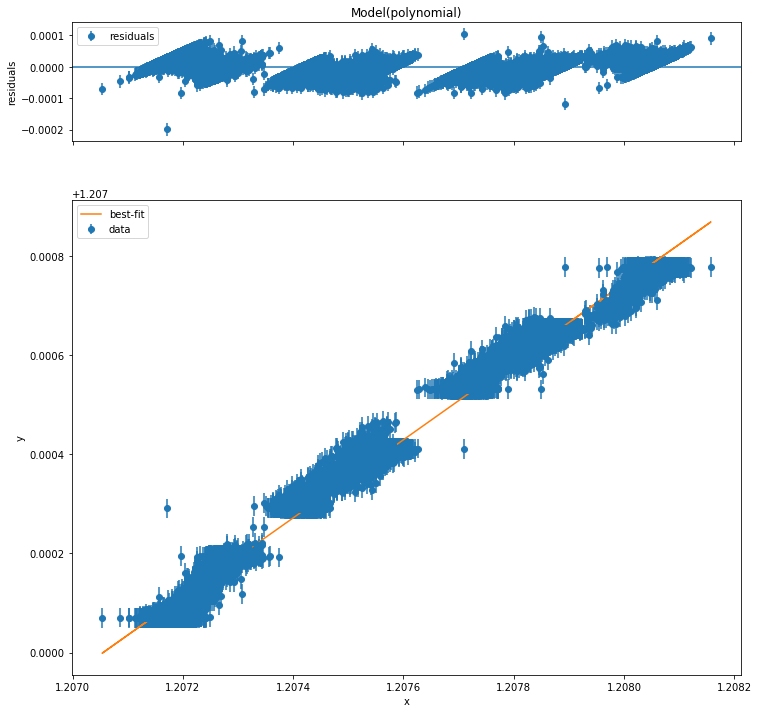

In [117]:
result.plot()

In [132]:
result = polyfit_order_n(8, df_[f"{probe}_Cal_T"], df_["Scaled Hall Voltage"], sigma_B)

[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 332
    # data points      = 22119
    # variables        = 9
    chi-square         = 20418.5485
    reduced chi-square = 0.92349835
    Akaike info crit   = -1751.37042
    Bayesian info crit = -1679.33269
[[Variables]]
    N:    8 (fixed)
    C_0: -50834504.7 +/- 1055699.27 (2.08%) (init = 0)
    C_1:  15620950.6 +/- 308635.070 (1.98%) (init = 0)
    C_2: -1738019.29 +/- 34917.8528 (2.01%) (init = 0)
    C_3:  82236.4627 +/- 1684.54182 (2.05%) (init = 0)
    C_4:  26.1596018 +/- 2.07267659 (7.92%) (init = 0)
    C_5: -183.901018 +/- 3.88018188 (2.11%) (init = 0)
    C_6:  8.55395175 +/- 0.18457209 (2.16%) (init = 0)
    C_7: -0.16987719 +/- 0.00374814 (2.21%) (init = 0)
    C_8:  0.00130542 +/- 2.9475e-05 (2.26%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(C_3, C_7) = -1.001
    C(C_1, C_5) = -1.001
    C(C_3, C_6) =  1.001
    C(C_2, C_5) =  1.001

(<Figure size 864x864 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

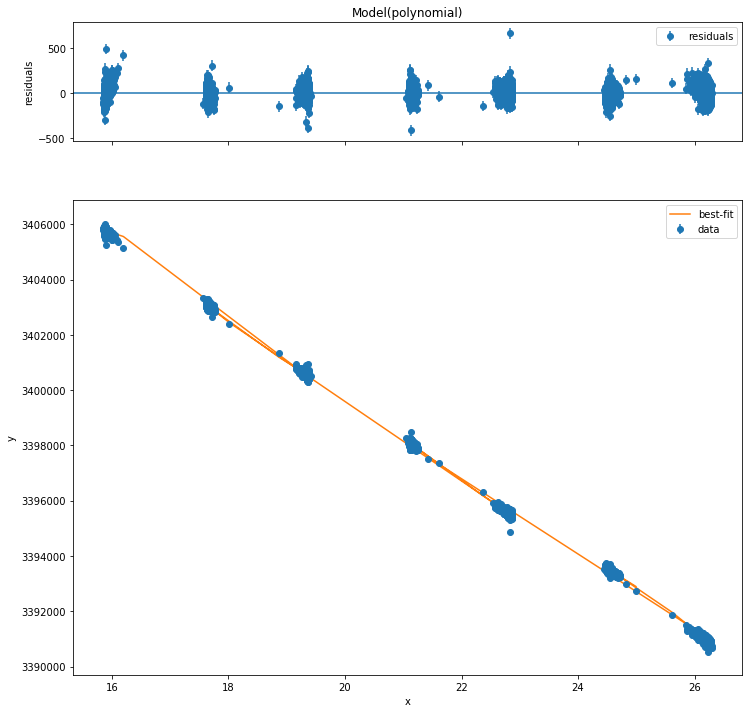

In [133]:
result.plot()

In [169]:
ns

array([35398.,  1270.,  4974.,  1439.,  1403.,  1430.,   204.,  1224.,
        2142.])

In [170]:
ns / ns.mean()

array([6.438081  , 0.23098375, 0.90465605, 0.26172096, 0.25517339,
       0.26008407, 0.0371029 , 0.22261741, 0.38958047])

In [ ]:
x_dat_avg = pd.Series(x_dat_avg)
ys = pd.Series(ys)
yerrs = pd.Series(yerrs)
ns = pd.Series(ns)

In [ ]:
result = polyfit_order_n(1,x_dat_avg, ys, ns.mean()*yerrs / ns)

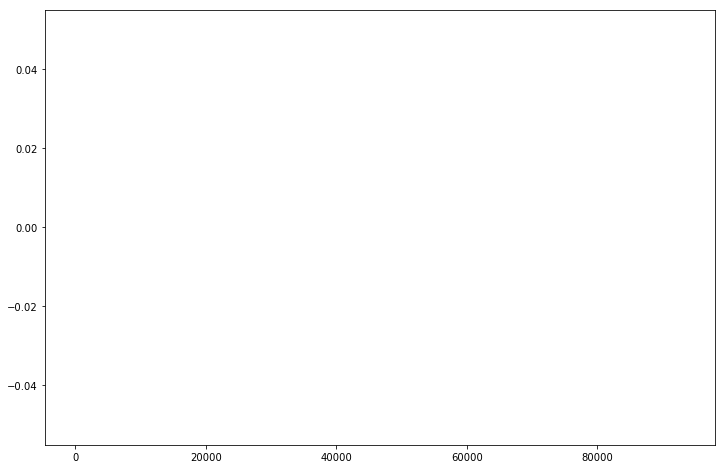

In [171]:
#def chi2(f, x, std):
#        return np.sum(np.square((x-f)/std))

#len(sigma_B)

#len(df_)

#fit_chi2 = chi2(df_["Bmag_lsq"], df_["Scaled Hall Voltage"], sigma_B)
#fit_chi2
fit_chi2 = result.chisqr#0.3247

dof = len(df_) - 5#4 # 4 parameter fit
#dof

n = np.linspace(0,12, 100)

P = stats.chi2.pdf(n, dof)

# 3rd order
plt.plot(n,P)
plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

In [ ]:
fig = scatter2d(df_.index, df_["DF0000000D5E803A_Cal_Res_Rel"], df_.days_delta, inline=False)

In [ ]:
result.plot()

In [172]:
def plot_polynomial(N, x_dat, y_dat, c_dat, result,
                    size=5, filename=None, inline=False, show_plot=True):
    
    ####averaged=True

    # plot the data
    fig = scatter2d(x_dat,
                    y_dat,
                    c_dat, opacity=0.9, show_plot=False)
    # add line for fit
    xs = np.linspace(x_dat.min(), x_dat.max(), 100)
    ys = result.eval(x=xs)
    fig.add_trace(go.Scatter(
                        x=xs, y=ys,
                        mode='lines', name=f'Order {N} Polynomial fit',#"|V|/|B| = A * Temp. + B",
                        line=dict(color='rgb(78, 42, 132)',#'deeppink',
                                  width=1,
                                  dash='dash')));
    #fig.add_trace(go.Scatter(
    #                    x=ts, y=B_lsq_avg,
    #                    mode='lines', name="mean(|V|/|B|) = A * mean(Temp.) + B",
    #                    line=dict(color='purple', width=1,
    #                              dash='dash')));

    fig.update_traces(marker=dict(size=size));

    '''if averaged:
        fig.add_trace(go.Scatter(
            x= xs,
            y= ys,
            mode='markers',
            name='Averaged Data',
            error_x=dict(
                type='data',
                array=xerrs,
                width=1,
                thickness=1.,
                visible=True),
            error_y=dict(
                type='data',
                array=yerrs,
                width=1,
                thickness=1.,
                visible=True),
            marker=dict(
                size=3,
                color="Red",
            )
        ))'''

    #eqn = f"Volt. = {A_fit:.2E} * Temp. + {B_fit:.2E}"
    eqn = f"y = "
    for n in range(N+1):
        p = result.params[f"C_{n}"]
        eqn += f"{p:.2E} * x^{n}"
        if (n >= 2) and ((n+1)%3 == 0) and (n != N):
            eqn += "<br>    "
    ax = 250
    ay = -25
    if result.params["C_1"] < 0:
        i = 20
        #ax= +
        #ay= -
    else:
        i = -20
        ax = -ax
        ay = -ay
    fig.add_annotation(
        go.layout.Annotation(
                x=xs[i],
                y=ys[i],
                text=eqn,
                font=dict(
                    #family="Courier New, monospace",
                    size=12,
                    color="#ffffff"
                ),
                align="center",
                arrowhead=2,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor="#636363",
                ax=ax,
                ay=ax,
                bordercolor="#c7c7c7",
                borderwidth=2,
                borderpad=4,
                bgcolor='rgb(78, 42, 132)',#"#ff7f0e",
                opacity=0.65,
                showarrow=True#False
        )
    )

    fig.update_layout(title="y vs. x")
    fig.update_xaxes(title_text='x')
    fig.update_yaxes(title_text='y')
    #fig.update_layout( width=1000,height=600,)

    #filename = plotdir+"scaled_voltage_vs_temperature_3rd_order"
    if filename == None:
        if show_plot:
            if inline:
                iplot(fig)
            else:
                plot(fig)
    else:
        if show_plot:
            if inline:
                iplot(fig, filename=filename+'.html')
            else:
                plot(fig, filename=filename+'.html')
        pio.write_image(fig, filename+'.pdf')
        pio.write_image(fig, filename+'.png')
    
    return fig

In [173]:
fig = plot_poly_chi2(4, result)

NameError: name 'plot_poly_chi2' is not defined

In [ ]:
fig = plot_poly_chi2(1, result)

In [ ]:
N = 1
len(result.data) - (N+1) # y values

In [174]:
def plot_poly_chi2(N, result, filename=None, inline=False, show_plot=True):
    dof = len(result.data) - (N+1)
    fit_chi2 = result.chisqr
    P_at_fit = 1.-stats.chi2.cdf(fit_chi2, dof)
    print(f"Probability of Chi2: {P_at_fit}")
    
    lo = min(fit_chi2*0.5, dof / 4)
    hi = max(fit_chi2*1.5, 2*dof*1.5)
    
    n = np.linspace(lo,hi, 1000)

    P = stats.chi2.pdf(n, dof)
    
    n = pd.Series(n, name="Chi^2")
    P = pd.Series(P, name="p.d.f.")
    
    if np.isfinite(P.max()):
        ymax = P.max()
    else:
        ymax = 1.

    fig = scatter2d(n,P, show_plot=False)
    fig.add_trace(go.Scatter(
                            x=[fit_chi2, fit_chi2], y=[0., ymax],
                            mode='lines', name=f'Fit Chi^2 = {fit_chi2}',#"|V|/|B| = A * Temp. + B",
                            line=dict(color='rgb(78, 42, 132)',#'deeppink',
                                      width=1,
                                      dash='dash')));
        
    if filename == None:
        if show_plot:
            if inline:
                iplot(fig)
            else:
                plot(fig)
    else:
        if show_plot:
            if inline:
                iplot(fig, filename=filename+'.html')
            else:
                plot(fig, filename=filename+'.html')
        pio.write_image(fig, filename+'.pdf')
        pio.write_image(fig, filename+'.png')
    
    return fig

In [175]:
fig = plot_poly_chi2(4, result)

Probability of Chi2: 0.0


In [ ]:
len(result.data)

In [ ]:
len(result.params) - 2

In [ ]:
result.chisqr

In [ ]:
result.

In [ ]:
result.eval(x=df[f"{probe}_Cal_T"])

In [ ]:
polynomial(np.array([0,1,2]), len(result.params)-2, **result.params)

In [ ]:
    df_["Bmag_lsq"] = volt_3rd(x_dat, A_fit, B_fit, C_fit, D_fit)
    df_["Bmag_lsq_avg"] = volt_3rd(x_dat, A_fit_avg, B_fit_avg, C_fit_avg, D_fit_avg)

    ts = np.linspace(x_dat.min(), x_dat.max(), 25)

    B_lsq = volt_3rd(ts, A_fit, B_fit, C_fit, D_fit)
    B_lsq_avg = volt_3rd(ts, A_fit_avg, B_fit_avg, C_fit_avg, D_fit_avg)

    B_lsq = pd.Series(B_lsq, name="Stable Temp Fit")
    B_lsq_avg = pd.Series(B_lsq_avg, name="Stable Temp Averaged Fit")

    averaged=True

    fig = scatter2d(x_dat,
                    y_dat,
                    df_.days_delta, opacity=0.8, show_plot=False)

    fig.add_trace(go.Scatter(
                        x=ts, y=B_lsq,
                        mode='lines', name='Linear fit',#"|V|/|B| = A * Temp. + B",
                        line=dict(color='rgb(78, 42, 132)',#'deeppink',
                                  width=1,
                                  dash='dash')));
    #fig.add_trace(go.Scatter(
    #                    x=ts, y=B_lsq_avg,
    #                    mode='lines', name="mean(|V|/|B|) = A * mean(Temp.) + B",
    #                    line=dict(color='purple', width=1,
    #                              dash='dash')));

    fig.update_traces(marker=dict(size=1));

    if averaged:
        fig.add_trace(go.Scatter(
            x= xs,
            y= ys,
            mode='markers',
            name='Averaged Data',
            error_x=dict(
                type='data',
                array=xerrs,
                width=1,
                thickness=1.,
                visible=True),
            error_y=dict(
                type='data',
                array=yerrs,
                width=1,
                thickness=1.,
                visible=True),
            marker=dict(
                size=3,
                color="Red",
            )
        ))

    #eqn = f"Volt. = {A_fit:.2E} * Temp. + {B_fit:.2E}"
    eqn = f"y = {A_fit:.2E} * x + {B_fit:.2E} * x^2 + {C_fit:.2E} * x^3 + {D_fit:.2E}"

    i = 6
    fig.add_annotation(
        go.layout.Annotation(
                x=ts[i],
                y=B_lsq.iloc[i],
                text=eqn,
                font=dict(
                    #family="Courier New, monospace",
                    size=14,
                    color="#ffffff"
                ),
                align="center",
                arrowhead=2,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor="#636363",
                ax=+250,
                ay=-25,
                bordercolor="#c7c7c7",
                borderwidth=2,
                borderpad=4,
                bgcolor='rgb(78, 42, 132)',#"#ff7f0e",
                opacity=0.7,
                showarrow=True#False
        )
    )

    fig.update_layout(title="Scaled Hall Voltage vs. Hall Probe Temperature")
    fig.update_xaxes(title_text='Hall Probe Temperature [deg C]')
    fig.update_yaxes(title_text='|V_Hall| / NMR [micro V / T]')
    fig.update_layout( width=1000,height=600,)

    filename = plotdir+"scaled_voltage_vs_temperature_3rd_order"

    plot(fig, filename=filename+'.html')

    pio.write_image(fig, filename+".pdf")
    pio.write_image(fig, filename+".png")



    def chi2(f, x, std):
        return np.sum(np.square((x-f)/std))

    len(sigma_B)

    len(df_)

    fit_chi2 = chi2(df_["Bmag_lsq"], df_["Scaled Hall Voltage"], sigma_B)
    fit_chi2

    dof = len(df_) - 3#4 # 4 parameter fit
    dof

    n = np.linspace(1000,20000, 1000)

    P = stats.chi2.pdf(n, dof)

    # 3rd order
    plt.plot(n,P)
    plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

    # 4th order
    plt.plot(n,P)
    plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

## OLD

In [ ]:
high_point = (df[f"{probe}_Cal_T"] > 20) & (df[f"{probe}_Cal_T"] < 21)
low_point = (df[f"{probe}_Cal_T"] > 16) & (df[f"{probe}_Cal_T"] < 17)
mid_point = (df[f"{probe}_Cal_T"] > 18) & (df[f"{probe}_Cal_T"] < 19)
h = high_point & stable_temp
l = low_point & stable_temp
m = mid_point & stable_temp

In [ ]:
plt.hist(df[h][f"{probe}_Raw_Bmag"]/df[h]["NMR [T]"], bins=50);

In [ ]:
fig = scatter2d(df[h][f"{probe}_Cal_T"], df[h][f"{probe}_Raw_Bmag"]/df[h]["NMR [T]"],
                df[h].days_delta, inline=False)

In [ ]:
hist2 = plt.hist2d(df[h][f"{probe}_Cal_T"], df[h][f"{probe}_Raw_Bmag"]/df[h]["NMR [T]"], bins=35);

In [ ]:
hist2[1]

In [ ]:
36*36

In [ ]:
len(hist2[1])

In [ ]:
len(hist2[2])

In [ ]:
int(np.floor(hist2[0].argmax() / 36))

In [ ]:
int(round(((hist2[0].argmax() / 35) - int(np.floor(hist2[0].argmax() / 35))) * 35))

In [ ]:
1296-int(np.floor(hist2[0].argmax() / 36))*36

In [ ]:
hist2[0][int(np.floor(hist2[0].argmax() / 35)), int(round(((hist2[0].argmax() / 35) - int(np.floor(hist2[0].argmax() / 35))) * 35))]

In [ ]:
for x, y in np.argwhere(hist2[0] == hist2[0].max()):
    # center is between x and x+1
    print(np.average(hist2[1][x:x + 2]), np.average(hist2[2][y:y + 2]))

In [ ]:
(df[h][f"{probe}_Raw_Bmag"]/df[h]["NMR [T]"]).describe()

In [ ]:
df[h][f"{probe}_Cal_T"].describe()

In [ ]:
fig = scatter2d(df[stable_temp].index, df[stable_temp]["Floor"], inline=False)

In [ ]:
fig = scatter2d(df.index, df["Floor"].diff(5).rolling(5).mean(), inline=False)

In [ ]:
df["Roof"].diff(4).plot()

In [ ]:
df["NMR [T]"].plot()
#df["Roof"].diff(1).plot();

In [ ]:
df_ = df[l|m|h]

In [ ]:
def volt(temp, A, B):
    return A * temp + B

In [ ]:
guess = np.array([-1300 / 3.5, 2e6]) # A, B

In [ ]:
x_dat = df_[f"{probe}_Cal_T"]
#x_dat = df[stable_temp][f"{probe}_Cal_T"]

In [ ]:
params, cov = optimization.curve_fit(volt, x_dat, df_[f"{probe}_Raw_Bmag"] / df_["NMR [T]"], guess)
#params, cov = optimization.curve_fit(volt, x_dat, 
#                                     df[stable_temp][f"{probe}_Raw_Bmag"] / df[stable_temp]["NMR [T]"], guess)

In [ ]:
# Bmag ### STABLE TEMP
params, cov

In [ ]:
np.sqrt(cov[0,0])

In [ ]:
cov[0,1] / (np.sqrt(cov[0,0])*np.sqrt(cov[1,1]))

Parameters have strong correlation

In [ ]:
A_fit, B_fit = params

In [ ]:
df_["Bmag_lsq"] = volt(x_dat, A_fit, B_fit)

In [ ]:
p_low = [df[l][f"{probe}_Cal_T"].mean(), (df[l][f"{probe}_Raw_Bmag"]/df[l]["NMR [T]"]).mean()]
p_high = [df[h][f"{probe}_Cal_T"].mean(), (df[h][f"{probe}_Raw_Bmag"]/df[h]["NMR [T]"]).mean()]
p_mid = [df[m][f"{probe}_Cal_T"].mean(), (df[m][f"{probe}_Raw_Bmag"]/df[m]["NMR [T]"]).mean()]

In [ ]:
std_low = [df[l][f"{probe}_Cal_T"].std(), (df[l][f"{probe}_Raw_Bmag"]/df[l]["NMR [T]"]).std()]
std_high = [df[h][f"{probe}_Cal_T"].std(), (df[h][f"{probe}_Raw_Bmag"]/df[h]["NMR [T]"]).std()]
std_mid = [df[m][f"{probe}_Cal_T"].std(), (df[m][f"{probe}_Raw_Bmag"]/df[m]["NMR [T]"]).std()]

In [ ]:
std_low

In [ ]:
fig = scatter2d(df_[f"{probe}_Cal_T"],
                df_[f"{probe}_Raw_Bmag"] / df_["NMR [T]"],
                df_.days_delta, show_plot=False)
#d = [df[f"{probe}_Raw_X"].min(), df[f"{probe}_Raw_X"].max()]
fig.add_trace(go.Scatter(
                    x=df_[f"{probe}_Cal_T"], y=df_["Bmag_lsq"],
                    mode='lines', name="|V|/|B| = A * Temp. + B",
                    line=dict(color='deeppink', width=1,
                              dash='dash')));
#plot(fig)

fig.update_traces(marker=dict(size=1));
#plot(fig);

fig.add_trace(go.Scatter(
    x= [p_low[0],p_mid[0],p_high[0]],
    y=[p_low[1],p_mid[1],p_high[1]],
    mode='markers',
    name='averaged_data',
    error_x=dict(
        type='data',
        array=[std_low[0], std_mid[0], std_high[0]],
        width=1,
        thickness=1.,
        visible=True),
    error_y=dict(
        type='data',
        array=[std_low[1], std_mid[1], std_high[1]],
        width=1,
        thickness=1.,
        visible=True),
    marker=dict(
        size=4,
        color="Red",
    )
))

fig.update_layout(title="Scaled Hall Voltage vs. Hall Probe Temperature")
fig.update_xaxes(title_text='Hall Probe Temperature [deg C]')
fig.update_yaxes(title_text='|V_Hall| / NMR [micro V / T]')
fig.update_layout( width=1200,height=900,)

#fig = go.Figure(traces)
plot(fig, filename=plotdir+"temp_fit_2point_aggregate.html")

In [ ]:
pio.write_image(fig, plotdir+"temp_fit_2point_aggregate.pdf")
pio.write_image(fig, plotdir+"temp_fit_2point_aggregate.png")

In [ ]:
std_low

In [ ]:
std_mid

In [ ]:
std_high

In [ ]:
### pick std = 55
std_volt = 45.#55.

In [ ]:
def chi2(f, x, std):
    return np.sum(np.square((x-f)/std))

In [ ]:
fit_chi2 = chi2(df_["Bmag_lsq"], df_[f"{probe}_Raw_Bmag"]/df_["NMR [T]"], std_volt)
fit_chi2

In [ ]:
# check std
df_2 = df_[100:500]

In [ ]:
fig = scatter2d(df_2.index, df_2[f"{probe}_Raw_Bmag"]/df_2["NMR [T]"],
               inline=False)

In [ ]:
scaled_B = df_2[f"{probe}_Raw_Bmag"]/df_2["NMR [T]"]
scaled_B.name = "Scaled |V|/|B|"

In [ ]:
fig = histo(scaled_B, bins=25,
               inline=False)

In [ ]:
dof = len(df_) - 2
dof

In [ ]:
stats.chi2.pdf(6300, 6325)

In [ ]:
n = np.linspace(0, 7000, 1000)

In [ ]:
P = stats.chi2.pdf(n, dof)

In [ ]:
plt.plot(n,P)
plt.plot([fit_chi2, fit_chi2],[0., P.max()], 'r--');

In [ ]:
n[P.argmax()]

## Magnet Behavior

In [ ]:
probes

In [ ]:
x_dat = df.index
y_dat = df[f"{probes[0]}_Raw_X"]

In [ ]:
fig = scatter2d(x_dat, y_dat, df.days_delta, inline=False)